# Initialize

In [1]:
# import packages 

%load_ext autoreload
# OS Imports
import os
from os import listdir
from os.path import isfile, join
import shutil
import inspect

# Garbage collection 
import gc
import sys

# Basic math/data processing packages
import numpy as np
from scipy import signal
import pandas as pd 
import matplotlib.pyplot as plt
import math
import matplotlib
import random
import time 
import datetime
from collections import deque
import itertools

from IPython.lib.display import isdir


# Imports for CSV Processing
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, PowerNorm
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
import pickle
import openpyxl

# Imports for Deep Learning for data preparation and SVM 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, confusion_matrix, 
    ConfusionMatrixDisplay, classification_report, 
    cohen_kappa_score, matthews_corrcoef)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn import linear_model

# Keras/TF Packages
import keras

from keras.regularizers import l1
from keras.models import Sequential, load_model
from keras import initializers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import (Dense, Dropout, Activation, Flatten, Input, 
                          TimeDistributed, Reshape, Permute, Flatten, 
                          RepeatVector, Bidirectional, InputLayer,  
                          AlphaDropout, Normalization, MaxPooling2D, Embedding, 
                          ConvLSTM1D, Attention, TimeDistributed, LocallyConnected1D,
                          LSTM, GRU)
from keras.models import Model, load_model
from keras import optimizers
from keras.utils import plot_model
from keras.utils import to_categorical

from tensorflow.keras.optimizers import Nadam, Adam, SGD, Adadelta, Adamax, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import tensorflow as tf

print(keras.__version__)
print(tf.__version__)

print(matplotlib.__version__)

%load_ext tensorboard

2.10.0
2.10.1
3.8.2


In [2]:
# Print GPU details if recognized
# Ensure GPU RAM is >10 GB
!nvidia-smi
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Setup CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


Sun May 25 19:29:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:06:00.0  On |                  Off |
|  0%   46C    P8             28W /  450W |    1210MiB /  24564MiB |     36%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Consistent random seed selection improves reliability of Keras training performance
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
def setPaths(data_path,epoch_length):
    # Set paths to preprocessed data based on epoch length
    match epoch_length:
        case 20:
            data_path='C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/'
            %cd $data_path

        case 4:
            data_path='C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Four Second Epochs/'
            %cd $data_path


    # Set paths to Fourier-extracted data
    path_Fourier=data_path+'Export_FFTFix/Py/'


    # Set output paths for data, variables, and results
    path_output=data_path+'CSV_Outputs/'
    path_variables=data_path+'Variables/'
    path_results=data_path+'Results_GPU/'

    # Create folders if they do not exist
    for path_iterable in [path_output,path_variables,path_results]:
        if os.path.exists(path_iterable)==False:
            os.mkdir(path_iterable)
          
    # Return paths
    return data_path, path_Fourier, path_output, path_variables, path_results

def generate_output_folders(path_output):
    path_unscored=f'{path_output}/csv_classifier_prev_un_scored'
    path_classifier_scores=f'{path_output}/csv_trainset_classifier_scored'
    mouse_sort_csvs=f'{path_output}csv_full/'
    path_expert_scores=f'{path_output}/csv_trainset_expert_scored'
    path_figs=f'{path_output}figures/'
    path_conf=f'{path_output}score_conf/'
    path_excel=f'{path_output}excel/'
    
    # Create CSV and output folders
    for path_iterable in [path_unscored, path_classifier_scores, mouse_sort_csvs, path_expert_scores, path_figs, path_excel, path_conf]:
        if os.path.exists(path_iterable)==False:
            os.mkdir(path_iterable)

    return path_unscored, path_classifier_scores, mouse_sort_csvs, path_expert_scores, path_figs, path_excel, path_conf

In [108]:
# Set paths based on base path where data is stored
data_path, path_Fourier, path_output, path_variables, path_results = setPaths(data_path=None, epoch_length=20)
%cd $data_path

path_unscored, path_classifier_scores, mouse_sort_csvs, path_expert_scores, path_figs, path_excel, path_conf = generate_output_folders(path_output)

C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Twenty Second Epochs
C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Twenty Second Epochs


In [6]:
# Number of hours of recording per file
train_recording_hours=12

# Length of epochs in seconds
train_recording_epoch_seconds=20

# Total number of epochs per recording
train_recording_epoch_count=int( (train_recording_hours*3600)/train_recording_epoch_seconds )

# List of all viable integer codes for scores. Any other integers in "score" array will be rejected
viable_scores=[0,1,2,3,4]

In [7]:
# # Path to existing trained model file
# modelpath=f'{path_results}Final Model/Models/BiLSTM_size_200_win3.h5'



print(mouse_sort_csvs)

C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/CSV_Outputs/csv_full/


# Define Functions

## Array Manipulation Functions

In [8]:
def consecutive(data, stepsize=1):
    # Simple function for finding blocks of consecutive numbers in an array
    # Find indicies where numbers differ
    inds =  np.where(np.diff(data) != stepsize)[0]+1
    # Split data on these indicies
    consec = np.split(data, inds)
    return consec, inds

In [9]:
def unique(list1): 
  
    # Intilize a null list 
    global unique_list  
    unique_list = [] 
    
    # Traverse for all elements 
    for x in list1: 
        # Check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
            
    return sorted(unique_list)

In [10]:
def list_prune_via_substrings(list_to_be_scanned, substring_list):
  result_list=[]

  if type(list_to_be_scanned[0])!=str:
    list_to_be_scanned=str(list_to_be_scanned)

  if type(substring_list[0])!=str:
    substring_list=[str(sub) for sub in substring_list]

  for scan_member in list_to_be_scanned:
    present=1
    for member in substring_list:
      if member in scan_member:
        present=0
    
    if present==1:
      result_list.append(scan_member)

  return result_list

In [11]:
def get_start_end(data_path):
    # Load .xlsx containing start and end dates of recording for each animal
    Excel=f'{data_path}/Start and End Dates.xlsx'
    df = pd.read_excel(Excel)
    start_dates=[]
    end_dates=[]
    # Transfer start and end dates to array for parsing
    for i in range(len(df)):
        start_dates.append(df['Name'][i])
        start_dates.append(df['Start'][i])
        end_dates.append(df['Name'][i])
        end_dates.append(df['End'][i])
    return start_dates,end_dates

def get_manual_dates(data_path):
    # Load .xlsx containing dates where animal data was manually scored
    Excel=f'{data_path}/Manual Dates.xlsx'
    df = pd.read_excel(Excel)

    return df

## Preprocessing Functions

In [12]:
def quality_check(path, fourier_files, viable_scores):
    files_parsed=[]
    for file in fourier_files:
        keep=True
        
        try:
            npyFile=np.load(f"{path}{file}")
            if npyFile.shape[-1]<=100:
                print(file)
                print('\t unscored')
                keep=False
                
            if np.isin(np.unique(npyFile[:,-1:]) , viable_scores).all() == False:
                print(file)
                print('\t score out of bounds')
                keep=False
                
            if np.isnan(npyFile[:,:100]).any() == True:
                print(file)
                print('\t nan in vals')
                keep=False
                
            if np.isnan(StandardScaler().fit_transform(npyFile[:,:100])).any() == True:
                print(file)
                print('\t nan after scaling')
                keep=False
                
        except:
            keep=False
            
        if keep==True:
            files_parsed.append(file)


    return files_parsed
  

In [13]:
def quality_check_scoring(fourier_files):
    files_parsed=[]
    for filepath in fourier_files:
        keep=True
        
        try:
            npyFile=np.load(f"{filepath}")
                
            if np.isnan(npyFile[:,:100]).any() == True:
                print(filepath)
                print('\t nan in vals')
                keep=False
                
            if np.isnan(StandardScaler().fit_transform(npyFile[:,:100])).any() == True:
                print(filepath)
                print('\t nan after scaling')
                keep=False

        except:
            keep=False
            
        if keep==True:
            files_parsed.append(filepath)


    return files_parsed      

In [14]:
def load_Fourier_xy(path, file_list, train_recording_epoch_count, viable_scores, standardize=True):

    total_files = len(file_list)  # Length of file list
    print(total_files)
    
    epochs = train_recording_epoch_count   
    total_epoch_count = int(epochs*(total_files)) # Total length of data array in 20 second epochs
    
    # Create displays at top of notebook output for reverse counter and current status
    dh1 = display(f'Items left: {total_files}',display_id=True)
    dh2 = display('Loading...',display_id=True)

    # Counting variable for progress
    file_counter = 0

    # Initialize arrays for x and y, total epochs in datset by number of features in vector 
    x = np.zeros((total_epoch_count, 100))
    y = np.zeros((total_epoch_count, 1))
    exclusion = False
    
    # Iterate over all Fourier transformed files
    for item in (sorted(file_list)):
        # Increment count down to completion of file loading
        total_files -= 1
        # Update display for files remaining
        dh1.update(f'Items left: {total_files}')

        # Load Fourier feature vectors
        current_file = np.load(f"{path}{item}")
        
        # Load feature vectors for each file
        # If standardization is on, standardize values to 0-1 range for quicker training and evaluation
        if standardize==True:
            x[file_counter*epochs:((file_counter+1)*epochs)] = StandardScaler().fit_transform(current_file[:,:100])
        else:
            x[file_counter*epochs:((file_counter+1)*epochs)] = current_file[:,:100]

        
        # load Sleep/Seizure score vectors
        y[file_counter*epochs:((file_counter+1)*epochs)] = current_file[:,-1:]

        file_counter += 1
        # Update display for current status
        dh2.update(f'loaded x and y for {item}')
        # Periodically print progress 
        if file_counter%50 == 0:
            print(file_counter)



    return x,y

In [15]:
def generate_sequences(input_array, windows, x_or_y, max_feats=None, make_seq=True):
    if make_seq==True:
        if x_or_y not in ['X', 'Y']:
            print("Please designate whether input is X or Y array using x_or_y parameter")
            return 

        for window in [windows]: # for loop to test varying window lengths
            classes=5

            shift=window*2 # All x variable rows will be sampled with sliding sequences 
            # If analyzing epoch 3, epochs from -window_length (0) to 
            # +window_length (6) around each epoch of interest will be sampled
            # Therefore, the windowing cannot begin earlier than epoch # [window_length]


            if x_or_y in ['X']:
                if max_feats == None:
                    # Get maximum numnber of features from X array if not specified
                    max_feats=input_array.shape[1]

                # Generate sliding window array 
                output_array=np.zeros((len(input_array)-shift,window*2+1,max_feats))
                
                # Cannot window on both sides unless first array taken has full window length prior to and after it, so for loop starts at window index and ends at end-window
                for i in range(window,len(input_array)-window):
                    output_array[i-window]=input_array[i-window:i+window+1,0:max_feats]
        
        
            if x_or_y in ['Y']:
                output_array=np.zeros((len(input_array)-shift, classes))
                for i in range(window,len(input_array)-window):
                    output_array[i-window]=input_array[i]


        gc.collect()
        return output_array

    elif make_seq==False:
        print('no sequence generated')
        return input_array

## Model Training Functions

In [16]:
def common_training_parameters():
    # Keras metrics for training evaluation
    metrics = [
        'accuracy',
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc', curve="PR"),
        keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy')]

    # Batch size of training/evaluation = one 12 hour recording file worth of 20 second epochs
    batch_size = 2160

    # Set training optimizer
    optimizer=Nadam(learning_rate=0.00001)
    # Set regularization function for training
    activity_regularizer=l1(0.0001)

    return batch_size, metrics, optimizer, activity_regularizer

In [17]:
def norm_sklearn_classweight(y_train, mu=False, norm=True):
    
    # Get maximum range of class labels 
    classes = unique(np.argmax(y_train,1))

    # Convert scores back from one-hot to ints
    y_train_classes = [np.argmax(z) for z in y_train]
    unique(y_train_classes)

    
    # Assign balanced class weights
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_classes)
    print(weights)
    class_weight = {}
    ind = 0

    if norm==False:
        for i in classes:
            class_weight[i] = weights[i]
        return class_weight

    if norm==True:
        # Adjust weights based upon mu parameter (logarithmic normalization of class weights) or the minimum weight present
        mu=weights[0]/math.exp(1)
        for i in classes:
            j = int(np.where(classes==i)[0])
            score = math.log(weights[j]/mu)
            class_weight[j] = score 
    
        return class_weight

In [18]:
def create_train_Dense_model(X_train, X_test, y_train, y_test, class_weight, epochs, 
                       steps_per_epoch=None, layer_size=8, batch_size=2160, optimizer=Nadam(learning_rate=0.00001), metrics=['accuracy'], activity_regularizer=l1(0.0001), prefix="", layers=3, data_path='',savepath='./'):
        
        # Get dimensions for model input layer from input array
        data_width=X_train.shape[1]
   
        if len(X_train.shape)>2:
            data_depth=X_train.shape[2]
            shape=(data_width,data_depth)
        else: 
            data_width=X_train.shape[1]
            shape=(data_width,)

        # Create Sequential Model 
        model = Sequential()
        model.add(InputLayer(input_shape=shape))
        model.add(Dense(layer_size))
        model.add(Flatten())           
        model.add(Dense(5))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    
        model.build()
        model.summary()

        # Name model with logging based on training time and date and metrics to track
        model_name=f"Dense_size_{layer_size}_{prefix}_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        filepath = f"{model_name}"+"_weights-auc-{auc}-{categorical_accuracy:.6f}--val-{val_auc}-{val_categorical_accuracy:.6f}.h5"

        # Keras model checkpoint function
        mcp = ModelCheckpoint(f"{savepath}Checkpoints/{filepath}", 
                              monitor='val_loss', verbose=1, 
                              save_best_only=True, save_weights_only=False, mode='min')

        # Early stopping parameters
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=5, min_delta=0.001,restore_best_weights=True)

        # Tensorboard logging variables
        log_dir = f"./Logs/{model_name}"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        logpath=f"./Logs/"
        csv_path=f"{model_name}_model.csv"
        csv_logger=CSVLogger(logpath+csv_path)

        # Fitting function
        history = model.fit(X_train, y_train, batch_size=batch_size, class_weight=class_weight, epochs=epochs, 
                            steps_per_epoch=steps_per_epoch,
                            validation_data=(X_test, y_test), verbose=2, callbacks=[es, csv_logger, tensorboard_callback])

        return model, history, logpath, csv_path, model_name


In [19]:
def create_train_LSTM_model(X_train, X_test, y_train, y_test, class_weight, epochs, 
                       steps_per_epoch=None, layer_size=200, batch_size=2160, optimizer=Nadam(learning_rate=0.00001), metrics=['accuracy'], activity_regularizer=l1(0.0001), prefix="", layers=1, data_path='',savepath='./'):

        # Get dimensions for model input layer from input array
        data_width=X_train.shape[1]
   
        if len(X_train.shape)>2:
            data_depth=X_train.shape[2]
            shape=(data_width,data_depth)
        else: 
            data_width=X_train.shape[1]
            shape=(data_width,)
        LSTM_size=layer_size
        # Create Sequential Model 
        model = Sequential()
        model.add(InputLayer(input_shape=shape))
        model.add(LSTM(int(LSTM_size), activity_regularizer=activity_regularizer, return_sequences=True))
        model.add(Dropout(.4))
        model.add(Flatten())     
        model.add(Dense(5))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    
        model.build()
        model.summary()
        
        # Name model with logging based on training time and date and metrics to track
        model_name=f"Single_LSTM_size_{LSTM_size}_{prefix}_"
        filepath = f"{model_name}"+"_weights.auc:{auc}-{categorical_accuracy:.6f}--val-{val_auc}-{val_categorical_accuracy:.6f}.h5"
        
        # Keras model checkpoint function
        mcp = ModelCheckpoint(f"{savepath}Checkpoints/{filepath}", 
                              monitor='val_loss', verbose=1, 
                              save_best_only=True, save_weights_only=False, mode='min')       
    
        # Early stopping parameters              
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=5, min_delta=0.001,restore_best_weights=True)
    
        # Tensorboard logging variables    
        log_dir = f"./Logs/{model_name}"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        logpath=f"./Logs/"   
        csv_path=f"{model_name}_model.csv"
        csv_logger=CSVLogger(logpath+csv_path)
        
        # Model fitting call
        history = model.fit(X_train, y_train, batch_size=batch_size, class_weight=class_weight, epochs=epochs, 
                            steps_per_epoch=steps_per_epoch,
                            validation_data=(X_test, y_test), verbose=2, callbacks=[es, csv_logger, tensorboard_callback])

        return model, history, logpath, csv_path, model_name

In [20]:
def create_train_BiLSTM_model(X_train, X_test, y_train, y_test, class_weight, epochs, 
                       steps_per_epoch=None, layer_size=200, batch_size=2160, optimizer=Nadam(learning_rate=0.00001), metrics=['accuracy'], activity_regularizer=l1(0.0001), prefix="", layers=1, data_path='',savepath='./'):
        
        # Get dimensions for model input layer from input array
        data_width=X_train.shape[1]
   
        if len(X_train.shape)>2:
            data_depth=X_train.shape[2]
            shape=(data_width,data_depth)
        else: 
            data_width=X_train.shape[1]
            shape=(data_width,)
            
        # Create Sequential Model 
        model = Sequential()
        model.add(InputLayer(input_shape=shape))
        
        LSTM_size=layer_size
    
        for count in range(layers):
            if count==0:
              activity_regularizer=l1(0.0001)
            else:
              activity_regularizer=None
          
            factor = 2**(count)
            forward_layer = LSTM(int(LSTM_size/factor), activity_regularizer=activity_regularizer, return_sequences=True)
            backward_layer = LSTM(int(LSTM_size/factor), activity_regularizer=activity_regularizer, return_sequences=True,
                                  go_backwards=True)
            model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
            model.add(Dropout(.4))

        # Dense softmax prediction
        model.add(Flatten())     
        model.add(Dense(5))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

        model.build()
        model.summary()
        
        # Name model with logging based on training time and date and metrics to track
        if layers==4:
            model_name=f"QBiLSTM_size_{LSTM_size}_{prefix}_"
        else:
            model_name=f"BiLSTM_size_{LSTM_size}_{prefix}_"
        filepath = f"{model_name}"+"_weights-auc-{auc}-{categorical_accuracy:.6f}--val-{val_auc}-{val_categorical_accuracy:.6f}.h5"

        # Keras model checkpoint function
        mcp = ModelCheckpoint(f"{savepath}Checkpoints/{filepath}", 
                              monitor='val_loss', verbose=1, 
                              save_best_only=True, save_weights_only=False, mode='min')     
    
        # Early stopping parameters                                            
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=5, min_delta=0.001,restore_best_weights=True)
        if os.path.exists(savepath)==False:
                os.mkdir(savepath)
        # Tensorboard logging variables        
        log_dir = f"{savepath}Logs/{model_name}"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        logpath=f"{savepath}Logs/"
        csv_path=f"{model_name}_model.csv"
        csv_logger=CSVLogger(logpath+csv_path)
    
        # Model fitting call
        history = model.fit(X_train, y_train, batch_size=batch_size, class_weight=class_weight, epochs=epochs, 
                            steps_per_epoch=steps_per_epoch,
                            validation_data=(X_test, y_test), verbose=2, callbacks=[es, csv_logger, tensorboard_callback])

        return model, history, logpath, csv_path, model_name

In [21]:
def create_train_flat_BiLSTM_model(X_train, X_test, y_train, y_test, class_weight, epochs, 
                       steps_per_epoch=None, layer_size=200, batch_size=2160, optimizer=Nadam(learning_rate=0.00001), metrics=['accuracy'], activity_regularizer=l1(0.0001), prefix="", layers=3, data_path='',savepath='./'):

        # Get dimensions for model input layer from input array
        data_width = X_train.shape[1]
        data_depth = X_train.shape[2]
        shape = (data_width,data_depth)
            
        # Create Sequential Model 
        # Model creation with optional stacking of Bi-LSTM/Dropout pairs
        model = Sequential()
        model.add(InputLayer(input_shape=shape))
        model.add(Flatten())           
        model.add(RepeatVector(1)) 

        # Each Bi-LSTM in cascade gets smaller by a factor of 2
        if layers in range(1,5):
            forward_layer = LSTM(int(LSTM_size), return_sequences=True)
            backward_layer = LSTM(int(LSTM_size), return_sequences=True,
                                  go_backwards=True)
            model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
            model.add(RepeatVector(1)) 
            model.add(Dropout(.4))

            factor = 2
            if layers in range (2,5):
              forward_layer = LSTM(int(LSTM_size/factor), return_sequences=True)
              backward_layer = LSTM(int(LSTM_size/factor), return_sequences=True,
                                    go_backwards=True)
              model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
              model.add(Dropout(.4))
              model.add(RepeatVector(1)) 

              factor = 4
              if layers in range (3,5):
                forward_layer = LSTM(int(LSTM_size/factor), return_sequences=True)
                backward_layer = LSTM(int(LSTM_size/factor), return_sequences=True,
                                      go_backwards=True)
                model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
                model.add(Dropout(.4))
                model.add(RepeatVector(1)) 

                factor = 8
                if layers in range (4,5):
                    forward_layer = LSTM(int(LSTM_size/factor), return_sequences=True)
                    backward_layer = LSTM(int(LSTM_size/factor), return_sequences=True,
                                          go_backwards=True)
                    model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
                    model.add(Dropout(.4))
                    model.add(RepeatVector(1)) 
                
        model.add(Flatten())     
        model.add(Dense(5))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=METRICS)
        
        model.build()
        model.summary()
                
        # Name model with logging based on training time and date and metrics to track
        model_name=f"flat_LSTM_size_{LSTM_size}_{prefix}_"
        filepath = f"{model_name}"+"_weights-auc-{auc}-{categorical_accuracy:.6f}--val-{val_auc}-{val_categorical_accuracy:.6f}.h5"

        # Keras model checkpoint function
        mcp = ModelCheckpoint(f"./Checkpoints/{filepath}", 
                              monitor='val_loss', verbose=1, 
                              save_best_only=True, save_weights_only=False, mode='min')      
    
        # Early stopping parameters                                            
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                    patience=5, min_delta=0.001,restore_best_weights=True)

        # Tensorboard logging variables        
        log_dir = f"./Logs/{model_name}"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        logpath=f"./Logs/"
        csv_path=f"{model_name}_flat_model.csv"
        csv_logger=CSVLogger(logpath+csv_path)
        
        # Model fitting call
        history = model.fit(X_train, y_train, batch_size=batch_size, class_weight=class_weight, epochs=epochs, 
                            steps_per_epoch=steps_per_epoch,
                            validation_data=(X_test, y_test), verbose=2, callbacks=[es, csv_logger, tensorboard_callback])


        return model, history, logpath, csv_path, model_name

## Training Bookkeeping Functions

In [22]:
def save_model_report_seq(model, model_history, ctrls=0, run=2, x=[], y=[], X_train_seq=[], X_val_seq=[], y_train_seq=[], y_val_seq=[], X_test_seq=[], y_test_seq=[], model_name='test',i=1,model_num=8,data_path='',logpath='', csvpath='',savepath='./Results/'):  
    
    # Print model name to output
    print(model_name)
    
    # Assess Confusion Matrices with limited states for full-saline cohorts 
    if ctrls==1:
        num_classes=3
    else:
        num_classes=5

    # Name files based on dataset 
    if ctrls==0:
        charpath=f'Kainic Acid'
    elif ctrls==1:
        charpath=f'Control'
    elif ctrls==2:
        charpath='AllData'


    # Make output directories for models, confusion matrices, and softmax confidence outputs
    if os.path.exists(savepath)==False:
        os.mkdir(savepath)
    if os.path.exists(f'{savepath}Models/')==False:
        os.mkdir(f'{savepath}Models/')
    if os.path.exists(f'{savepath}Softmax/')==False:
        os.mkdir(f'{savepath}Softmax/')

    # Codes for generating and naming confusion matrices
    codes=np.array(['Wake','NREM','REM','Seizure','Post-Ictal'])

    # Save hdf5 model within output folder
    if os.path.exists(f'{savepath}Models/{model_name}.h5')==False:
       model.save(f'{savepath}Models/{model_name}.h5')  

    # Save Model History dictionary 
    if model_history!=None:
        with open(f'{savepath}{model_name}{model_num}historydict','wb') as file_pi:
            pickle.dump(model_history.history, file_pi)
          
        shutil.copyfile(logpath+csvpath, f'{savepath}{csvpath}')
        
    # Reconstitute entire dataset for evaluation
    x_new=np.concatenate((X_test_seq,X_val_seq, X_train_seq))
    y_new_1hot=np.concatenate((y_test_seq,y_val_seq, y_train_seq))
      
    # With model report text file open, generate report text
    with open(f'{savepath}Report_{model_name}.txt','w') as f:
        # Iterate over train/test/val and combined datasets 
        # Create Matrices/Reports for all datasets in train/test/val, as well as overall statistics
        for selection in range(0,4):
            gc.collect()
            names=['Saline-KA Holdout Testing Dataset', 'Saline Control Validation Dataset', 'Training Dataset', 'Training, Validation, and Testing Overall']
            X_check, y_check = [[X_test_seq, y_test_seq], [X_val_seq, y_val_seq],[X_train_seq, y_train_seq], [x_new, y_new_1hot]][selection]

            # Predict scores 
            y_pred=model.predict(X_check, batch_size=2160)
            # Save softmax results
            y_pred.tofile(f'{savepath}Softmax/results_{model_name}.csv', sep=',')
            
            # Get codes from softmax results
            y_pred_codes=np.argmax(y_pred,1)
            y_test_codes=np.argmax(y_check,1)
            
            # Print classification reports to Report txt
            print(f'\n {names[selection]} \n', file=f)
            print(classification_report(y_test_codes, y_pred_codes), file=f)

            # Save classification report as dataframe to excel 
            dict1 = classification_report(y_test_codes, y_pred_codes, output_dict=True)
            df = pd.DataFrame(data=dict1)
            df = (df.T)
            print (df)
            dataset_name=names[selection]
            df.to_excel(f'{savepath}{dataset_name}{model_name}.xlsx')

            # Generate normalized confusion matrix 
            cm=confusion_matrix(y_test_codes,y_pred_codes,normalize='true')

            # Sanity check that all states in dataset are accounted for in results
            print(f'unique ground truth labels: {unique(y_test_codes)}')
            print(f'unique predicted labels: {unique(y_pred_codes)}')
    
            # Display confusion matrix with whichever dataset has more labels in it - otherwise it will not plot 
            if len(unique(y_pred_codes))>len(unique(y_test_codes)):
              disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=codes[unique(y_pred_codes)])
            else:
              disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=codes[unique(y_test_codes)])
    
            disp.plot()

            # Plot and save confusion matrix as .png and .svg for publication
            print(f'{names[selection]}')
            plt.title(f'Confusion Matrix for {names[selection]}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.savefig(f'{savepath}{model_name}_{names[selection]}_CM_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.png', dpi=700)
            plt.savefig(f'{savepath}{model_name}_{names[selection]}_CM_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.svg', dpi=700)
    
    
            plt.close()
            gc.collect()

In [23]:
def save_model_report_svg(model, model_history, ctrls=0, run=2, x=[], y=[], X_train_seq=[], X_val_seq=[], y_train_seq=[], y_val_seq=[], X_test_seq=[], y_test_seq=[], model_name='test',i=1,model_num=8,data_path='', savepath='./Results/',textsize = 15):  

    # Same function as save_model_report_seq, but without saving of history dicts and models, just for confusion matrix output
    
    # Print model name to output
    print(model_name)

    # Assess Confusion Matrices with limited states for full-saline cohorts 
    if ctrls==1:
        num_classes=3
    else:
        num_classes=5

    # Name files based on dataset 
    if ctrls==0:
        charpath=f'Kainic Acid'
    elif ctrls==1:
        charpath=f'Control'
    elif ctrls==2:
        charpath='AllData'
    
    # Make output directories for confusion matrices and softmax confidence outputs
    if os.path.exists(savepath)==False:
        os.mkdir(savepath)

    # Codes for generating and naming confusion matrices
    codes=np.array(['Wake','NREM','REM','Seizure','Post-Ictal'])


    # Reconstitute entire dataset for evaluation
    x_new=np.concatenate((X_test_seq,X_val_seq, X_train_seq))
    y_new_1hot=np.concatenate((y_test_seq,y_val_seq, y_train_seq))
  
    # With model report text file open, generate report text
    with open(f'{savepath}Report_{model_name}.txt','w') as f:
        # Iterate over train/test/val and combined datasets 
        # Create Matrices/Reports for all datasets in train/test/val, as well as overall statistics
        for selection in range(0,4):
            gc.collect()
            names=['Saline-KA Holdout Testing Dataset', 'Saline Control Validation Dataset', 'Training Dataset', 'Training, Validation, and Testing Overall']
            X_check, y_check = [[X_test_seq, y_test_seq], [X_val_seq, y_val_seq],[X_train_seq, y_train_seq], [x_new, y_new_1hot]][selection]
            
            # Predict scores 
            y_pred=model.predict(X_check, batch_size=2160)
            # Save softmax results
            y_pred.tofile(f'{savepath}Softmax/results_{model_name}.csv', sep=',')
    
            # Get codes from softmax results
            y_pred_codes=np.argmax(y_pred,1)
            y_test_codes=np.argmax(y_check,1)

            # Print classification reports to Report txt
            print(f'\n {names[selection]} \n', file=f)
            print(classification_report(y_test_codes, y_pred_codes), file=f)
            
            # Save classification report as dataframe to excel 
            dict1 = classification_report(y_test_codes, y_pred_codes, output_dict=True)
            df = pd.DataFrame(data=dict1)
            df = (df.T)
            print (df)
            dataset_name=names[selection]
            df.to_excel(f'{savepath}{dataset_name}{model_name}.xlsx')
            
            # Generate normalized confusion matrix 
            cm=confusion_matrix(y_test_codes,y_pred_codes,normalize='true')

            # Sanity check that all states in dataset are accounted for in results
            print(f'unique ground truth labels: {unique(y_test_codes)}')
            print(f'unique predicted labels: {unique(y_pred_codes)}')
    
            # Display confusion matrix with whichever dataset has more labels in it - otherwise it will not plot 
            if len(unique(y_pred_codes))>len(unique(y_test_codes)):
              disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=codes[unique(y_pred_codes)])
            else:
              disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=codes[unique(y_test_codes)])
    
            
            # Plot and save confusion matrix as .png and .svg for publication
            disp.plot()
            print(f'{names[selection]}')
            plt.title(f'Confusion Matrix for {names[selection]}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.savefig(f'{savepath}{model_name}_{names[selection]}_CM_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.png', dpi=700)
            plt.savefig(f'{savepath}{model_name}_{names[selection]}_CM_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.svg', dpi=700)
    
    
            plt.close()
            gc.collect()

In [24]:
def print_conf_mat(y_test_codes, y_pred_codes, legend, output_name):

      
        labelmax=max(max(y_test_codes),max(y_pred_codes))
        print(labelmax)
        print(codes[0:labelmax+1])

        disp=ConfusionMatrixDisplay.from_predictions(y_test_codes,y_pred_codes, labels=[0,1,2,3,4], normalize='true', display_labels=codes)

        plt.title(f'{legend}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        plt.savefig(f'{output_name}_ConfMat.png', dpi=700)
        plt.show()

## Post-Training Scoring Functions

In [25]:
def load_file(filepath):
    current_file=np.load(filepath)
    
    current_file_x = StandardScaler().fit_transform(current_file[:,:100])
    if current_file.shape[-1]>100:
        current_file_y=current_file[:,-1:]

    else:
        current_file_y=None
    
    x_done=True

    
    return current_file_x, current_file_y, x_done

In [59]:
def score_data(files, paths, csv_paths, model, errors, load_dropped_data=0, held_dates=[]):
    # Print model summary to output
    model.summary()

    # Get all paths
    
    data_path,path_Fourier=paths
    path_output,path_classifier_scores,path_expert_scores,path_unscored,path_conf=csv_paths

    # Establish counting variables for tracking data processing
    %matplotlib inline
    score=0
    good=0
    test_length=len(files) 
    print(test_length)
    y_done=False
    x_done=False

    # Establish Display Handles for tracking progress and agreement
    dh1 = display(f'Items left: {test_length}',display_id=True)
    dh = display('Loading...',display_id=True)
    dh_ag = display('Agreement:',display_id=True)

    # Scoring Parameters for Windowing
    window=3
    shift=window*2
    max_feats=100
    classes=5
            
    global_counter = 0
    agreements=[]

    # Iterate over filepaths
    for filepath in (sorted(files)):
        append=''

        # Get file name
        item=filepath.split('/')[-1]
        item.replace('.npy','')

        # Update Counter
        test_length-=1
        dh1.update(f'Items left: {test_length}')

        Excluded = False

        if Excluded == False:

            current_file_x, current_file_y, x_done = load_file(filepath)

            y_done=True

            X_score_seq=generate_sequences(current_file_x, windows=3, x_or_y='X', max_feats=max_feats)

            # If file is loaded, continue
            if x_done == True and y_done == True:
                global_counter+=1

                num_classes=5

                # If file has no extant score, use this block to save it as previously unscored
                if current_file_y is None:
                    # Predict scores
                    y_pred=model.predict(X_score_seq, 2160, verbose=0)

                    # Save softmax values
                    np.save(f'{path_conf}conf_{item}',y_pred)

                    # Save argmax scores
                    y_pred_codes=np.argmax(y_pred,1)
                    y_pred_codes.tofile(f'{path_unscored}/{item}_prev_un_scored.csv', sep = ',')
                    
                elif current_file_y is not None:
                    # Save original expert scores
                    current_file_y.tofile(f'{path_expert_scores}/{item}_trainset_expert_scored.csv', sep = ',')

                    # Predict scores
                    y_pred=model.predict(X_score_seq, 2160, verbose=0)
                   
                    # Save softmax values
                    np.save(f'{path_conf}conf_{item}',y_pred)
                    
                    # Save argmax scores
                    y_pred_codes=np.argmax(y_pred,1)
                    y_pred_codes.tofile(f'{path_classifier_scores}/{item}_trainset_classifier_scored.csv', sep = ',')

                    # Calculate agreement per file and display
                    agreement = y_pred_codes == current_file_y[window:-window].flatten()
                    agree_pct=len(agreement[agreement==True])/len(agreement)
                    agreements.append(agree_pct)
                    dh_ag.update(f'{np.mean(agreements)}')
                    
                dh.update(f'loaded x and y for {item}')

                if global_counter%50==0:
                    print(global_counter)
                    # print((score)/glob_counter)
                x_done=False
                y_done=False

        else:
            print(f'{item} excluded')
            excl=0

    return agreements

## Post-Training Evaluation

In [67]:
def R_and_K_evaluation(y_pred, violations_total):
    y_pred_scores = y_pred
    # Store existing scores 
    y_pred_scores_baseline = y_pred_scores

    # Rechtshaffen and Kales Critera
    violations=np.zeros((3))
    rem_violations=0
    nrem_violations=0
    wake_violations=0
    
    
    for idx in range(0,len(y_pred_scores)-1):
        if idx>0:
            # REM Must Follow NREM
            # "If REM is preceded by Wake, score as Wake"
            if y_pred_scores[idx]==2 and y_pred_scores[idx-1]==0:
                rem_violations+=1

                y_pred_scores[idx]=0

            # In order to score NREM, there must be 2 consecutive epochs
            # or lone NREM is scored as the previous epoch
            if y_pred_scores[idx]==1:
                if y_pred_scores[idx-1]!=1 and y_pred_scores[idx+1]!=1:
                    nrem_violations+=1

                    y_pred_scores[idx]=y_pred_scores[idx-1]


    violations[0]=wake_violations
    violations[1]=rem_violations
    violations[2]=nrem_violations
    violations_total[0]=violations[0]+violations_total[0]
    violations_total[1]=violations[1]+violations_total[1]
    violations_total[2]=violations[2]+violations_total[2]

    agreement = y_pred_scores == y_pred_scores_baseline
    agree_pct=(len(y_pred_scores)-np.sum(violations))/len(y_pred_scores)

    return agree_pct, agreement, violations_total, y_pred_scores

In [28]:
def RK_correction(y_pred):
    y_pred_scores = y_pred


    # Rechtshaffen and Kales Critera
    for idx in range(0,len(y_pred_scores)-1):
        if idx>0:
            # REM Must Follow NREM
            # "If REM is preceded by Wake, score as Wake"
            if y_pred_scores[idx]==2 and y_pred_scores[idx-1]==0:

                y_pred_scores[idx]=0

            # In order to score NREM, there must be 2 consecutive epochs
            # or lone NREM is scored as the previous epoch
            if y_pred_scores[idx]==1:
                if y_pred_scores[idx-1]!=1 and y_pred_scores[idx+1]!=1:

                    y_pred_scores[idx]=y_pred_scores[idx-1]

    return y_pred_scores

## File Agreement

In [113]:
import matplotlib.style as mplstyle

def getDatasetSummary(data_path):
    file_path='../datasetSummary.xlsx'
    datasetSummary = pd.read_excel(file_path)
    datasetSummary['Start'] = pd.to_datetime(datasetSummary['Start'])
    datasetSummary['End'] = pd.to_datetime(datasetSummary['End'])
    datasetSummary['Condition Start DateTime'] = pd.to_datetime(datasetSummary['Condition Start Date'].astype(str) + ' ' + datasetSummary['Condition Start Time'].astype(str),errors='coerce')
    return datasetSummary

def get_figure_params(mouse_sort_csvs,use_expert):
    KA_pre_cannula=[554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,573,576]

    KA_list_paper=[576,577,578, 589,590,591,  593,594,595,  605,606,607, 608,610,611,612,
             613,615,616,617,  618,619,620,621,622,623,624,625,626,627,628,629,630,631,
             632,633,634,635,636,637,638,639,640,642,648,649,650,651,652,653,
             654,655,656,657,658,659,661,662,663,664,665,666,667,668,688,690,691,693,695,696,697]

    Excl_KA=[568,573,575,578,580,591,594,616,618,619,623,627,630,631,642,658,659,660,662,665]
    Excl_no_SE=[575,589,590,605,606,607,608,610]
    # Excl_no_SE=[]
    Excl_death=[565,568,573,578,591,594,616,618,619,623,627,630,631,662,665]
    Excl_no_Epilepsy=[611,615,617,625,634,640,667,668]
    Excl_no_Epilepsy=[]
    Excluded=[630,631,641,643,648,651,655,657,658,662,663,577]
    Excl_WT=[614,644,645,646,647,648,649,650,651,652,653,654,655,656,657]
    Sal_pre_cannula=[569,570,571,572,574]

    # returned value
    Excluded_paper=Excl_KA+Excluded+Excl_WT+Excl_no_SE+Excl_no_Epilepsy+Excl_death
    Excluded_agreement=Excl_death+KA_pre_cannula+Excl_KA+Sal_pre_cannula
    folderlist=sorted(os.listdir(mouse_sort_csvs))
    # returned value
    folderlist=[f for f in sorted(os.listdir(mouse_sort_csvs)) if '.csv' not in f]

    print(folderlist)

    
    # returned values
    if use_expert==1:
      skipped_type='classifier'
      use_type='expert_scored'

      score_label='Expert Scoring'
    else:
      skipped_type='expert_scored'
      use_type='classifier'

      score_label='Trained or Tested Data'
    
    return folderlist, use_type, skipped_type, Excluded_paper, Excluded_agreement, KA_list_paper, KA_pre_cannula
    
def init_displays():
    dh_no=display(f'file: ',display_id=True)
    dh1=display(f'agreement: ',display_id=True)
    dh_maxagree=display(f'max agreement: ',display_id=True)
    dh_minagree=display(f'min agreement: ',display_id=True)
    dh_stddev=display(f'std dev of agreement: ',display_id=True)

    dh_conf=display(f'confidence: ',display_id=True)
    
    return dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf



def init_vars():
    global_agreement=0
    global_confidence=0
    max_agree=0
    min_agree=100
    n_animals=0
    
    return global_agreement, global_confidence, max_agree, min_agree, n_animals



def update_vars(classifier_scores, expert_scores, confidence_gradient, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count):
    agreement = classifier_scores==expert_scores[3:-3]

    agree_pct=len(agreement[agreement==True])/len(agreement)
    agreement_list.append(agree_pct)
    if len(agreement_list)>1:
        std_dev=np.std(agreement_list)


    if agree_pct>max_agree:
            max_agree=agree_pct
    if agree_pct<min_agree:
            min_agree=agree_pct


    if np.isnan(confidence_gradient.mean())==False:
                    global_confidence=global_confidence+confidence_gradient.mean()

    count+=1
    global_count+=1
    
    global_agreement=global_agreement+agree_pct
    
    return agreement, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count


    
def update_displays(min_agree, max_agree, global_agreement, std_dev, global_confidence, count, global_count):
    dh_no.update(f'file: {global_count}')
    dh1.update(f'agreement: {global_agreement/global_count}')
    dh_maxagree.update(f'max agreement: {max_agree}')
    dh_minagree.update(f'min agreement: {min_agree}')
    dh_stddev.update(f'std dev of agreement: {std_dev}')
    if np.isnan(confidence_gradient.mean())==False:
            dh_conf.update(f'confidence: {global_confidence/global_count}')
    
    return dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf


def load_expert_and_classifier(mouse_folder, item):
    path = open(f'{mouse_folder}{item}')

    if 'expert_scored' in item:
        expert_array = np.loadtxt(path, delimiter=",",dtype='float')
        expert_array = expert_array.astype('int')
        classifier_filename=item.replace("expert", "classifier")
     
    else:
        classifier_array = np.loadtxt(path, delimiter=",",dtype='int')
        item2=item

    path = open(f'{mouse_folder}{classifier_filename}')
    classifier_array = np.loadtxt(path, delimiter=",",dtype='int')     

    idx_name=item.find('npy_')
    conf_item='conf_'+item[:idx_name-1]+'.npy'
    conf = np.load(path_conf+conf_item)

    return expert_array, classifier_array, conf

## Plot Agreement

In [120]:
def plot_agreement_figure(classifier_scores, expert_scores, agreement, confidence_gradient, Z_time, title,hypnogram_folder):
            
                plt.rcParams["font.family"] = "Arial"

                width=10
                height=3
                x_legend_offset=-.2
                x1 = np.arange(0,len(expert_scores))

                rows=5
                cols=6
    
                fig, axes = plt.subplot_mosaic("EEE.;...P;AAAP;...P;CCC.",height_ratios=[2,1,1,1,2],figsize=(width,height), dpi=700)
                expertPlot=axes["E"]
                pieChart=axes["P"]
                agreePlot=axes["A"]
                classifierPlot=axes["C"]

    
                plotrow=3
                # agreePlot=plt.subplot(rows,cols, (cols*plotrow+1,cols*plotrow+1+2))    
# Ax1           
                classifierRK_scores=RK_correction(classifier_scores)
                agreement = classifierRK_scores==expert_scores[3:-3]
    
                maxlen=len(expert_scores)
                agree_pct=len(agreement[agreement==True])/(maxlen-6)
    
                agreement_score=np.zeros(len(agreement))
                agreement_score[agreement==True]=1
                agreement_score[agreement==False]=0

                
                agreePlot.bar(x1[3:maxlen-3], agreement_score,color='grey', width=1)
                agreePlot.bar(np.ma.masked_where(~agreement, x1[3:maxlen-3]), np.ma.masked_where(agreement, agreement_score+1), color='k', width=1)

                # ax1.title.set_text(f'Sleep Record Scoring Comparision')

                black_patch = mpatches.Patch(color='grey', label='Agreement')
                grey_patch = mpatches.Patch(color='k', label='Disagreement')

                agreePlot.legend(handles=[black_patch, grey_patch], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
                agreePlot.text(x_legend_offset, .5, f'Expert and \n Classifier \n Agreement', horizontalalignment='center', 
                                 verticalalignment='center', transform=agreePlot.transAxes)
                agreePlot.set_xticks(range(0,maxlen+int(maxlen/12),int(maxlen/12)))
                agreePlot.set_yticklabels(agreePlot.get_yticklabels(),visible=False)

                if Z_time=='night':
                    time_vect=[str(x)+":00" for x in list(range(19,24))+list(range(0,8))]
                else:
                    time_vect=[str(x)+":00" for x in range(7,20)]


                agreePlot.set_xticklabels(time_vect)

# Ax2
                # plotrow=0
                # expertPlot=plt.subplot(rows,cols, (cols*plotrow+1,cols*plotrow+1+2))        
                # plotrow=5
                # classifierPlot=plt.subplot(rows,cols, (cols*plotrow+1,cols*plotrow+1+2))    
                # classifierRKPlot=plt.subplot(4,4,(13,15))    


                codes=['PI', 'Sz', 'W', 'N', 'R']
                types=max(classifier_scores)
                # print(f'max legend = {types}')         
                # for i in range(len(array)):
                #         confidence=confidence_gradient[i][0]
                #         c=round(confidence,2)
                #         c=.1
                #         ax2.vlines(x=i,ymin=3,ymax=3.5, color=[0,c,0])

                classifier_scores[classifier_scores==4]=-2
                classifier_scores[classifier_scores==3]=-1

                expert_scores[expert_scores==4]=-2
                expert_scores[expert_scores==3]=-1

                classifierRK_scores[classifierRK_scores==4]=-2
                classifierRK_scores[classifierRK_scores==3]=-1
    
                expertPlot.plot(x1[3:maxlen-3], expert_scores[3:maxlen-3], color='k',linewidth=.3)
                classifierPlot.plot(x1[3:maxlen-3], classifierRK_scores, 'k',linewidth=.3)
                # classifierRKPlot.plot(x1[3:maxlen-3], classifierRK_scores, 'k',linewidth=.3)


# agreement plotting

                grey_patch = mpatches.Patch(color='k', label='Expert Scoring')
                expertPlot.legend(handles=[grey_patch], bbox_to_anchor=(1.02, 1),
                                                 loc='upper left', borderaxespad=0.)
                black_patch = mpatches.Patch(color='k', label='Classifier Scoring')
                classifierPlot.legend(handles=[black_patch], bbox_to_anchor=(1.02, 1),
                                                 loc='upper left', borderaxespad=0.)
                for axis in [expertPlot,classifierPlot]:
                    axis.set_xticks(range(0,maxlen+int(maxlen/12),int(maxlen/12)))
                    axis.set_xticklabels(time_vect)
                    if Z_time=='night':
                        axis.set_facecolor("lightgray")
                    ticklist=axis.get_yticks()
                    low_legend=min([min(classifier_array), min(expert_scores)])
                    high_legend=max([max(classifier_array), max(expert_scores)])
                    axis.set_yticks(range(-2,3))
                    axis.set_yticklabels(labels=codes)
                    axis.invert_yaxis()      

                expertPlot.text(x_legend_offset, .5, f'Expert  \n Hypnogram', horizontalalignment='center', verticalalignment='center', transform=expertPlot.transAxes)
                classifierPlot.text(x_legend_offset, .5, f'Classifier \n Hypnogram', horizontalalignment='center', verticalalignment='center', transform=classifierPlot.transAxes)
                classifierPlot.set_xlabel("Time")


# y tick assignment            
                
          


# Ax3
                # piechart=plt.subplot(rows,cols, (2,cols))
                pieChart.pie([agree_pct,1-agree_pct], colors=['grey', 'k'],autopct='%1.1f%%', pctdistance=1.3, center=(0,-5),startangle=-90)
                pieloc = pieChart.get_position()
                
                pieloc.x0 = pieloc.x0 + 0.1
                pieloc.x1 = pieloc.x1 + 0.1
                pieloc.y0 = pieloc.y0 - 0.05
                pieloc.y1 = pieloc.y1 - 0.05

                pieChart.set_position(pieloc)
                                


                # plt.plot(x1[3:2160-3], array, 'b--')
                # plt.plot(x1, array2, 'r-')
                # plt.plot(x1[3:2160-3], agreement_score)
                # figname=f'{path_figs}{folder}/{item}_agreement.jpg'
                # plt.savefig(figname, bbox_inches='tight')
                plt.suptitle(title)
                plt.savefig(f'{hypnogram_folder}\\{title}.png', dpi=500, bbox_inches='tight')
                plt.show()

## Export Excel Sheets

# Transfer Organized CSVs to Excel - State Seconds Per Hour

In [130]:
def skip_check(name, date, use_expert_dates, Excluded_list, manual_dates, start_dates, end_dates):
    skip=False
    if name in Excluded_list:
        skip=True
        return skip

    if name in start_dates:
        if int(start_dates[start_dates.index(name)+1])>int(date):
            # print(f'{date} is before {start_dates[start_dates.index(animal)+1]}')
            skip=True
            return skip

    if name in end_dates:
        if int(end_dates[end_dates.index(name)+1])<int(date):
            # print(f'{date} is after {end_dates[end_dates.index(animal)+1]}')
            skip=True
            return skip

    if use_expert_dates==True and int(date) not in list(manual_dates[name]):
        skip=True
        return skip
    
    return skip

In [131]:
def prep_folder_list(Controls, use_expert):
    plt.rcParams['figure.figsize'] = [10, 10]

    codes=['Wake ','NREM ','REM ','Seizure ','Post-Ictal ']

    folderlist=sorted(os.listdir(mouse_sort_csvs))
    folderlist=[f for f in sorted(os.listdir(mouse_sort_csvs)) if '.csv' not in f]
    print(folderlist)


    if use_expert==1:
        skipped_type='classifier'
        use_type='expert_scored'

        score_label='Expert Scoring'
    else:
        skipped_type='expert_scored'
        use_type='classifier'

        score_label='Trained or Tested Data'

      # print(folderlist)

    KA_list=[605,606,607,608,610,611,612,
              613,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,642,648,649,650,651,652,653,
              654,655,656,657,658,659,661,662,663,664,665,666,667,668,688,690,691,693,695,696,697]

    KA_list_pre_cannula_move=[554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,573,575,576,577,578,580,590,589,590,591,593,594,595,605,606,607,
                608,610,611,612,613,615,616,617,618]

    Excl_KA=[568,573,577,578,591,594,616,618,619,623,627,630,631,641,648,649,650,651,652,653,654,655,656,657,658,659,660,662,665]
    Excluded=[630,631,641,643,648,651,655,657,658,662,663]

    KA_list=KA_list+ KA_list_pre_cannula_move
    Excluded=Excl_KA+Excluded
    print(Excluded)
    # Controls: 644,645,646,647,
    slope_sum=np.zeros((4,1))
    avg_slope=np.zeros((4,1))

    n_animals=0



    folderlist=list_prune_via_substrings(folderlist, Excluded)

    if Controls==True:
        target_folders=list_prune_via_substrings(folderlist, KA_list)

    if Controls==False:
        Control_folders=list_prune_via_substrings(folderlist, KA_list)
        target_folders=list_prune_via_substrings(folderlist, Control_folders)

    return target_folders, skipped_type

In [141]:
def make_pandas_labels(filelist, style, use_expert, Excluded_list, manual_dates, start_dates, end_dates):

    codes=['Wake ','NREM ','REM ','Seizure ','Post-Ictal ', 'Sleep ']
                       
    if style in ['Average_Bout_Length_Per_Hour', 'Bout_Occurrence_Per_Hour','State_Seconds_Per_Hour']:
        if len(filelist)>0:
            alldates=[]
            for item in sorted(filelist[:]):

                if sorted(filelist).index(item)==0:
                    print(item)

                ind_name = item.rfind('NPM')
                name = item[ind_name:ind_name+6]
                date = item[ind_name+7:ind_name+13]
                time = item[ind_name+14:ind_name+20]
                
                if True==skip_check(name, date, use_expert_dates, Excluded_list, manual_dates, start_dates, end_dates):
                    continue
                            
                if date not in alldates:
                    alldates.append(date)

            rows=[]
            for i in range(6):  
                rows.append(codes[i])
                for r in range(24):
                    rows.append(r)
                rows.append('-')

            print(alldates)
            state_counts_per_hour=pd.DataFrame(index=rows, columns=alldates)

            return state_counts_per_hour, None

        else:
            print('no files processed')
            
    elif style=='State_Transitions':
        transition_name_list=[]
        transition_code_list=[]
        for i in range(0,5):
            for j in range(0,5):
                if j!=i: 
                    transition_name_list.append(f'{codes[i]}-> {codes[j]}')
                    transition_code_list.append([i,j])
            
            
        if len(filelist)>0:
            alldates=[]
            for item in sorted(filelist[:]):
                if sorted(filelist).index(item)==0:
                    print(item)

                ind_name = item.rfind('NPM')
                name = item[ind_name:ind_name+6]
                date = item[ind_name+7:ind_name+13]
                time = item[ind_name+14:ind_name+20]
                
                if True==skip_check(name, date, use_expert_dates, Excluded_list, manual_dates, start_dates, end_dates):
                    continue
                    
                if date not in alldates:
                    alldates.append(date)

            rows=[]
            for transition in transition_name_list:  
                rows.append(transition)
                for r in range(24):
                    rows.append(r)
                rows.append('-')

            print(alldates)
            state_counts_per_hour=pd.DataFrame(index=rows, columns=alldates)

            return state_counts_per_hour, transition_code_list

        else:
            print('no files processed')

In [142]:
def count_states(style, light_scores, dark_scores, epoch_length, transition_code_list=None):
    
    epochs_per_hour=int(3600/epoch_length)
    seconds_per_epoch=epoch_length
    

    
    if style=='State_Seconds_Per_Hour':
        hours=[]
        for count_state in range(6):
            running_sum=0
            hours.append('')
            for count_hour in range(24):
                if count_hour<12:
                    window=light_scores[count_hour*epochs_per_hour:(count_hour+1)*epochs_per_hour]
                    
                    if count_state==5:
                        if 1 in window:
                            window[window==1]=5
                        if 2 in window:
                            window[window==2]=5
                        
                    first_inds=[]

                    ind_pres=np.where(window==count_state)[0]
                    state_sec_count=len(ind_pres)*seconds_per_epoch

                    hours.append(state_sec_count)
                if count_hour>=12:
                    window=dark_scores[(count_hour-12)*epochs_per_hour:((count_hour-12)+1)*epochs_per_hour]
                    
                    if count_state==5:
                        if 1 in window:
                            window[window==1]=5
                        if 2 in window:
                            window[window==2]=5
                    
                    first_inds=[]

                    ind_pres=np.where(window==count_state)[0]
                    state_sec_count=len(ind_pres)*seconds_per_epoch

                    hours.append(state_sec_count)


            hours.append(float("nan"))
        return hours
    
    if style=='Average_Bout_Length_Per_Hour':
        hours=[]
        for count_state in range(6):
            running_sum=0
            hours.append('')
            for count_hour in range(24):
                if count_hour<12:
                    window=light_scores[count_hour*epochs_per_hour:(count_hour+1)*epochs_per_hour]
                    
                    if count_state==5:
                        if 1 in window:
                            window[window==1]=5
                        if 2 in window:
                            window[window==2]=5
                        
                    first_inds=[]
                    ind_pres=np.where(window==count_state)[0]                    

                    consec,inds=consecutive(ind_pres)

                    total_time=0
                    for group in consec:
                        total_time+=len(group)

                    avg_time=total_time/len(consec)
                    
                    state_sec_count=avg_time*seconds_per_epoch

                    hours.append(state_sec_count)
                if count_hour>=12:
                    window=dark_scores[(count_hour-12)*epochs_per_hour:((count_hour-12)+1)*epochs_per_hour]
                    
                    if count_state==5:
                        if 1 in window:
                            window[window==1]=5
                        if 2 in window:
                            window[window==2]=5

                    
                    first_inds=[]
                    ind_pres=np.where(window==count_state)[0]
                    consec,inds=consecutive(ind_pres)

                    total_time=0
                    for group in consec:
                        total_time+=len(group)

                    avg_time=total_time/len(consec)
                    
                    state_sec_count=avg_time*seconds_per_epoch

                    hours.append(state_sec_count)


            hours.append(float("nan"))
        return hours    
    
    if style=='Bout_Occurrence_Per_Hour':
        hours=[]
        for count_state in range(6):
            running_sum=0
            hours.append('')
            for count_hour in range(24):
                if count_hour<12:
                    window=light_scores[count_hour*epochs_per_hour:(count_hour+1)*epochs_per_hour]

                    if count_state==5:
                        if 1 in window:
                            window[window==1]=5
                        if 2 in window:
                            window[window==2]=5
                    
                    
                    first_inds=[]
                    ind_pres=np.where(window==count_state)[0]                    

                    consec,inds=consecutive(ind_pres)
                    
                    state_sec_count=len(consec)-1

                    hours.append(state_sec_count)
                if count_hour>=12:
                    window=dark_scores[(count_hour-12)*epochs_per_hour:((count_hour-12)+1)*epochs_per_hour]
                    
                    if count_state==5:
                        if 1 in window:
                            window[window==1]=5
                        if 2 in window:
                            window[window==2]=5
                        
                    first_inds=[]
                    ind_pres=np.where(window==count_state)[0]
                    consec,inds=consecutive(ind_pres)

                    state_sec_count=len(consec)-1

                    hours.append(state_sec_count)


            hours.append(float("nan"))
        return hours  
    
    if style=='State_Transitions':
        hours=[]
        for state_1,state_2 in transition_code_list:

            hours.append('')
            for count_hour in range(24):
                if count_hour<12:
                    window=light_scores[count_hour*epochs_per_hour:(count_hour+1)*epochs_per_hour]
                    
                    count_transition=0
                    for ind_state_1 in np.where(window==state_1)[0]:
                        for ind_state_2 in np.where(window==state_2)[0]:
                            if ind_state_2-ind_state_1==1:
                                count_transition+=1
                    
                    hours.append(count_transition)
                    
                if count_hour>=12:
                    window=dark_scores[(count_hour-12)*epochs_per_hour:((count_hour-12)+1)*epochs_per_hour]
                    
                    count_transition=0
                    for ind_state_1 in np.where(window==state_1)[0]:
                        for ind_state_2 in np.where(window==state_2)[0]:
                            if ind_state_2-ind_state_1==1:
                                count_transition+=1
                    
                    hours.append(count_transition)


            hours.append(float("nan"))
        return hours


# Load Data for Training

In [32]:
# Datasets selected for Train/Test Split via this block

old_cohort = ['566']  # not trained on animals with radically different signal
held_cohorts = ['200316','566', '569', '_NPM569_', 
                'NPM570 ', '_NPM572_', '_NPM574_', '_NPM579_',
                'NPM573-576', '_NPM580_','_NPM614_'] # Wild type or control mice with lack of baseline or classifier-breaking scoring issues 

wild_types=['NPM648','NPM652', 'NPM656'] # WT KA mouse cohort identifiers
wild_types_saline=['NPM644'] # WT saline mouse identifiers - no quotes ensures entire 644 cohort is loaded
saline = ['_NPM592_', '_NPM596_','_NPM604_'] # Saline 


recent = ['_NPM645_','_NPM646_','_NPM647_', 'NPM656-659',
          '_NPM661_','_NPM662_', '_NPM663_', '_NPM664_','_NPM665_','_NPM666_', 
          '_NPM667_', '_NPM668_'] # Validation set of most recent animals
          # Mixed batch of KA and Saline, VGAT Cre and WT

extra_train = ['_NPM609_','_NPM644_']
              # ' NPM664 '] 
# random saline animals (609,644) and recent-KA animals (664) to add to training dataset

held_dates = ['200103','200104','200105','200106',
       '200107','200108','200109',
       '200301','200302','200303',
       '200614','200615','200616',
       '200719','200720','200721',
       '200809','200810','200811',
       '201101','200102','201103',
       '201213','201214','201215',
       '210131','200201','210202',
       '210321','200322','210323',
       '200620','200621','200622']
       # all dates from baseline recordings of KA mice were ignored for training, 
       # due to issues sorting by condition vs. mouse vs. date

In [33]:
path=path_Fourier
fourier_files_all = [f for f in listdir(path) if isfile(join(path, f))]
fourier_files_all = [f for f in fourier_files_all if ".npy" in f]   # find all x arrays in fourier_files
fourier_files = [f for f in fourier_files_all if (np.load(join(path,f)).shape[-1]>100) and (np.load(join(path,f)).shape[0]==2160)]
fourier_files_unscored = [f for f in fourier_files_all if (np.load(join(path,f)).shape[-1]==100) and (np.load(join(path,f)).shape[0]==2160)]
fourier_files = quality_check(path, fourier_files,viable_scores)
non_train=saline+wild_types_saline+recent+held_cohorts+wild_types

print(non_train)

NPM564_070006_001_NPM564_566-568_191003_SlNo.npy
	 score out of bounds
NPM564_070706_037_NPM565_566-568_191023_SlSz.npy
	 score out of bounds
NPM569-572_m1_NPM569_191011_070257_013_SlNo.npy
	 score out of bounds
NPM569-572_m2_NPM570_191011_070257_013_SlNo.npy
	 score out of bounds
NPM589-592_m1_NPM589_200316_071151_055_SlNo.npy
	 nan in vals
NPM593-596_m1_NPM593_200314_070721_049_SlNo.npy
	 score out of bounds
NPM635-638_m4_NPM638_210202_190248_016_SlNo.npy
	 nan in vals
NPM635-638_m4_NPM638_210202_190248_016_SlNo.npy
	 nan after scaling
['_NPM592_', '_NPM596_', '_NPM604_', 'NPM644', '_NPM645_', '_NPM646_', '_NPM647_', 'NPM656-659', '_NPM661_', '_NPM662_', '_NPM663_', '_NPM664_', '_NPM665_', '_NPM666_', '_NPM667_', '_NPM668_', '200316', '566', '569', '_NPM569_', 'NPM570 ', '_NPM572_', '_NPM574_', '_NPM579_', 'NPM573-576', '_NPM580_', '_NPM614_', 'NPM648', 'NPM652', 'NPM656']


In [34]:
files_held=[]
files_held=[f for d in non_train for f in fourier_files if d in f] # gather list of all non-training files

train_files=[]
train_files=[f for f in fourier_files if f not in files_held] # gather list of all training files
np.savetxt(data_path+'training_files.txt', train_files,delimiter=" ", fmt="%s") 

x1,y1=load_Fourier_xy(path, train_files, standardize=True, train_recording_epoch_count=train_recording_epoch_count, viable_scores=viable_scores)


val_files=[]
val_files=[f for d in saline for f in fourier_files if d in f] # gather list of all saline VGAT Cre files for test dataset
np.savetxt(data_path+'validation_files.txt', val_files,delimiter=" ", fmt="%s") 

x2,y2=load_Fourier_xy(path, val_files, standardize=True, train_recording_epoch_count=train_recording_epoch_count, viable_scores=viable_scores)

test_files=[]
test_files=[f for d in recent+wild_types for f in fourier_files if d in f] # gather list of all validation files marked by 'recent' variable
np.savetxt(data_path+'testing_files.txt', test_files,delimiter=" ", fmt="%s") 

x3,y3=load_Fourier_xy(path, test_files, standardize=True, train_recording_epoch_count=train_recording_epoch_count, viable_scores=viable_scores)

705


'Items left: 0'

'loaded x and y for NPM639-642_m4_NPM642_210223_190404_058_SlNo.npy'

50
100
150
200
250
300
350
400
450
500
550
600
650
700
129


'Items left: 0'

'loaded x and y for NPM604-607_m1_NPM604_200707_190222_013_SlNo.npy'

50
100
340


'Items left: 0'

'loaded x and y for NPM665-668_m4_NPM668_210713_190351_058_SlNo.npy'

50
100
150
200
250
300


In [35]:
# List all wild-type animals
wild_type_list=[f for d in wild_types+wild_types_saline for f in fourier_files if d in f]
names=[]
for name in wild_type_list:
    idx=name.rfind('NPM')
    names.append(name[idx:idx+6])
print(unique(names))

# List all saline animals
saline_list=[f for d in saline+wild_types_saline+[' NPM609 '] for f in fourier_files if d in f]
names=[]
for name in saline_list:
    idx=name.rfind('NPM')
    names.append(name[idx:idx+6])
print(unique(names))

 

['NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM658', 'NPM659']
['NPM592', 'NPM596', 'NPM604', 'NPM644', 'NPM645', 'NPM646', 'NPM647']


In [36]:
# Generate list of all non-training files
files_held=[]
files_held=[f for d in non_train for f in fourier_files if d in f]

# Generate list of all training dataset files
train_files=[]
train_files=[f for f in fourier_files if f not in files_held] 
names=[]

for file in train_files:
    idx=file.rfind('NPM')
    names.append(file[idx:idx+6])
train_names=unique(names)
np.savetxt(data_path+'training_animals.txt', train_names,delimiter=" ", fmt="%s") 
print('Training')
print(*train_names, sep = "\n")
print(len(unique(train_names)))

# Generate list of all validation dataset files
names=[]
validation_files=[f for d in saline for f in fourier_files if d in f] # gather list of all saline VGAT Cre files for test dataset
for file in validation_files:
    idx=file.rfind('NPM')
    names.append(file[idx:idx+6])
    
validation_names=unique(names)
np.savetxt(data_path+'validation_animals.txt', validation_names,delimiter=" ", fmt="%s")
print('Validation')
print(*validation_names, sep = "\n")
print(len(unique(validation_names)))


names=[]
testing_files=[f for d in recent+wild_types for f in fourier_files if d in f] 
for file in testing_files:
    idx=file.rfind('NPM')
    names.append(file[idx:idx+6])

testing_names=unique(names)
np.savetxt(data_path+'testing_animals.txt', testing_names,delimiter=" ", fmt="%s") 
print('Testing')
print(*testing_names, sep = "\n")
print(len(unique(testing_names)))

print((set(testing_names)-set(validation_names)))

Training
NPM577
NPM589
NPM590
NPM593
NPM595
NPM605
NPM606
NPM607
NPM608
NPM609
NPM610
NPM611
NPM612
NPM613
NPM615
NPM617
NPM620
NPM621
NPM622
NPM623
NPM624
NPM625
NPM626
NPM628
NPM629
NPM632
NPM633
NPM634
NPM635
NPM636
NPM637
NPM638
NPM639
NPM640
NPM642
35
Validation
NPM592
NPM596
NPM604
3
Testing
NPM645
NPM646
NPM647
NPM648
NPM649
NPM650
NPM652
NPM653
NPM654
NPM655
NPM656
NPM658
NPM659
NPM661
NPM663
NPM664
NPM665
NPM666
NPM667
NPM668
20
{'NPM653', 'NPM661', 'NPM646', 'NPM650', 'NPM656', 'NPM645', 'NPM666', 'NPM665', 'NPM658', 'NPM649', 'NPM655', 'NPM647', 'NPM664', 'NPM652', 'NPM668', 'NPM663', 'NPM667', 'NPM659', 'NPM648', 'NPM654'}


In [37]:
for datasets in [train_files,validation_files,testing_files]:

    names=[]
    counts=np.zeros((70))
    for file in datasets:
        idx_name=file.rfind('NPM')
        names.append(file[idx_name:idx_name+6])

    
    unique_array=[]
    ind=0
    for name in names:
        if name not in unique_array:
            unique_array.append(name)
            ind=unique_array.index(name)
            counts[ind]+=1

    
        else:
            counts[ind]+=1
            
    print(unique_array)
    print(len(unique_array))
    counts
    bookkeeping=np.ndarray((len(unique_array),2),dtype='object')
    print(bookkeeping.shape)
    for i in range(len(unique_array)):
        bookkeeping[i,0]=unique_array[i]
        bookkeeping[i,1]=counts[i]

    print(bookkeeping)

['NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM577', 'NPM589', 'NPM590', 'NPM593', 'NPM595', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM615', 'NPM617', 'NPM628', 'NPM629', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM642']
35
(35, 2)
[['NPM620' 16.0]
 ['NPM621' 16.0]
 ['NPM622' 16.0]
 ['NPM623' 4.0]
 ['NPM624' 16.0]
 ['NPM625' 16.0]
 ['NPM626' 16.0]
 ['NPM577' 11.0]
 ['NPM589' 46.0]
 ['NPM590' 54.0]
 ['NPM593' 39.0]
 ['NPM595' 40.0]
 ['NPM605' 17.0]
 ['NPM606' 17.0]
 ['NPM607' 17.0]
 ['NPM608' 17.0]
 ['NPM609' 54.0]
 ['NPM610' 17.0]
 ['NPM611' 17.0]
 ['NPM612' 16.0]
 ['NPM613' 16.0]
 ['NPM615' 17.0]
 ['NPM617' 18.0]
 ['NPM628' 16.0]
 ['NPM629' 16.0]
 ['NPM632' 16.0]
 ['NPM633' 16.0]
 ['NPM634' 16.0]
 ['NPM635' 16.0]
 ['NPM636' 16.0]
 ['NPM637' 16.0]
 ['NPM638' 15.0]
 ['NPM639' 16.0]
 ['NPM640' 17.0]
 ['NPM642' 16.0]]
['NPM592', 'NPM596', 'NPM604']
3
(3, 2)
[['

# Reset Variables

In [38]:
keras.backend.clear_session()

In [39]:
# run before re-running training


X_train_seq=None
X_val_seq=None
X_test_seq=None
model=None
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
# tf.reset_default_graph()

for i in range(0,50):
  gc.collect()


# Pre-Process X and Y Variables


In [40]:
# create array of codes to link numeric labels in y variables to state labels

codes=[None]*5
codes[0]='Wake'
codes[1]='NREM' 
codes[2]='REM'
codes[3]='Seizure'
codes[4]='Post-Ictal'

# global variables for future functions
i=16
full=1

In [41]:
feats_dict=['mean','median','std','var','skew','kurt','fftdelta','fftlt','fftht','fftb','fftlg','ffthg','fftdt','psddelta','psdlt','psdht','psdb','psdlg','psdhg','psddt']

In [42]:
# These arrays correspond to lists of indices in the feature vector
# for each of our channels

mask_RMSEMG = sorted(np.arange(80,100))
mask_DTFFT = sorted([(channel*20)+dt for dt in [12] for channel in range(0,4)])
mask_DTPSD = sorted([(channel*20)+dt for dt in [19] for channel in range(0,4)])

mask_Stat = sorted([(channel*20)+feat for feat in range(0,5+1) for channel in range(0,4)])

mask_FFT_only = sorted([(channel*20)+feat for feat in range(6,12) for channel in range(0,4)])
mask_PSD_only = sorted([(channel*20)+feat for feat in range(13,19) for channel in range(0,4)])


mask_ECoG=np.arange(0,20)
mask_EMG=np.arange(20,40)
mask_HPCL=np.arange(40,60)
mask_HPCR=np.arange(60,80)
mask_RMS=np.arange(80,100)

mask_DTRMS=mask_DTFFT+mask_DTPSD+mask_RMSEMG
mask_FFTRMS=mask_FFT_only+mask_DTFFT+mask_RMSEMG
mask_PSDRMS=mask_PSD_only+mask_DTPSD+mask_RMSEMG
mask_StatRMS=mask_Stat+mask_RMSEMG
mask_FullFeats=np.arange(0,100)

# Designate feature mask to use for preparing variables
# This construction would send just "ECoG" channel to training

# mask=np.concatenate((mask_ECoG)) 
mask = np.concatenate((mask_HPCL, mask_HPCR)) # mask_FullFeats lets all 100 features through

In [43]:
# Convert ys to one-hot labels, store x variables to 
# counteract future edits-in-place

X_train=x1
y_train=to_categorical(y1, num_classes=5)

X_val=x2
y_val=to_categorical(y2, num_classes=5)

X_test=x3
y_test=to_categorical(y3, num_classes=5)

X_train_masked=X_train[:,mask]
X_val_masked=X_val[:,mask]
X_test_masked=X_test[:,mask]

In [44]:
X_train_masked.shape


(1522800, 40)

# SVM Evaluation

[3.86366058e-01 4.83966312e-01 2.93903075e+00 1.00847682e+03
 2.33558282e+02]

SVM: D/T Ratio & RMS EMG


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


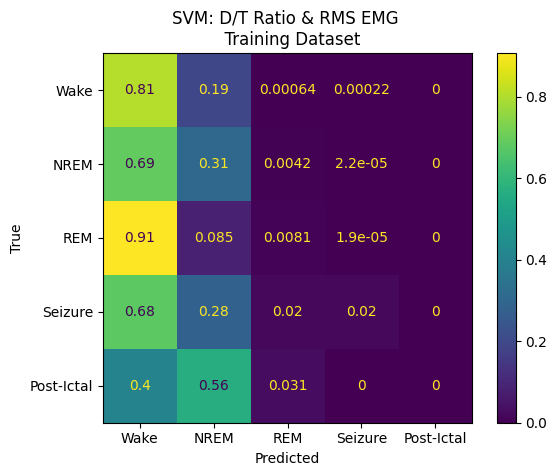

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.55      0.81      0.65    788268
           1       0.55      0.31      0.39    629300
           2       0.21      0.01      0.02    103626
           3       0.03      0.02      0.02       302
           4       0.00      0.00      0.00      1304

    accuracy                           0.55   1522800
   macro avg       0.27      0.23      0.22   1522800
weighted avg       0.52      0.55      0.50   1522800



C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.546477  0.807266  0.651752  7.882680e+05
1              0.545809  0.307122  0.393068  6.293000e+05
2              0.206310  0.008077  0.015546  1.036260e+05
3              0.030612  0.019868  0.024096  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.545349  0.545349  0.545349  5.453487e-01
macro avg      0.265842  0.228467  0.216892  1.522800e+06
weighted avg   0.522482  0.545349  0.500874  1.522800e+06
3
['Wake', 'NREM', 'REM', 'Seizure']


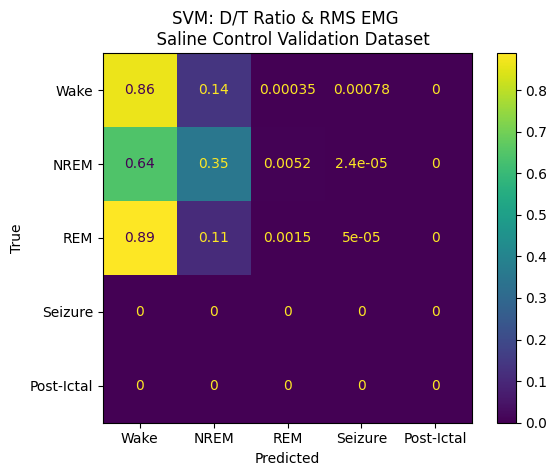

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.54      0.86      0.66    132937
           1       0.68      0.35      0.46    125594
           2       0.04      0.00      0.00     20109
           3       0.00      0.00      0.00         0

    accuracy                           0.57    278640
   macro avg       0.32      0.30      0.28    278640
weighted avg       0.57      0.57      0.52    278640



C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score        support
0              0.536916  0.861355  0.661496  132937.000000
1              0.682581  0.350725  0.463364  125594.000000
2              0.042292  0.001542  0.002975   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.569143  0.569143  0.569143       0.569143
macro avg      0.315447  0.303406  0.281959  278640.000000
weighted avg   0.566877  0.569143  0.524666  278640.000000
4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


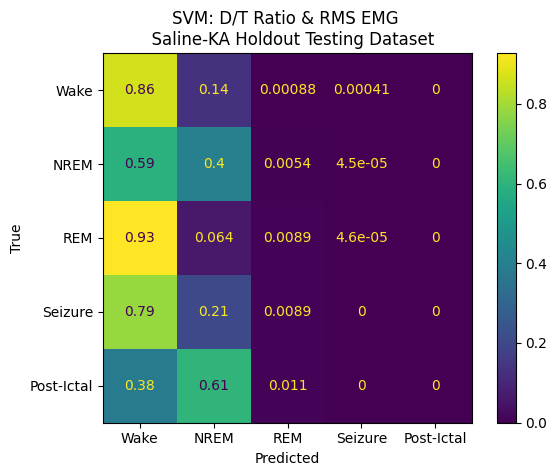

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.65      0.86      0.74    421751
           1       0.64      0.40      0.50    268548
           2       0.18      0.01      0.02     43528
           3       0.00      0.00      0.00       112
           4       0.00      0.00      0.00       461

    accuracy                           0.64    734400
   macro avg       0.29      0.26      0.25    734400
weighted avg       0.62      0.64      0.61    734400



C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.646064  0.862089  0.738605  421751.000000
1              0.641265  0.404092  0.495773  268548.000000
2              0.175169  0.008914  0.016964   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.643373  0.643373  0.643373       0.643373
macro avg      0.292500  0.255019  0.250269  734400.000000
weighted avg   0.615895  0.643373  0.606461  734400.000000



SVM: Statistical Features & RMS EMG
4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


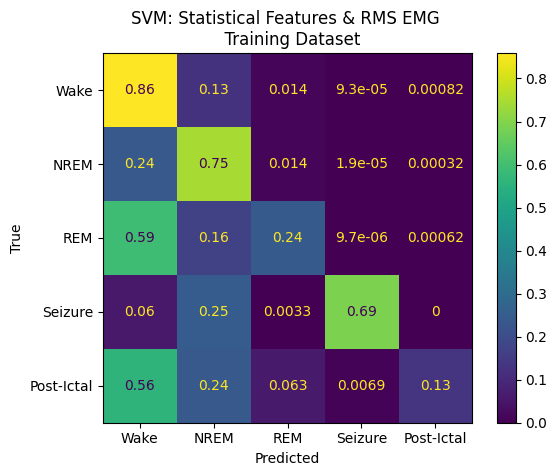

              precision    recall  f1-score   support

           0       0.76      0.86      0.81    788268
           1       0.80      0.75      0.77    629300
           2       0.55      0.24      0.34    103626
           3       0.69      0.69      0.69       302
           4       0.16      0.13      0.14      1304

    accuracy                           0.77   1522800
   macro avg       0.59      0.53      0.55   1522800
weighted avg       0.76      0.77      0.76   1522800

              precision    recall  f1-score       support
0              0.761398  0.858969  0.807246  7.882680e+05
1              0.801550  0.747457  0.773559  6.293000e+05
2              0.554280  0.242265  0.337163  1.036260e+05
3              0.686469  0.688742  0.687603  3.020000e+02
4              0.158861  0.132669  0.144588  1.304000e+03
accuracy       0.770265  0.770265  0.770265  7.702646e-01
macro avg      0.592511  0.534021  0.550032  1.522800e+06
weighted avg   0.763365  0.770265  0.760745  1.

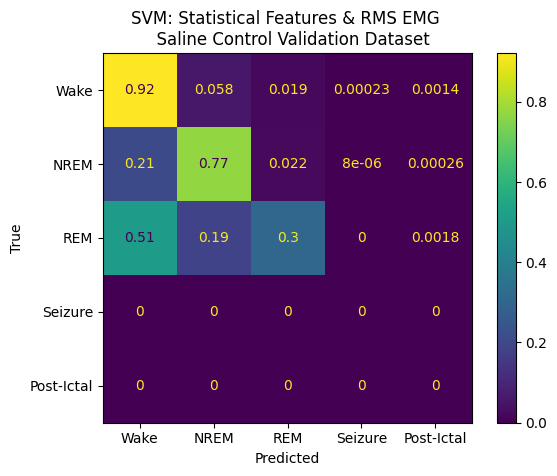

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.77      0.92      0.84    132937
           1       0.89      0.77      0.83    125594
           2       0.54      0.30      0.39     20109
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.81    278640
   macro avg       0.44      0.40      0.41    278640
weighted avg       0.81      0.81      0.80    278640



C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score        support
0              0.772793  0.921339  0.840554  132937.000000
1              0.893915  0.772035  0.828517  125594.000000
2              0.536564  0.303944  0.388063   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.809485  0.809485  0.809485       0.809485
macro avg      0.440655  0.399463  0.411427  278640.000000
weighted avg   0.810339  0.809485  0.802473  278640.000000
4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


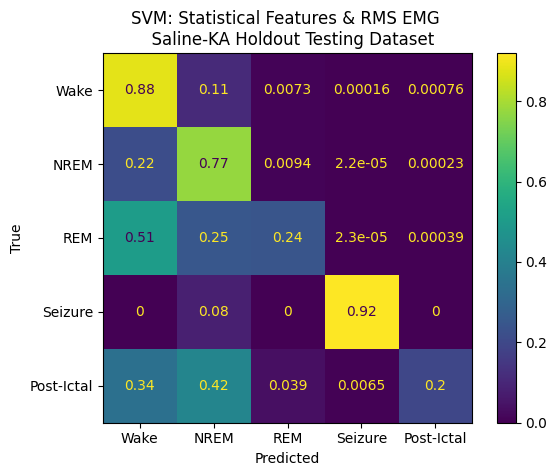

              precision    recall  f1-score   support

           0       0.82      0.88      0.85    421751
           1       0.78      0.77      0.78    268548
           2       0.65      0.24      0.35     43528
           3       0.57      0.92      0.71       112
           4       0.18      0.20      0.19       461

    accuracy                           0.80    734400
   macro avg       0.60      0.60      0.58    734400
weighted avg       0.80      0.80      0.79    734400

              precision    recall  f1-score        support
0              0.822175  0.882625  0.851328  421751.000000
1              0.784377  0.773497  0.778899  268548.000000
2              0.651555  0.241684  0.352582   43528.000000
3              0.572222  0.919643  0.705479     112.000000
4              0.183299  0.195228  0.189076     461.000000
accuracy       0.804306  0.804306  0.804306       0.804306
macro avg      0.602726  0.602535  0.575473  734400.000000
weighted avg   0.797802  0.804306  0.79

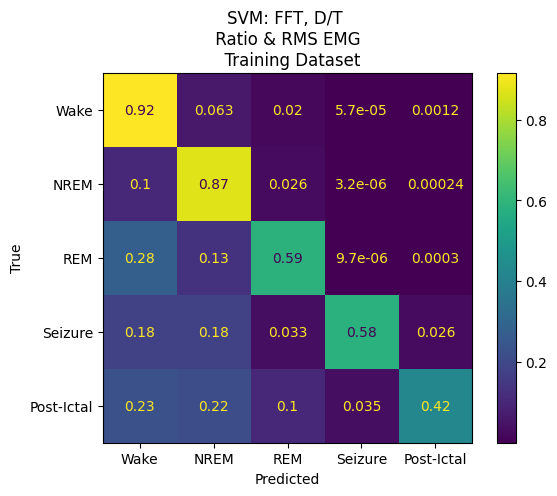

              precision    recall  f1-score   support

           0       0.89      0.92      0.90    788268
           1       0.90      0.87      0.88    629300
           2       0.65      0.59      0.62    103626
           3       0.65      0.58      0.62       302
           4       0.32      0.42      0.37      1304

    accuracy                           0.87   1522800
   macro avg       0.68      0.68      0.68   1522800
weighted avg       0.87      0.87      0.87   1522800

              precision    recall  f1-score       support
0              0.886070  0.915134  0.900368  7.882680e+05
1              0.895077  0.871991  0.883383  6.293000e+05
2              0.652032  0.589186  0.619018  1.036260e+05
3              0.651852  0.582781  0.615385  3.020000e+02
4              0.324308  0.422546  0.366966  1.304000e+03
accuracy       0.874637  0.874637  0.874637  8.746369e-01
macro avg      0.681868  0.676328  0.677024  1.522800e+06
weighted avg   0.873339  0.874637  0.873690  1.

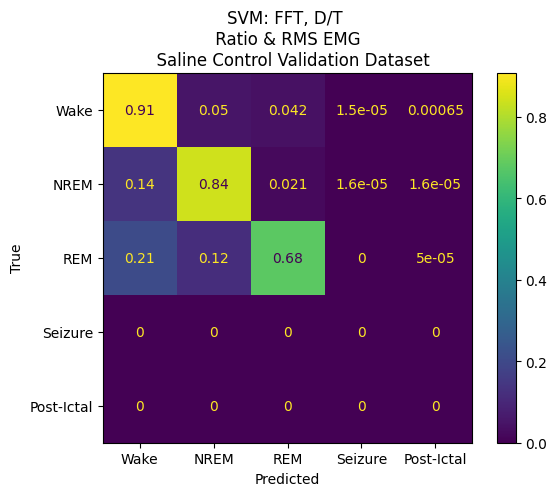

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.85      0.91      0.88    132937
           1       0.92      0.84      0.88    125594
           2       0.62      0.68      0.65     20109
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.86    278640
   macro avg       0.48      0.49      0.48    278640
weighted avg       0.87      0.86      0.86    278640



C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score        support
0              0.849644  0.906994  0.877383  132937.000000
1              0.921130  0.841569  0.879554  125594.000000
2              0.621882  0.676961  0.648254   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.860903  0.860903  0.860903       0.860903
macro avg      0.478531  0.485105  0.481038  278640.000000
weighted avg   0.865428  0.860903  0.861825  278640.000000
4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


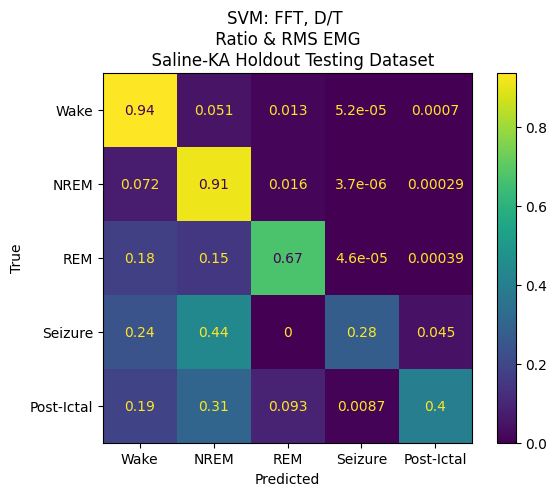

              precision    recall  f1-score   support

           0       0.94      0.94      0.94    421751
           1       0.90      0.91      0.90    268548
           2       0.75      0.67      0.71     43528
           3       0.52      0.28      0.36       112
           4       0.32      0.40      0.36       461

    accuracy                           0.91    734400
   macro avg       0.68      0.64      0.65    734400
weighted avg       0.91      0.91      0.91    734400

              precision    recall  f1-score        support
0              0.935946  0.935955  0.935951  421751.000000
1              0.897017  0.911844  0.904370  268548.000000
2              0.750423  0.672670  0.709423   43528.000000
3              0.516667  0.276786  0.360465     112.000000
4              0.318966  0.401302  0.355427     461.000000
accuracy       0.911097  0.911097  0.911097       0.911097
macro avg      0.683804  0.639711  0.653127  734400.000000
weighted avg   0.910264  0.911097  0.91

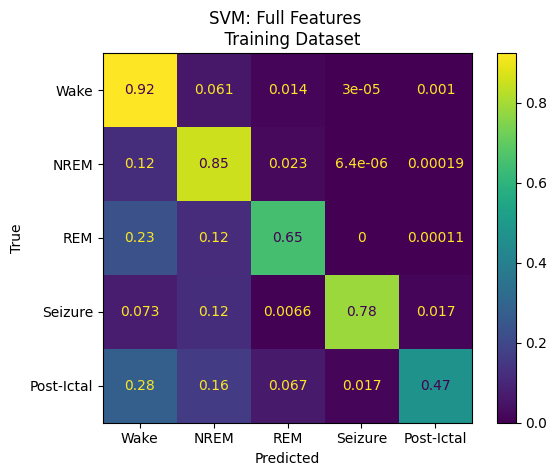

              precision    recall  f1-score   support

           0       0.88      0.92      0.90    788268
           1       0.90      0.85      0.88    629300
           2       0.73      0.65      0.69    103626
           3       0.83      0.78      0.80       302
           4       0.39      0.47      0.43      1304

    accuracy                           0.88   1522800
   macro avg       0.74      0.74      0.74   1522800
weighted avg       0.88      0.88      0.88   1522800

              precision    recall  f1-score       support
0              0.878328  0.924165  0.900664  7.882680e+05
1              0.898686  0.854414  0.875991  6.293000e+05
2              0.725905  0.653185  0.687628  1.036260e+05
3              0.825784  0.784768  0.804754  3.020000e+02
4              0.391944  0.470092  0.427476  1.304000e+03
accuracy       0.876484  0.876484  0.876484  8.764841e-01
macro avg      0.744129  0.737325  0.739303  1.522800e+06
weighted avg   0.875942  0.876484  0.875547  1.

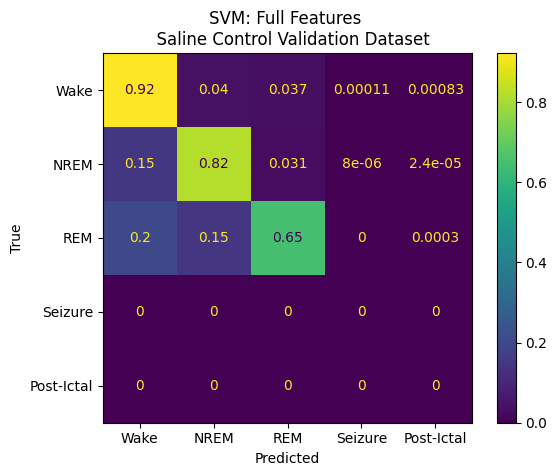

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.84      0.92      0.88    132937
           1       0.93      0.82      0.87    125594
           2       0.60      0.65      0.62     20109
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.86    278640
   macro avg       0.47      0.48      0.47    278640
weighted avg       0.86      0.86      0.86    278640



C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score       support
0              0.842198  0.921903  0.880250  132937.00000
1              0.925173  0.818678  0.868674  125594.00000
2              0.597666  0.649411  0.622465   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.855710  0.855710  0.855710       0.85571
macro avg      0.473008  0.477998  0.474278  278640.00000
weighted avg   0.861951  0.855710  0.856428  278640.00000
4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


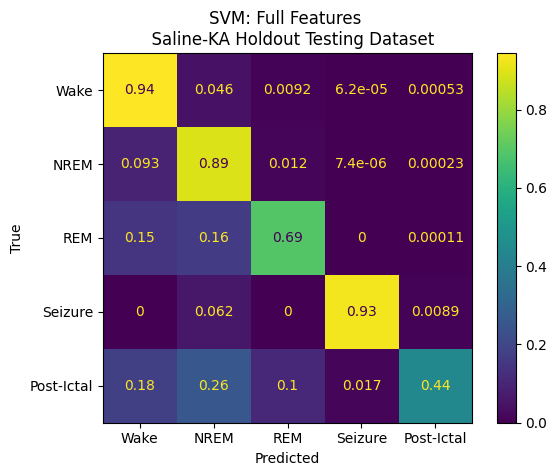

              precision    recall  f1-score   support

           0       0.93      0.94      0.94    421751
           1       0.90      0.89      0.90    268548
           2       0.81      0.69      0.74     43528
           3       0.74      0.93      0.83       112
           4       0.41      0.44      0.43       461

    accuracy                           0.91    734400
   macro avg       0.76      0.78      0.77    734400
weighted avg       0.91      0.91      0.91    734400

              precision    recall  f1-score        support
0              0.926902  0.944036  0.935390  421751.000000
1              0.900045  0.894626  0.897327  268548.000000
2              0.806528  0.690889  0.744243   43528.000000
3              0.742857  0.928571  0.825397     112.000000
4              0.412121  0.442516  0.426778     461.000000
accuracy       0.910647  0.910647  0.910647       0.910647
macro avg      0.757691  0.780128  0.765827  734400.000000
weighted avg   0.909596  0.910647  0.90

In [45]:
mu=.15
class_weight=norm_sklearn_classweight(y_train, mu=None)

savepath=f'{data_path}Results_GPU/CM_SVM/'

if os.path.exists(savepath)==0:
  os.mkdir(savepath)

masklist=[[mask_DTRMS,'SVM: D/T Ratio & RMS EMG', 'DTRMS'],
              [mask_StatRMS,'SVM: Statistical Features & RMS EMG','StatRMS'],
              [mask_FFTRMS, 'SVM: FFT, D/T \n Ratio & RMS EMG', 'FFT'],
               [mask_FullFeats, 'SVM: Full Features', 'FullFeats']]

results=np.zeros((len(masklist),5,3))
feature_set_count=0
for masks in masklist:

  print(f'\n{masks[1]}')
  X_train_masked=X_train[:,masks[0]]
  X_val_masked=X_val[:,masks[0]]
  X_test_masked=X_test[:,masks[0]]

  svm_model = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, 
                                                      fit_intercept=True, max_iter=1000, tol=0.001, shuffle=False, verbose=0, epsilon=0.1, n_jobs=None, 
                                                      random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, 
                                                      n_iter_no_change=5, class_weight=class_weight, warm_start=False, average=False)

  svm_model.fit(X_train_masked, np.argmax(y_train,1))

  
  for x, y, name in [[X_train_masked, y_train, ' Training Dataset'], [X_val_masked, y_val, ' Saline Control Validation Dataset'], [X_test_masked, y_test, ' Saline-KA Holdout Testing Dataset']]:
    y_pred=svm_model.predict(x)
    
    print_conf_mat(np.argmax(y,1), y_pred, masks[1]+' \n '+name, output_name=savepath+masks[2]+name)

    y_pred_codes=y_pred
    y_test_codes=np.argmax(y,1)

    print(classification_report(y_test_codes, y_pred_codes))

    dict1 = classification_report(y_test_codes, y_pred_codes, output_dict=True)
    df = pd.DataFrame(data=dict1)
    df = (df.T)
    print (df)

    df.to_excel(f'{savepath+masks[2]+name}.xlsx')


  for state_count in range(0,5):
    
    discriminant=np.argmax(y_train,1)==state_count
    if True in discriminant:
      results[feature_set_count,state_count,0] = svm_model.score(X_train_masked[discriminant], np.argmax(y_train,1)[discriminant])
    
    discriminant=np.argmax(y_val,1)==state_count
    if True in discriminant:
      results[feature_set_count,state_count,1] = svm_model.score(X_val_masked[discriminant], np.argmax(y_val,1)[discriminant])

    discriminant=np.argmax(y_test,1)==state_count
    if True in discriminant:
      results[feature_set_count,state_count,2] = svm_model.score(X_test_masked[discriminant], np.argmax(y_test,1)[discriminant])

  
  print("\n")
  feature_set_count+=1


4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


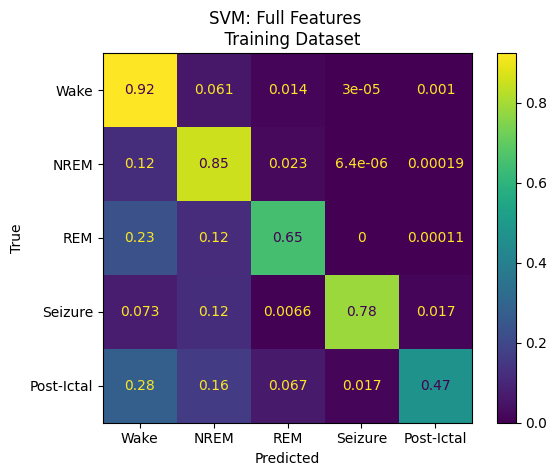

              precision    recall  f1-score   support

           0       0.88      0.92      0.90    788268
           1       0.90      0.85      0.88    629300
           2       0.73      0.65      0.69    103626
           3       0.83      0.78      0.80       302
           4       0.39      0.47      0.43      1304

    accuracy                           0.88   1522800
   macro avg       0.74      0.74      0.74   1522800
weighted avg       0.88      0.88      0.88   1522800

              precision    recall  f1-score       support
0              0.878328  0.924165  0.900664  7.882680e+05
1              0.898686  0.854414  0.875991  6.293000e+05
2              0.725905  0.653185  0.687628  1.036260e+05
3              0.825784  0.784768  0.804754  3.020000e+02
4              0.391944  0.470092  0.427476  1.304000e+03
accuracy       0.876484  0.876484  0.876484  8.764841e-01
macro avg      0.744129  0.737325  0.739303  1.522800e+06
weighted avg   0.875942  0.876484  0.875547  1.

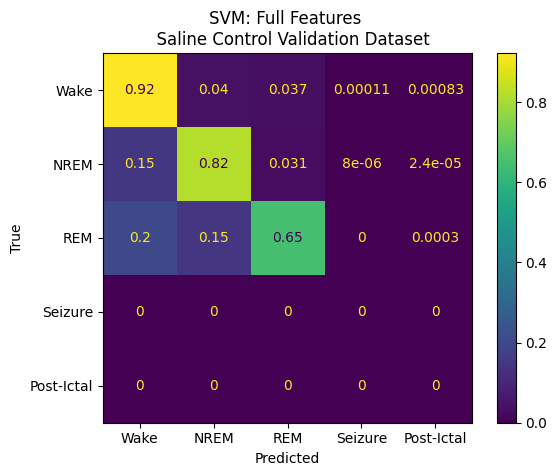

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.84      0.92      0.88    132937
           1       0.93      0.82      0.87    125594
           2       0.60      0.65      0.62     20109
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.86    278640
   macro avg       0.47      0.48      0.47    278640
weighted avg       0.86      0.86      0.86    278640



C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score       support
0              0.842198  0.921903  0.880250  132937.00000
1              0.925173  0.818678  0.868674  125594.00000
2              0.597666  0.649411  0.622465   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.855710  0.855710  0.855710       0.85571
macro avg      0.473008  0.477998  0.474278  278640.00000
weighted avg   0.861951  0.855710  0.856428  278640.00000
4
['Wake', 'NREM', 'REM', 'Seizure', 'Post-Ictal']


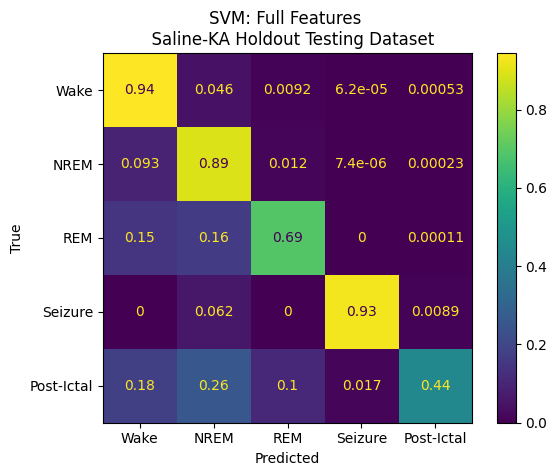

              precision    recall  f1-score   support

           0       0.93      0.94      0.94    421751
           1       0.90      0.89      0.90    268548
           2       0.81      0.69      0.74     43528
           3       0.74      0.93      0.83       112
           4       0.41      0.44      0.43       461

    accuracy                           0.91    734400
   macro avg       0.76      0.78      0.77    734400
weighted avg       0.91      0.91      0.91    734400

              precision    recall  f1-score        support
0              0.926902  0.944036  0.935390  421751.000000
1              0.900045  0.894626  0.897327  268548.000000
2              0.806528  0.690889  0.744243   43528.000000
3              0.742857  0.928571  0.825397     112.000000
4              0.412121  0.442516  0.426778     461.000000
accuracy       0.910647  0.910647  0.910647       0.910647
macro avg      0.757691  0.780128  0.765827  734400.000000
weighted avg   0.909596  0.910647  0.90

In [46]:
for x, y, name in [[X_train_masked, y_train, ' Training Dataset'], [X_val_masked, y_val, ' Saline Control Validation Dataset'], [X_test_masked, y_test, ' Saline-KA Holdout Testing Dataset']]:
    y_pred=svm_model.predict(x)
    
    print_conf_mat(np.argmax(y,1), y_pred, masks[1]+' \n '+name, output_name=savepath+masks[2])

    y_pred_codes=y_pred
    y_test_codes=np.argmax(y,1)

    print(classification_report(y_test_codes, y_pred_codes))

    dict1 = classification_report(y_test_codes, y_pred_codes, output_dict=True)
    df = pd.DataFrame(data=dict1)
    df = (df.T)
    print (df)

    df.to_excel(f'{savepath+masks[2]+name}.xlsx')

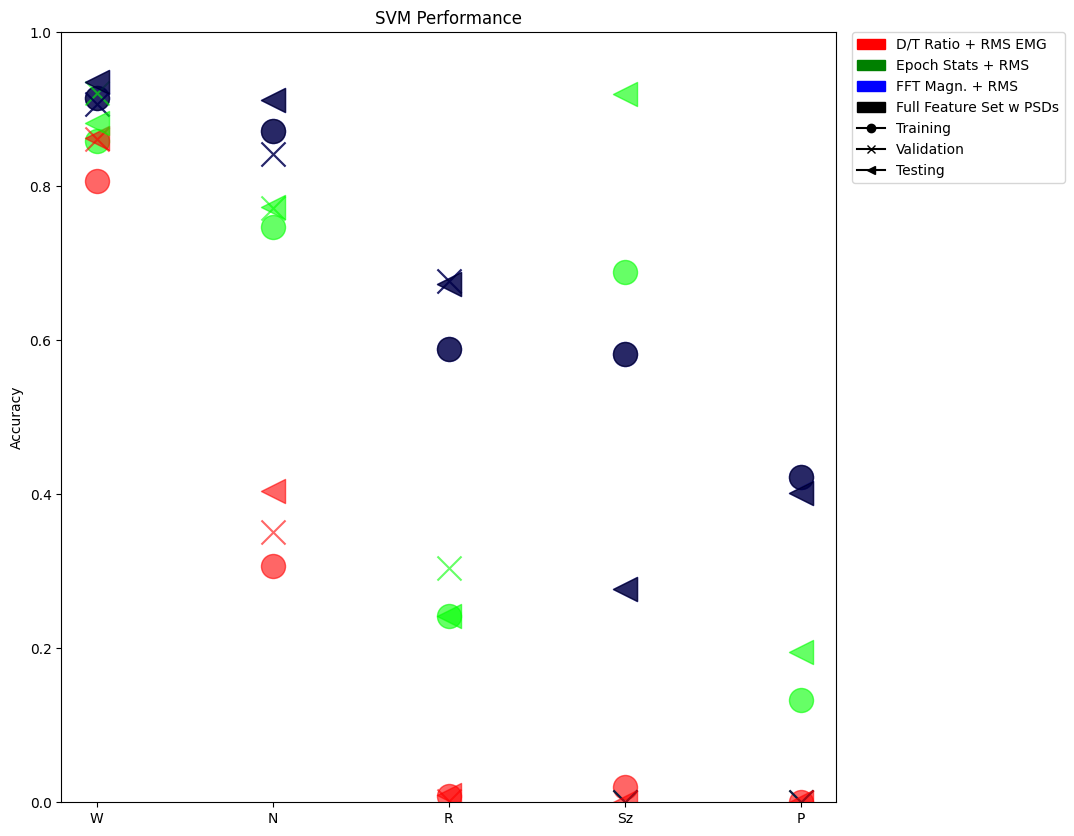

In [47]:
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize']=[10,10]

red_patch = mpatches.Patch(color='r', label='D/T Ratio + RMS EMG')
green_patch = mpatches.Patch(color='g', label='Epoch Stats + RMS')
blue_patch = mpatches.Patch(color='b', label='FFT Magn. + RMS')
black_patch = mpatches.Patch(color='k', label='Full Feature Set w PSDs')

for i in range(3): 
  shape_patch_1=matplotlib.lines.Line2D([],[],color=(0,0,0),marker='o', label='Training')
  shape_patch_2=matplotlib.lines.Line2D([],[],color=(0,0,0),marker='x', label='Validation')
  shape_patch_3=matplotlib.lines.Line2D([],[],color=(0,0,0),marker='<', label='Testing')


for i in range(3):
  marker=['o','x','<'][i]
  for c in range(0,5):
    plt.scatter(['W','N','R','Sz','P'][c],results[0,c,i].T, marker=marker, color=(1,0,0), s=300, alpha=.6)
    plt.scatter(['W','N','R','Sz','P'][c],results[1,c,i].T, marker=marker, color=(0,1,0), s=300, alpha=.6)
    plt.scatter(['W','N','R','Sz','P'][c],results[2,c,i].T, marker=marker, color=(0,0,1), s=300, alpha=.6)
    plt.scatter(['W','N','R','Sz','P'][c],results[2,c,i].T, marker=marker, color=(0,0,0), s=300, alpha=.6)


plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.title('SVM Performance')
plt.legend(handles=[red_patch, green_patch, blue_patch, black_patch, shape_patch_1, shape_patch_2, shape_patch_3], bbox_to_anchor=(1.02, 1),
                  loc='upper left', borderaxespad=0.)
plt.savefig(f'{savepath}SVM Performance.png')
    

#  Grid Search Block

## Full Deep Learning Grid Search

In [48]:
Channel_Masks=[[mask_ECoG, 'ECoG_only'],
               [np.concatenate((mask_HPCL,mask_HPCR)), '2xHPC'],
               [np.concatenate((mask_EMG,mask_HPCL,mask_HPCR,mask_RMS)), 'no_ECoG'],
               [np.concatenate((mask_EMG,mask_RMS)), 'EMG_RMS_only' ],
               [np.concatenate((mask_ECoG,mask_EMG,mask_RMS)), 'noHPC']]

Feature_Masks = [[mask_FullFeats, 'FullFeats'],
                 [mask_FFTRMS, 'FFT + RMS'],
                 [mask_StatRMS, 'StatRMS'],
                 [mask_DTRMS,'DTR+RMS only']]

# Generate training variables which are common between models
batch_size, metrics, optimizer, activity_regularizer = common_training_parameters()

# Number of epochs to train 
epochs=20

for window_length in [3,2,1,0]:
  # Test all four windowing variants 
  # Grid Search Iteration Count in This Loop: 4 Combinations
  for masks in Feature_Masks:
    # Test all four Feature Vectors 
    # Grid Search Iteration Count in This Loop: 16 Combinations
      
    X_train_masked=X_train[:,masks[0]]
    X_val_masked=X_val[:,masks[0]]
    X_test_masked=X_test[:,masks[0]]

    # Mask name for training logs
    submodel=masks[1]
    print(submodel)  

    # Maximum number of features determined by last dimension in shape of masked array
    max_feats=X_train_masked.shape[1]

    # Generate windowed sequences from full epoch arrays
      
    # Number of time points on either side of scored epoch to use for input variables...
    # determined by window length.  i.e. window_length 3 leads to an input 7 epochs long
    X_train_seq=generate_sequences(X_train_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
    X_val_seq=generate_sequences(X_val_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
    X_test_seq=generate_sequences(X_test_masked, windows=window_length, x_or_y='X', max_feats=max_feats)

    y_train_seq=generate_sequences(y_train, windows=window_length, x_or_y='Y', max_feats=max_feats)
    y_val_seq=generate_sequences(y_val, windows=window_length, x_or_y='Y', max_feats=max_feats)
    y_test_seq=generate_sequences(y_test, windows=window_length, x_or_y='Y', max_feats=max_feats)
      
    # Generate class weight array based on logarithmic modification of sk-learn class weighting
    class_weight=norm_sklearn_classweight(y_train_seq, mu=False)
    print(class_weight)

    print(X_train_seq.shape)

    for neuron_num in [200,100,50]:
        # Test Three Initial-Layer Neuron Counts
        # Grid Search Iteration Count in This Loop: 48 Combinations

        
        # Test All Above Over 4 Types of Models: 192 Total Model Variants
        # Dense Neural Net Model Training
        savepath='./Results_GPU/Dense/'

        model, model_history, logpath, csvpath, model_name = create_train_Dense_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                              epochs=epochs, steps_per_epoch=None, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path, savepath=savepath)
        gc.collect()
        # Dense Neural Net Model Report
        save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                            model_name=model_name+f'_{submodel}_win{window_length}', 
                            model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
        gc.collect()
        
        # LSTM Model Training
        savepath='./Results_GPU/LSTM/'

        model, model_history, logpath, csvpath, model_name = create_train_LSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                              epochs=epochs, steps_per_epoch=None, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path, savepath=savepath)
        gc.collect()
        # LSTM Model Report
        save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                            model_name=model_name+f'_{submodel}_win{window_length}_', 
                            model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
        gc.collect()
        
        # BiLSTM Model Training
        savepath='./Results_GPU/BiLSTM/'
        model, model_history, logpath, csvpath, model_name = create_train_BiLSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                              epochs=epochs, steps_per_epoch=None, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path, savepath=savepath)
        gc.collect()
        # BiLSTM Model Report
        save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                            model_name=model_name+f'single-layer_{submodel}_win{window_length}_', 
                            model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
      

        # Stacked BiLSTM Model Training
        savepath='./Results_GPU/Quad_BiLSTM/'

        model, model_history, logpath, csvpath, model_name = create_train_BiLSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                              epochs=epochs, steps_per_epoch=None, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=4, data_path=data_path, savepath=savepath)
        gc.collect()
        # Stacked BiLSTM Model Report
        save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                            model_name=model_name+f'quad-layer_{submodel}_win{window_length}_', 
                            model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)

FullFeats
[3.86366006e-01 4.83966712e-01 2.93901917e+00 1.00847285e+03
 2.33557362e+02]
{0: 0.9999999999999998, 1: 1.2252310044199577, 2: 3.0290460641499926, 3: 8.867162589347098, 4: 7.404397864235369}
(1522794, 7, 100)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7, 200)            20200     
                                                                 
 flatten (Flatten)           (None, 1400)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 7005      
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                                 
Total params: 27,205
Trainable params: 27,205
Non-trainable params: 0
______________________________

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 24s - loss: 1.2090 - accuracy: 0.6745 - tp: 815541.0000 - fp: 180120.0000 - tn: 5911056.0000 - fn: 707253.0000 - categorical_accuracy: 0.6745 - precision: 0.8191 - recall: 0.5356 - auc: 0.7560 - categorical_crossentropy: 0.9382 - val_loss: 0.5307 - val_accuracy: 0.8581 - val_tp: 215823.0000 - val_fp: 17437.0000 - val_tn: 1097099.0000 - val_fn: 62811.0000 - val_categorical_accuracy: 0.8581 - val_precision: 0.9252 - val_recall: 0.7746 - val_auc: 0.9201 - val_categorical_crossentropy: 0.5307 - 24s/epoch - 34ms/step
Epoch 2/20
705/705 - 17s - loss: 0.6881 - accuracy: 0.8455 - tp: 1190066.0000 - fp: 115763.0000 - tn: 5975413.0000 - fn: 332728.0000 - categorical_accuracy: 0.8455 - precision: 0.9113 - recall: 0.7815 - auc: 0.9124 - categorical_crossentropy: 0.5549 - val_loss: 0.3987 - val_accuracy: 0.8990 - val_tp: 238393.0000 - val_fp: 16361.0000 - val_tn: 1098175.0000 - val_fn: 40241.0000 - val_categorical_accuracy: 0.8990 - val_precision: 0.9358 - val_recall: 0.8556 - 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.954260  0.964087  0.959149  132934.000000
1              0.959557  0.929462  0.944269  125591.000000
2              0.780797  0.878761  0.826888   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.942322  0.942322  0.942322       0.942322
macro avg      0.538923  0.554462  0.546061  278634.000000
weighted avg   0.944129  0.942322  0.942897  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 9s 13ms/step
              precision    recall  f1-score       support
0              0.964738  0.945374  0.954958  7.882650e+05
1              0.933036  0.940233  0.936621  6.292970e+05
2              0.808964  0.891292  0.848135  1.036260e+05
3              0.770774  0.890728  0.826421  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.952695  0.963681  0.958156  132934.000000
1              0.959423  0.927973  0.943436  125591.000000
2              0.777272  0.874832  0.823172   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.941174  0.941174  0.941174       0.941174
macro avg      0.537878  0.553297  0.544953  278634.000000
weighted avg   0.943067  0.941174  0.941780  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 9s 12ms/step
              precision    recall  f1-score       support
0              0.962152  0.944503  0.953246  7.882650e+05
1              0.932695  0.936656  0.934671  6.292970e+05
2              0.799107  0.886486  0.840532  1.036260e+05
3              0.751445  0.860927  0.802469  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.949628  0.960522  0.955044  132934.000000
1              0.961411  0.919071  0.939764  125591.000000
2              0.736704  0.880352  0.802148   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.936052  0.936052  0.936052       0.936052
macro avg      0.529549  0.551989  0.539391  278634.000000
weighted avg   0.939572  0.936052  0.937122  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 9s 13ms/step
              precision    recall  f1-score       support
0              0.957833  0.942424  0.950066  7.882650e+05
1              0.932463  0.929062  0.930759  6.292970e+05
2              0.769882  0.877000  0.819958  1.036260e+05
3              0.583732  0.807947  0.677778  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 15s - loss: 0.9055 - accuracy: 0.7861 - tp: 1258604.0000 - fp: 113935.0000 - tn: 7091777.0000 - fn: 542824.0000 - categorical_accuracy: 0.8101 - precision: 0.9170 - recall: 0.6987 - auc: 0.8883 - categorical_crossentropy: 0.6356 - val_loss: 0.4297 - val_accuracy: 0.8980 - val_tp: 234403.0000 - val_fp: 14947.0000 - val_tn: 1099589.0000 - val_fn: 44231.0000 - val_categorical_accuracy: 0.8980 - val_precision: 0.9401 - val_recall: 0.8413 - val_auc: 0.9483 - val_categorical_crossentropy: 0.4297 - 15s/epoch - 22ms/step
Epoch 2/20
705/705 - 12s - loss: 0.5948 - accuracy: 0.8780 - tp: 1251070.0000 - fp: 98160.0000 - tn: 5993016.0000 - fn: 271724.0000 - categorical_accuracy: 0.8780 - precision: 0.9272 - recall: 0.8216 - auc: 0.9340 - categorical_crossentropy: 0.4775 - val_loss: 0.3604 - val_accuracy: 0.9111 - val_tp: 243684.0000 - val_fp: 15354.0000 - val_tn: 1099182.0000 - val_fn: 34950.0000 - val_categorical_accuracy: 0.9111 - val_precision: 0.9407 - val_recall: 0.8746 - 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.951568  0.958769  0.955155  132934.000000
1              0.956389  0.928418  0.942196  125591.000000
2              0.760624  0.860709  0.807577   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.938012  0.938012  0.938012       0.938012
macro avg      0.667145  0.686974  0.676232  278634.000000
weighted avg   0.939960  0.938012  0.938663  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.960925  0.937680  0.949160  7.882650e+05
1              0.925724  0.935371  0.930522  6.292970e+05
2              0.770055  0.860402  0.812725  1.036260e+05
3              0.758007  0.705298  0.730703  3.020000e+02
4              0.502384  0.646472  0.565392  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.968999  0.965464  0.967228  132934.000000
1              0.959061  0.945147  0.952053  125591.000000
2              0.783439  0.873241  0.825906   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.949651  0.949651  0.949651       0.949651
macro avg      0.542300  0.556770  0.549038  278634.000000
weighted avg   0.951128  0.949651  0.950189  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 7s 10ms/step
              precision    recall  f1-score       support
0              0.977434  0.958977  0.968118  7.882650e+05
1              0.947745  0.953141  0.950436  6.292970e+05
2              0.815599  0.901955  0.856606  1.036260e+05
3              0.583979  0.748344  0.656023  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.950254  0.959311  0.954761  132934.000000
1              0.957561  0.925958  0.941495  125591.000000
2              0.754462  0.861952  0.804633   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.937251  0.937251  0.937251       0.937251
macro avg      0.665569  0.686805  0.675222  278634.000000
weighted avg   0.939417  0.937251  0.937946  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.959725  0.937950  0.948713  7.882650e+05
1              0.925865  0.933759  0.929795  6.292970e+05
2              0.766360  0.857391  0.809324  1.036260e+05
3              0.704545  0.615894  0.657244  3.020000e+02
4              0.483892  0.575920  0.525910  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.964515  0.961199  0.962854  132934.000000
1              0.956791  0.937273  0.946931  125591.000000
2              0.759156  0.873092  0.812147   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.944056  0.944056  0.944056       0.944056
macro avg      0.670115  0.692891  0.680483  278634.000000
weighted avg   0.946212  0.944056  0.944800  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 8ms/step
              precision    recall  f1-score       support
0              0.973079  0.949523  0.961157  7.882650e+05
1              0.936840  0.946655  0.941722  6.292970e+05
2              0.793064  0.885560  0.836763  1.036260e+05
3              0.549784  0.420530  0.476548  3.020000e+02
4              0.588864  0.802914  0.679429  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.982052  0.955130  0.968404  421748.000000
1              0.931895  0.950995  0.941348  268545.000000
2              0.769060  0.873001  0.817741   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.419786  0.681128  0.519438     461.000000
accuracy       0.948432  0.948432  0.948432       0.948432
macro avg      0.620559  0.692051  0.649386  734394.000000
weighted avg   0.950584  0.948432  0.949151  734394.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 18ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.970177  0.955865  0.962968  132934.000000
1              0.951510  0.942146  0.946805  125591.000000
2              0.756233  0.876423  0.811904   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.943948  0.943948  0.943948       0.943948
macro avg      0.669480  0.693609  0.680419  278634.000000
weighted avg   0.946323  0.943948  0.944780  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 14s 20ms/step
              precision    recall  f1-score       support
0              0.977576  0.946057  0.961559  7.882650e+05
1              0.935169  0.947853  0.941468  6.292970e+05
2              0.773056  0.895557  0.829810  1.036260e+05
3              0.250000  0.003311  0.006536  3.020000e+02
4              0.575449  0.909509  0.704903  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.947424  0.958513  0.952936  132934.000000
1              0.959791  0.918768  0.938832  125591.000000
2              0.731410  0.868716  0.794172   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.934118  0.934118  0.934118       0.934118
macro avg      0.527725  0.549199  0.537188  278634.000000
weighted avg   0.937409  0.934118  0.935121  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.955362  0.937702  0.946450  7.882650e+05
1              0.928060  0.926040  0.927049  6.292970e+05
2              0.738822  0.852006  0.791388  1.036260e+05
3              0.639344  0.387417  0.482474  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.961476  0.954872  0.958163  132934.00000
1              0.952825  0.933244  0.942933  125591.00000
2              0.743156  0.872097  0.802480   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.939150  0.939150  0.939150       0.93915
macro avg      0.531491  0.552043  0.540715  278634.00000
weighted avg   0.941820  0.939150  0.940062  278634.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.968345  0.939812  0.953865  7.882650e+05
1              0.926944  0.940318  0.933583  6.292970e+05
2              0.764304  0.866626  0.812256  1.036260e+05
3              0.250000  0.069536  0.108808  3.020000e+02
4              0.491

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.966153  0.958130  0.962125  132934.000000
1              0.953900  0.940601  0.947204  125591.000000
2              0.764088  0.872495  0.814701   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.944048  0.944048  0.944048       0.944048
macro avg      0.671036  0.692806  0.681007  278634.000000
weighted avg   0.946047  0.944048  0.944760  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 7s 9ms/step
              precision    recall  f1-score       support
0              0.971708  0.946485  0.958930  7.882650e+05
1              0.934327  0.945612  0.939936  6.292970e+05
2              0.781962  0.877087  0.826797  1.036260e+05
3              0.581731  0.400662  0.474510  3.020000e+02
4              0.578692  0.733129  0.646820  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.968577  0.946041  0.957176  132934.00000
1              0.945541  0.935505  0.940496  125591.00000
2              0.719912  0.878114  0.791182   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.936390  0.936390  0.936390       0.93639
macro avg      0.526806  0.551932  0.537771  278634.00000
weighted avg   0.940248  0.936390  0.937678  278634.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 14s 19ms/step
              precision    recall  f1-score       support
0              0.974451  0.936707  0.955206  7.882650e+05
1              0.925638  0.941586  0.933544  6.292970e+05
2              0.736950  0.877675  0.801180  1.036260e+05
3              0.112867  0.165563  0.134228  3.020000e+02
4              0.5

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 15s - loss: 1.1332 - accuracy: 0.7151 - tp: 1074544.0000 - fp: 136018.0000 - tn: 7069694.0000 - fn: 726884.0000 - categorical_accuracy: 0.7493 - precision: 0.8876 - recall: 0.5965 - auc: 0.8280 - categorical_crossentropy: 0.8046 - val_loss: 0.6180 - val_accuracy: 0.8544 - val_tp: 202457.0000 - val_fp: 16115.0000 - val_tn: 1098421.0000 - val_fn: 76177.0000 - val_categorical_accuracy: 0.8544 - val_precision: 0.9263 - val_recall: 0.7266 - val_auc: 0.9071 - val_categorical_crossentropy: 0.6180 - 15s/epoch - 22ms/step
Epoch 2/20
705/705 - 12s - loss: 0.8299 - accuracy: 0.8176 - tp: 1103539.0000 - fp: 132100.0000 - tn: 5959076.0000 - fn: 419255.0000 - categorical_accuracy: 0.8176 - precision: 0.8931 - recall: 0.7247 - auc: 0.8800 - categorical_crossentropy: 0.6697 - val_loss: 0.5203 - val_accuracy: 0.8743 - val_tp: 219626.0000 - val_fp: 17461.0000 - val_tn: 1097075.0000 - val_fn: 59008.0000 - val_categorical_accuracy: 0.8743 - val_precision: 0.9264 - val_recall: 0.7882 -

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.929024  0.934027  0.931519  132934.000000
1              0.933708  0.907724  0.920533  125591.000000
2              0.667611  0.750311  0.706549   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.908913  0.908913  0.908913       0.908913
macro avg      0.506068  0.518412  0.511720  278634.000000
weighted avg   0.912269  0.908913  0.910331  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.932307  0.902285  0.917050  7.882650e+05
1              0.881943  0.887811  0.884868  6.292970e+05
2              0.648799  0.780962  0.708773  1.036260e+05
3              0.600998  0.798013  0.685633  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.959046  0.928536  0.943544  132934.000000
1              0.931073  0.927129  0.929096  125591.000000
2              0.696288  0.859963  0.769518   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.922953  0.922953  0.922953       0.922953
macro avg      0.517281  0.543126  0.528432  278634.000000
weighted avg   0.927474  0.922953  0.924473  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 8ms/step
              precision    recall  f1-score       support
0              0.956107  0.933208  0.944518  7.882650e+05
1              0.916671  0.918598  0.917633  6.292970e+05
2              0.717204  0.836392  0.772227  1.036260e+05
3              0.601415  0.844371  0.702479  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.961837  0.931289  0.946317  132934.000000
1              0.933097  0.929493  0.931292  125591.000000
2              0.694279  0.855687  0.766578   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.925024  0.925024  0.925024       0.925024
macro avg      0.647303  0.679117  0.661047  278634.000000
weighted avg   0.929573  0.925024  0.926573  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 7s 9ms/step
              precision    recall  f1-score       support
0              0.959483  0.938122  0.948683  7.882650e+05
1              0.922888  0.923775  0.923331  6.292970e+05
2              0.725759  0.841845  0.779504  1.036260e+05
3              0.673469  0.874172  0.760807  3.020000e+02
4              0.668351  0.811350  0.732941  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.966719  0.922548  0.944117  132934.000000
1              0.926113  0.928960  0.927535  125591.000000
2              0.675372  0.865533  0.758718   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.921323  0.921323  0.921323       0.921323
macro avg      0.642051  0.679260  0.657593  278634.000000
weighted avg   0.927390  0.921323  0.923263  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 14s 20ms/step
              precision    recall  f1-score       support
0              0.964936  0.931084  0.947708  7.882650e+05
1              0.917319  0.924390  0.920841  6.292970e+05
2              0.703719  0.855191  0.772096  1.036260e+05
3              0.621118  0.331126  0.431965  3.020000e+02
4              0.595986  0.888037  0.713274  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.924641  0.935833  0.930203  132934.000000
1              0.935978  0.904707  0.920076  125591.000000
2              0.666682  0.742205  0.702419   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.907829  0.907829  0.907829       0.907829
macro avg      0.505460  0.516549  0.510540  278634.000000
weighted avg   0.911134  0.907829  0.909200  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.929418  0.899497  0.914213  7.882650e+05
1              0.879290  0.885777  0.882522  6.292970e+05
2              0.645152  0.774748  0.704036  1.036260e+05
3              0.509217  0.731788  0.600543  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.948190  0.934659  0.941376  132934.000000
1              0.935555  0.920440  0.927936  125591.000000
2              0.695183  0.830424  0.756809   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.920728  0.920728  0.920728       0.920728
macro avg      0.515786  0.537105  0.525224  278634.000000
weighted avg   0.924235  0.920728  0.921998  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.950912  0.926431  0.938512  7.882650e+05
1              0.908420  0.913276  0.910842  6.292970e+05
2              0.701161  0.816465  0.754433  1.036260e+05
3              0.701705  0.817881  0.755352  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.956176  0.932922  0.944406  132934.000000
1              0.934387  0.924811  0.929574  125591.000000
2              0.693643  0.848625  0.763347   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.923182  0.923182  0.923182       0.923182
macro avg      0.516841  0.541272  0.527465  278634.000000
weighted avg   0.927408  0.923182  0.924654  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.955094  0.931605  0.943204  7.882650e+05
1              0.915191  0.918892  0.917038  6.292970e+05
2              0.714420  0.828933  0.767428  1.036260e+05
3              0.573086  0.817881  0.673943  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.960346  0.921104  0.940315  132934.000000
1              0.925058  0.922701  0.923878  125591.000000
2              0.663263  0.852752  0.746165   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.916891  0.916891  0.916891       0.916891
macro avg      0.509733  0.539312  0.522072  278634.000000
weighted avg   0.923000  0.916891  0.918895  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 14s 20ms/step
              precision    recall  f1-score       support
0              0.960801  0.923649  0.941859  7.882650e+05
1              0.908375  0.919111  0.913712  6.292970e+05
2              0.683468  0.833517  0.751072  1.036260e+05
3              0.291429  0.168874  0.213836  3.020000e+02
4        

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.915588  0.937683  0.926504  132934.000000
1              0.940113  0.896450  0.917762  125591.000000
2              0.658690  0.730917  0.692926   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.904175  0.904175  0.904175       0.904175
macro avg      0.502878  0.513010  0.507438  278634.000000
weighted avg   0.908102  0.904175  0.905706  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.923120  0.899756  0.911288  7.882650e+05
1              0.879983  0.877567  0.878773  6.292970e+05
2              0.633379  0.765609  0.693245  1.036260e+05
3              0.325455  0.592715  0.420188  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.932924  0.935043  0.933982  132934.000000
1              0.938623  0.913855  0.926074  125591.000000
2              0.682821  0.784723  0.730234   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.914644  0.914644  0.914644       0.914644
macro avg      0.510874  0.526724  0.518058  278634.000000
weighted avg   0.917443  0.914644  0.915713  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.939494  0.913656  0.926395  7.882650e+05
1              0.894524  0.900583  0.897543  6.292970e+05
2              0.670366  0.785652  0.723445  1.036260e+05
3              0.646259  0.629139  0.637584  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.944020  0.933275  0.938617  132934.000000
1              0.937751  0.916770  0.927142  125591.000000
2              0.674568  0.819384  0.739957   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.917616  0.917616  0.917616       0.917616
macro avg      0.639085  0.667357  0.651429  278634.000000
weighted avg   0.921748  0.917616  0.919107  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 8s 11ms/step
              precision    recall  f1-score       support
0              0.946743  0.919911  0.933134  7.882650e+05
1              0.902771  0.909483  0.906115  6.292970e+05
2              0.686896  0.804779  0.741179  1.036260e+05
3              0.595908  0.771523  0.672439  3.020000e+02
4              0.587912  0.492331  0.535893  1.304000e+03
accuracy      

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 13s - loss: 1.2035 - accuracy: 0.6905 - tp: 990329.0000 - fp: 137041.0000 - tn: 7068671.0000 - fn: 811099.0000 - categorical_accuracy: 0.7243 - precision: 0.8784 - recall: 0.5497 - auc: 0.8056 - categorical_crossentropy: 0.8493 - val_loss: 0.7113 - val_accuracy: 0.8094 - val_tp: 181882.0000 - val_fp: 18670.0000 - val_tn: 1095866.0000 - val_fn: 96752.0000 - val_categorical_accuracy: 0.8094 - val_precision: 0.9069 - val_recall: 0.6528 - val_auc: 0.8744 - val_categorical_crossentropy: 0.7113 - 13s/epoch - 19ms/step
Epoch 2/20
705/705 - 11s - loss: 0.9764 - accuracy: 0.7750 - tp: 987740.0000 - fp: 148830.0000 - tn: 5942346.0000 - fn: 535054.0000 - categorical_accuracy: 0.7750 - precision: 0.8691 - recall: 0.6486 - auc: 0.8419 - categorical_crossentropy: 0.7653 - val_loss: 0.6290 - val_accuracy: 0.8297 - val_tp: 197539.0000 - val_fp: 20994.0000 - val_tn: 1093542.0000 - val_fn: 81095.0000 - val_categorical_accuracy: 0.8297 - val_precision: 0.9039 - val_recall: 0.7090 - v

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.893562  0.889757  0.891656  132934.000000
1              0.852521  0.888925  0.870342  125591.000000
2              0.557086  0.422448  0.480514   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.855657  0.855657  0.855657       0.855657
macro avg      0.460634  0.440226  0.448502  278634.000000
weighted avg   0.850780  0.855657  0.852377  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.904626  0.862343  0.882979  7.882650e+05
1              0.805617  0.837598  0.821296  6.292970e+05
2              0.499926  0.557399  0.527101  1.036260e+05
3              0.384615  0.066225  0.112994  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.938210  0.872761  0.904302  421748.000000
1              0.804103  0.892033  0.845789  268545.000000
2              0.609566  0.607563  0.608563   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.208820  0.349241  0.261364     461.000000
accuracy       0.863628  0.863628  0.863628       0.863628
macro avg      0.512140  0.544319  0.524003  734394.000000
weighted avg   0.869091  0.863628  0.864836  734394.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.902655  0.905765  0.904208  132934.000000
1              0.863111  0.895940  0.879219  125591.000000
2              0.575990  0.425183  0.489228   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.866653  0.866653  0.866653       0.866653
macro avg      0.585439  0.556722  0.568164  278634.000000
weighted avg   0.861256  0.866653  0.862995  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.920230  0.879199  0.899247  7.882650e+05
1              0.822356  0.860592  0.841039  6.292970e+05
2              0.541645  0.572327  0.556564  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.328395  0.407975  0.363885  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.906838  0.905780  0.906309  132934.000000
1              0.863761  0.899332  0.881188  125591.000000
2              0.588356  0.440251  0.503641   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.869277  0.869277  0.869277       0.869277
macro avg      0.471791  0.449073  0.458227  278634.000000
weighted avg   0.864437  0.869277  0.865925  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 8ms/step
              precision    recall  f1-score       support
0              0.922792  0.880725  0.901268  7.882650e+05
1              0.824370  0.863042  0.843263  6.292970e+05
2              0.547512  0.580376  0.563465  1.036260e+05
3              0.528571  0.122517  0.198925  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.909485  0.903855  0.906661  132934.000000
1              0.866151  0.897724  0.881655  125591.000000
2              0.591331  0.478293  0.528839   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.870378  0.870378  0.870378       0.870378
macro avg      0.473393  0.455974  0.463431  278634.000000
weighted avg   0.866992  0.870378  0.868122  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 13s 19ms/step
              precision    recall  f1-score       support
0              0.924857  0.877824  0.900727  7.882650e+05
1              0.822594  0.862424  0.842038  6.292970e+05
2              0.537931  0.584236  0.560128  1.036260e+05
3              0.333333  0.149007  0.205950  3.020000e+02
4        

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.892603  0.890118  0.891359  132934.000000
1              0.851696  0.888479  0.869699  125591.000000
2              0.560275  0.417873  0.478708   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.855298  0.855298  0.855298       0.855298
macro avg      0.460915  0.439294  0.447953  278634.000000
weighted avg   0.850181  0.855298  0.851815  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.904095  0.862839  0.882985  7.882650e+05
1              0.805551  0.836742  0.820850  6.292970e+05
2              0.499095  0.556395  0.526190  1.036260e+05
3              0.142857  0.003311  0.006472  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.937951  0.870394  0.902911  421748.000000
1              0.800027  0.891608  0.843339  268545.000000
2              0.606107  0.596972  0.601505   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.152601  0.286334  0.199095     461.000000
accuracy       0.861446  0.861446  0.861446       0.861446
macro avg      0.499337  0.529062  0.509370  734394.000000
weighted avg   0.867212  0.861446  0.862683  734394.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.901679  0.905600  0.903635  132934.000000
1              0.862516  0.895598  0.878746  125591.000000
2              0.579510  0.423343  0.489267   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.866287  0.866287  0.866287       0.866287
macro avg      0.585926  0.556135  0.567912  278634.000000
weighted avg   0.860776  0.866287  0.862512  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.918739  0.876698  0.897226  7.882650e+05
1              0.818186  0.859299  0.838239  6.292970e+05
2              0.537615  0.562118  0.549593  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.291073  0.297546  0.294274  1.304000e+03
accuracy       0.847430  0.847430  0.847430  8.474304e-01
macro avg      0.513123  0.519132  0.515866  1.522794e+06
weighted avg   0.850530  0.847430  0.848499  1.522794e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 7s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.922843  0.877579  0.899642  1.342947e+06
1              0.818504  0.872231  0.844514  1.023433e+06
2              0.559023  0.554504  0.556754  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.234023  0.294618  0.260848  1.765000e+03
accuracy       0.853561  0.853561  0.853561  8.535615e-01
macro avg      0.506879  0.519786  0.512352  2.535822e+06
weighted avg   0.856105  0.853561  0.854184  2.535822e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_50 (Bidirecti  (None, 7, 200)           103200    
 onal)                                                           
                                                                 
 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.938928  0.873574  0.905073  421748.000000
1              0.804985  0.893024  0.846722  268545.000000
2              0.614280  0.608551  0.611402   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.157513  0.329718  0.213184     461.000000
accuracy       0.864503  0.864503  0.864503       0.864503
macro avg      0.503141  0.540973  0.515276  734394.000000
weighted avg   0.870074  0.864503  0.865757  734394.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 8ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.903914  0.905886  0.904899  132934.00000
1              0.864223  0.896131  0.879888  125591.00000
2              0.584862  0.440748  0.502680   20109.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.867920  0.867920  0.867920       0.86792
macro avg      0.588250  0.560691  0.571867  278634.00000
weighted avg   0.862998  0.867920  0.864597  278634.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.920492  0.879103  0.899322  7.882650e+05
1              0.822223  0.861563  0.841434  6.292970e+05
2              0.542652  0.570475  0.556216  1.036260e+05
3              0.400000  0.006623  0.013029  3.020000e+02
4              0.300678  0.374233  0.333447  1.304000e+03
accuracy       0.850247

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.910972  0.900898  0.905907  132934.00000
1              0.861609  0.901036  0.880881  125591.00000
2              0.573943  0.450843  0.504999   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.868480  0.868480  0.868480       0.86848
macro avg      0.469305  0.450555  0.458358  278634.00000
weighted avg   0.864399  0.868480  0.865694  278634.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 13s 18ms/step
              precision    recall  f1-score       support
0              0.924900  0.875693  0.899624  7.882650e+05
1              0.819690  0.861968  0.840298  6.292970e+05
2              0.531553  0.578996  0.554261  1.036260e+05
3              0.250000  0.003311  0.006536  3.020000e+02
4              0.2

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.887973  0.893210  0.890584  132934.000000
1              0.854146  0.883009  0.868338  125591.000000
2              0.556347  0.415635  0.475806   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.854146  0.854146  0.854146       0.854146
macro avg      0.574616  0.547964  0.558682  278634.000000
weighted avg   0.848792  0.854146  0.850622  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.900956  0.865703  0.882978  7.882650e+05
1              0.807288  0.832457  0.819680  6.292970e+05
2              0.494088  0.550788  0.520899  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.135193  0.096626  0.112701  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.936204  0.873230  0.903621  421748.000000
1              0.799858  0.891426  0.843163  268545.000000
2              0.609880  0.579994  0.594562   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.231928  0.167028  0.194199     461.000000
accuracy       0.861927  0.861927  0.861927       0.861927
macro avg      0.515574  0.502336  0.507109  734394.000000
weighted avg   0.866420  0.861927  0.862612  734394.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.899866  0.907285  0.903560  132934.000000
1              0.863188  0.893312  0.877992  125591.000000
2              0.580621  0.422249  0.488930   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.865982  0.865982  0.865982       0.865982
macro avg      0.585919  0.555711  0.567620  278634.000000
weighted avg   0.860294  0.865982  0.862112  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.913513  0.880364  0.896632  7.882650e+05
1              0.817942  0.852450  0.834839  6.292970e+05
2              0.531358  0.547469  0.539293  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.317919  0.126534  0.181020  1.304000e+03
accuracy       0.845355  0.845355  0.845355  8.453547e-01
macro avg      0.516146  0.481363  0.490357  1.522794e+06
weighted avg   0.847321  0.845355  0.845989  1.522794e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 7s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.919027  0.880788  0.899501  1.342947e+06
1              0.818374  0.867691  0.842311  1.023433e+06
2              0.555751  0.540879  0.548214  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.282380  0.137110  0.184592  1.765000e+03
accuracy       0.852421  0.852421  0.852421  8.524206e-01
macro avg      0.515106  0.485294  0.494924  2.535822e+06
weighted avg   0.853849  0.852421  0.852605  2.535822e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_55 (Bidirecti  (None, 7, 100)           31600     
 onal)                                                           
                                                                 
 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.938362  0.870977  0.903415  421748.000000
1              0.801769  0.892014  0.844487  268545.000000
2              0.599394  0.590953  0.595144   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.113253  0.305857  0.165299     461.000000
accuracy       0.861585  0.861585  0.861585       0.861585
macro avg      0.490556  0.531960  0.501669  734394.000000
weighted avg   0.867662  0.861585  0.862994  734394.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 8ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.902325  0.906329  0.904323  132934.000000
1              0.862799  0.895534  0.878862  125591.000000
2              0.570319  0.416430  0.481375   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.866108  0.866108  0.866108       0.866108
macro avg      0.583861  0.554573  0.566140  278634.000000
weighted avg   0.860548  0.866108  0.862322  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.915807  0.878839  0.896942  7.882650e+05
1              0.820153  0.856683  0.838020  6.292970e+05
2              0.534138  0.554127  0.543949  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.228440  0.266104  0.245838  1.304000e+03
accuracy       0.846887  0.846887  0.846887  8.468874e-01
macro avg      0.499708  0.511151  0.504950  1.522794e+06
weighted avg   0.849535  0.846887  0.847836  1.522794e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 9s 8ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.921293  0.879091  0.899697  1.342947e+06
1              0.820214  0.870721  0.844713  1.023433e+06
2              0.554318  0.547156  0.550714  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.172134  0.276487  0.212174  1.765000e+03
accuracy       0.853256  0.853256  0.853256  8.532559e-01
macro avg      0.493592  0.514691  0.501460  2.535822e+06
weighted avg   0.855621  0.853256  0.853862  2.535822e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_56 (Bidirecti  (None, 7, 100)           31600     
 onal)                                                           
                                                                 
 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.907039  0.901846  0.904435  132934.000000
1              0.858837  0.896824  0.877419  125591.000000
2              0.570708  0.433487  0.492722   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.865781  0.865781  0.865781       0.865781
macro avg      0.584146  0.558039  0.568644  278634.000000
weighted avg   0.861039  0.865781  0.862545  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 13s 18ms/step
              precision    recall  f1-score       support
0              0.920538  0.876405  0.897929  7.882650e+05
1              0.817134  0.855393  0.835826  6.292970e+05
2              0.522457  0.567782  0.544177  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.277070  0.200153  0.232413  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 19s - loss: 0.7234 - accuracy: 0.8302 - tp: 1387084.0000 - fp: 150257.0000 - tn: 7055463.0000 - fn: 414346.0000 - categorical_accuracy: 0.8357 - precision: 0.9023 - recall: 0.7700 - auc: 0.9072 - categorical_crossentropy: 0.5538 - val_loss: 0.3674 - val_accuracy: 0.9068 - val_tp: 242905.0000 - val_fp: 15991.0000 - val_tn: 1098553.0000 - val_fn: 35731.0000 - val_categorical_accuracy: 0.9068 - val_precision: 0.9382 - val_recall: 0.8718 - val_auc: 0.9551 - val_categorical_crossentropy: 0.3674 - 19s/epoch - 26ms/step
Epoch 2/20
705/705 - 15s - loss: 0.5271 - accuracy: 0.8858 - tp: 1286329.0000 - fp: 101253.0000 - tn: 5989931.0000 - fn: 236467.0000 - categorical_accuracy: 0.8858 - precision: 0.9270 - recall: 0.8447 - auc: 0.9416 - categorical_crossentropy: 0.4339 - val_loss: 0.3251 - val_accuracy: 0.9171 - val_tp: 247757.0000 - val_fp: 15517.0000 - val_tn: 1099027.0000 - val_fn: 30879.0000 - val_categorical_accuracy: 0.9171 - val_precision: 0.9411 - val_recall: 0.8892 -

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.953838  0.962929  0.958362  132935.000000
1              0.959646  0.928371  0.943749  125592.000000
2              0.774007  0.880203  0.823696   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.941382  0.941382  0.941382       0.941382
macro avg      0.537498  0.554301  0.545162  278636.000000
weighted avg   0.943478  0.941382  0.942057  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.963992  0.943775  0.953776  7.882660e+05
1              0.931285  0.939533  0.935391  6.292980e+05
2              0.806675  0.888918  0.845802  1.036260e+05
3              0.808955  0.897351  0.850863  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.951297  0.962418  0.956825  132935.000000
1              0.959962  0.924358  0.941824  125592.000000
2              0.764424  0.880253  0.818260   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.939333  0.939333  0.939333       0.939333
macro avg      0.535137  0.553406  0.543382  278636.000000
weighted avg   0.941716  0.939333  0.940063  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 7s 9ms/step
              precision    recall  f1-score       support
0              0.960289  0.943480  0.951810  7.882660e+05
1              0.931583  0.933947  0.932763  6.292980e+05
2              0.792678  0.883408  0.835587  1.036260e+05
3              0.684932  0.827815  0.749625  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.952515  0.958032  0.955266  132935.000000
1              0.960182  0.921046  0.940207  125592.000000
2              0.729267  0.882888  0.798758   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.935938  0.935938  0.935938       0.935938
macro avg      0.528393  0.552393  0.538846  278636.000000
weighted avg   0.939859  0.935938  0.937183  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.960035  0.938829  0.949314  7.882660e+05
1              0.929795  0.931033  0.930413  6.292980e+05
2              0.760499  0.877232  0.814705  1.036260e+05
3              0.476954  0.788079  0.594257  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.964529  0.959747  0.962132  132935.000000
1              0.956989  0.936644  0.946707  125592.000000
2              0.762065  0.888110  0.820274   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.944164  0.944164  0.944164       0.944164
macro avg      0.670896  0.696125  0.682278  278636.000000
weighted avg   0.946519  0.944164  0.944942  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 7s 10ms/step
              precision    recall  f1-score       support
0              0.972408  0.949128  0.960627  7.882660e+05
1              0.936861  0.946505  0.941659  6.292980e+05
2              0.796611  0.890597  0.840986  1.036260e+05
3              0.588496  0.440397  0.503788  3.020000e+02
4              0.623385  0.740031  0.676718  1.304000e+03
accuracy      

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 14s - loss: 0.8817 - accuracy: 0.7976 - tp: 1281102.0000 - fp: 112296.0000 - tn: 7093432.0000 - fn: 520330.0000 - categorical_accuracy: 0.8199 - precision: 0.9194 - recall: 0.7112 - auc: 0.8938 - categorical_crossentropy: 0.6210 - val_loss: 0.4236 - val_accuracy: 0.8986 - val_tp: 235866.0000 - val_fp: 15242.0000 - val_tn: 1099302.0000 - val_fn: 42770.0000 - val_categorical_accuracy: 0.8986 - val_precision: 0.9393 - val_recall: 0.8465 - val_auc: 0.9496 - val_categorical_crossentropy: 0.4236 - 14s/epoch - 20ms/step
Epoch 2/20
705/705 - 11s - loss: 0.6084 - accuracy: 0.8742 - tp: 1246219.0000 - fp: 100898.0000 - tn: 5990286.0000 - fn: 276577.0000 - categorical_accuracy: 0.8742 - precision: 0.9251 - recall: 0.8184 - auc: 0.9316 - categorical_crossentropy: 0.4865 - val_loss: 0.3631 - val_accuracy: 0.9098 - val_tp: 243770.0000 - val_fp: 16029.0000 - val_tn: 1098515.0000 - val_fn: 34866.0000 - val_categorical_accuracy: 0.9098 - val_precision: 0.9383 - val_recall: 0.8749 -

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.951449  0.956738  0.954086  132935.000000
1              0.955916  0.927320  0.941401  125592.000000
2              0.747770  0.858919  0.799500   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.936419  0.936419  0.936419       0.936419
macro avg      0.531027  0.548595  0.538997  278636.000000
weighted avg   0.938763  0.936419  0.937212  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.959403  0.935210  0.947152  7.882660e+05
1              0.924057  0.933823  0.928914  6.292980e+05
2              0.760169  0.855577  0.805056  1.036260e+05
3              0.781022  0.708609  0.743056  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.967437  0.958762  0.963080  132935.000000
1              0.955105  0.942488  0.948755  125592.000000
2              0.765277  0.873738  0.815919   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.945291  0.945291  0.945291       0.945291
macro avg      0.671955  0.693747  0.681938  278636.000000
weighted avg   0.947288  0.945291  0.946002  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 12s 17ms/step
              precision    recall  f1-score       support
0              0.976692  0.950125  0.963225  7.882660e+05
1              0.941716  0.949750  0.945716  6.292980e+05
2              0.789402  0.907707  0.844431  1.036260e+05
3              0.341463  0.092715  0.145833  3.020000e+02
4              0.564586  0.894939  0.692376  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.949406  0.956656  0.953017  132935.000000
1              0.956598  0.924486  0.940268  125592.000000
2              0.743634  0.861157  0.798092   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.935263  0.935263  0.935263       0.935263
macro avg      0.662409  0.685574  0.672844  278636.000000
weighted avg   0.937797  0.935263  0.936090  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.958018  0.935836  0.946797  7.882660e+05
1              0.924558  0.931652  0.928091  6.292980e+05
2              0.753263  0.851003  0.799155  1.036260e+05
3              0.764706  0.516556  0.616601  3.020000e+02
4              0.502903  0.531442  0.516779  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.962540  0.957957  0.960243  132935.00000
1              0.954586  0.937743  0.946089  125592.00000
2              0.759617  0.867124  0.809818   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.942290  0.942290  0.942290       0.94229
macro avg      0.535349  0.552565  0.543230  278636.00000
weighted avg   0.944310  0.942290  0.943007  278636.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.968602  0.945086  0.956699  7.882660e+05
1              0.932831  0.942598  0.937689  6.292980e+05
2              0.785287  0.877868  0.829001  1.036260e+05
3              0.404167  0.321192  0.357934  3.020000e+02
4              0.563

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.981596  0.950902  0.966005  421749.000000
1              0.929163  0.953583  0.941215  268546.000000
2              0.775628  0.881456  0.825163   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.380890  0.631236  0.475102     461.000000
accuracy       0.947421  0.947421  0.947421       0.947421
macro avg      0.613455  0.683436  0.641497  734396.000000
weighted avg   0.949688  0.947421  0.948137  734396.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 3s 20ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.966114  0.951172  0.958584  132935.000000
1              0.948869  0.940060  0.944444  125592.000000
2              0.748810  0.868716  0.804319   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.940212  0.940212  0.940212       0.940212
macro avg      0.665948  0.689987  0.676837  278636.000000
weighted avg   0.942658  0.940212  0.941078  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 15s 21ms/step
              precision    recall  f1-score       support
0              0.975332  0.941260  0.957993  7.882660e+05
1              0.931880  0.947670  0.939709  6.292980e+05
2              0.772650  0.895654  0.829617  1.036260e+05
3              0.375000  0.009934  0.019355  3.020000e+02
4              0.549873  0.832822  0.662397  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.945514  0.956467  0.950959  132935.000000
1              0.959367  0.916292  0.937335  125592.000000
2              0.720894  0.866478  0.787010   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.931865  0.931865  0.931865       0.931865
macro avg      0.525155  0.547848  0.535061  278636.000000
weighted avg   0.935548  0.931865  0.932986  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.953316  0.935949  0.944553  7.882660e+05
1              0.927256  0.922852  0.925049  6.292980e+05
2              0.724058  0.844441  0.779629  1.036260e+05
3              0.342246  0.211921  0.261759  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.959287  0.954113  0.956693  132935.000000
1              0.950195  0.933467  0.941757  125592.000000
2              0.746354  0.854990  0.796987   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.937653  0.937653  0.937653       0.937653
macro avg      0.663959  0.685643  0.673859  278636.000000
weighted avg   0.939822  0.937653  0.938435  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.965206  0.938485  0.951658  7.882660e+05
1              0.924057  0.936764  0.930367  6.292980e+05
2              0.757358  0.855702  0.803532  1.036260e+05
3              0.209877  0.056291  0.088773  3.020000e+02
4              0.548100  0.519939  0.533648  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.961742  0.956490  0.959109  132935.000000
1              0.951283  0.938308  0.944751  125592.000000
2              0.765303  0.857974  0.808994   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.941185  0.941185  0.941185       0.941185
macro avg      0.535666  0.550554  0.542571  278636.000000
weighted avg   0.942851  0.941185  0.941804  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.967795  0.942664  0.955064  7.882660e+05
1              0.929364  0.941843  0.935562  6.292980e+05
2              0.775756  0.864175  0.817582  1.036260e+05
3              0.426901  0.241722  0.308668  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 15s - loss: 1.0549 - accuracy: 0.7489 - tp: 1148450.0000 - fp: 127000.0000 - tn: 7078728.0000 - fn: 652982.0000 - categorical_accuracy: 0.7777 - precision: 0.9004 - recall: 0.6375 - auc: 0.8535 - categorical_crossentropy: 0.7448 - val_loss: 0.5904 - val_accuracy: 0.8567 - val_tp: 206767.0000 - val_fp: 16298.0000 - val_tn: 1098246.0000 - val_fn: 71869.0000 - val_categorical_accuracy: 0.8567 - val_precision: 0.9269 - val_recall: 0.7421 - val_auc: 0.9124 - val_categorical_crossentropy: 0.5904 - 15s/epoch - 21ms/step
Epoch 2/20
705/705 - 12s - loss: 0.8343 - accuracy: 0.8156 - tp: 1104943.0000 - fp: 131192.0000 - tn: 5959992.0000 - fn: 417853.0000 - categorical_accuracy: 0.8156 - precision: 0.8939 - recall: 0.7256 - auc: 0.8810 - categorical_crossentropy: 0.6684 - val_loss: 0.5203 - val_accuracy: 0.8713 - val_tp: 219050.0000 - val_fp: 17315.0000 - val_tn: 1097229.0000 - val_fn: 59586.0000 - val_categorical_accuracy: 0.8713 - val_precision: 0.9267 - val_recall: 0.7862 -

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.926896  0.931651  0.929267  132935.000000
1              0.933111  0.906371  0.919547  125592.000000
2              0.656799  0.740315  0.696061   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.906448  0.906448  0.906448       0.906448
macro avg      0.503361  0.515668  0.508975  278636.000000
weighted avg   0.910204  0.906448  0.908055  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.930718  0.899098  0.914635  7.882660e+05
1              0.879078  0.885236  0.882146  6.292980e+05
2              0.639151  0.776707  0.701247  1.036260e+05
3              0.513333  0.764901  0.614362  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.950085  0.929409  0.939634  132935.00000
1              0.929217  0.924844  0.927025  125592.00000
2              0.707009  0.828236  0.762836   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.920050  0.920050  0.920050       0.92005
macro avg      0.517262  0.536498  0.525899  278636.00000
weighted avg   0.923136  0.920050  0.921191  278636.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.949515  0.927414  0.938335  7.882660e+05
1              0.909052  0.913497  0.911269  6.292980e+05
2              0.715138  0.819186  0.763634  1.036260e+05
3              0.685185  0.857616  0.761765  3.020000e+02
4              0.600

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.956367  0.929755  0.942873  132935.000000
1              0.933085  0.925760  0.929408  125592.000000
2              0.687409  0.846536  0.758719   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.921948  0.921948  0.921948       0.921948
macro avg      0.515372  0.540410  0.526200  278636.000000
weighted avg   0.926462  0.921948  0.923514  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 8ms/step
              precision    recall  f1-score       support
0              0.953721  0.932322  0.942900  7.882660e+05
1              0.916185  0.917681  0.916932  6.292980e+05
2              0.717801  0.831075  0.770296  1.036260e+05
3              0.678100  0.850993  0.754772  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.961049  0.920593  0.940386  132935.000000
1              0.927807  0.925569  0.926686  125592.000000
2              0.666243  0.861157  0.751264   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.918546  0.918546  0.918546       0.918546
macro avg      0.638775  0.676829  0.654584  278636.000000
weighted avg   0.924789  0.918546  0.920562  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 12s 17ms/step
              precision    recall  f1-score       support
0              0.960193  0.928752  0.944211  7.882660e+05
1              0.916463  0.919642  0.918050  6.292980e+05
2              0.694865  0.849092  0.764276  1.036260e+05
3              0.384615  0.215232  0.276008  3.020000e+02
4              0.516707  0.818252  0.633422  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.921098  0.931561  0.926300  132935.000000
1              0.934160  0.903664  0.918659  125592.000000
2              0.654053  0.727137  0.688661   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.904233  0.904233  0.904233       0.904233
macro avg      0.501862  0.512472  0.506724  278636.000000
weighted avg   0.907713  0.904233  0.905706  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.927474  0.896460  0.911703  7.882660e+05
1              0.876230  0.882930  0.879567  6.292980e+05
2              0.636701  0.770270  0.697145  1.036260e+05
3              0.457082  0.705298  0.554688  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.939450  0.931959  0.935690  132935.00000
1              0.935246  0.918968  0.927036  125592.00000
2              0.680757  0.790442  0.731511   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.915890  0.915890  0.915890       0.91589
macro avg      0.511091  0.528274  0.518847  278636.00000
weighted avg   0.918886  0.915890  0.917053  278636.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.944671  0.920005  0.932175  7.882660e+05
1              0.901923  0.908285  0.905093  6.292980e+05
2              0.688359  0.797725  0.739017  1.036260e+05
3              0.683784  0.837748  0.752976  3.020000e+02
4              0.644

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.946862  0.933742  0.940256  132935.000000
1              0.935815  0.923387  0.929560  125592.000000
2              0.690619  0.810582  0.745808   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.920186  0.920186  0.920186       0.920186
macro avg      0.643324  0.666928  0.653906  278636.000000
weighted avg   0.923390  0.920186  0.921402  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 8ms/step
              precision    recall  f1-score       support
0              0.947338  0.924737  0.935901  7.882660e+05
1              0.907917  0.911155  0.909533  6.292980e+05
2              0.697543  0.809034  0.749163  1.036260e+05
3              0.639098  0.844371  0.727532  3.020000e+02
4              0.601161  0.555982  0.577689  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.956831  0.920533  0.938331  132935.000000
1              0.924708  0.925194  0.924951  125592.000000
2              0.674454  0.841315  0.748700   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.916917  0.916917  0.916917       0.916917
macro avg      0.638998  0.671760  0.652996  278636.000000
weighted avg   0.921973  0.916917  0.918615  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 14s 20ms/step
              precision    recall  f1-score       support
0              0.955828  0.920745  0.937959  7.882660e+05
1              0.908158  0.914948  0.911540  6.292980e+05
2              0.675828  0.834067  0.746656  1.036260e+05
3              0.364276  0.857616  0.511352  3.020000e+02
4              0.519767  0.342791  0.413124  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.912274  0.933562  0.922795  132935.000000
1              0.937437  0.894675  0.915557  125592.000000
2              0.640941  0.715302  0.676083   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.900282  0.900282  0.900282       0.900282
macro avg      0.498130  0.508708  0.502887  278636.000000
weighted avg   0.904034  0.900282  0.901727  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.921749  0.897471  0.909448  7.882660e+05
1              0.879242  0.873688  0.876456  6.292980e+05
2              0.616103  0.764364  0.682272  1.036260e+05
3              0.366667  0.619205  0.460591  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.924650  0.934923  0.929758  132935.000000
1              0.935989  0.910337  0.922984  125592.000000
2              0.673040  0.738674  0.704332   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.909678  0.909678  0.909678       0.909678
macro avg      0.506736  0.516787  0.511415  278636.000000
weighted avg   0.911602  0.909678  0.910436  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.932875  0.910075  0.921334  7.882660e+05
1              0.890024  0.895190  0.892600  6.292980e+05
2              0.663953  0.769633  0.712898  1.036260e+05
3              0.477876  0.536424  0.505460  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.933249  0.936345  0.934794  132935.000000
1              0.941041  0.911706  0.926141  125592.000000
2              0.671529  0.787508  0.724909   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.914498  0.914498  0.914498       0.914498
macro avg      0.636455  0.658890  0.646461  278636.000000
weighted avg   0.917873  0.914498  0.915747  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 8ms/step
              precision    recall  f1-score       support
0              0.939543  0.915644  0.927440  7.882660e+05
1              0.898525  0.903198  0.900856  6.292980e+05
2              0.676447  0.789319  0.728538  1.036260e+05
3              0.628571  0.728477  0.674847  3.020000e+02
4              0.658143  0.375000  0.477772  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 14s - loss: 1.2934 - accuracy: 0.6654 - tp: 899141.0000 - fp: 126300.0000 - tn: 7079428.0000 - fn: 902291.0000 - categorical_accuracy: 0.7031 - precision: 0.8768 - recall: 0.4991 - auc: 0.7802 - categorical_crossentropy: 0.9099 - val_loss: 0.7763 - val_accuracy: 0.7859 - val_tp: 167553.0000 - val_fp: 18653.0000 - val_tn: 1095891.0000 - val_fn: 111083.0000 - val_categorical_accuracy: 0.7859 - val_precision: 0.8998 - val_recall: 0.6013 - val_auc: 0.8522 - val_categorical_crossentropy: 0.7763 - 14s/epoch - 20ms/step
Epoch 2/20
705/705 - 10s - loss: 1.0278 - accuracy: 0.7609 - tp: 943136.0000 - fp: 145609.0000 - tn: 5945575.0000 - fn: 579660.0000 - categorical_accuracy: 0.7609 - precision: 0.8663 - recall: 0.6193 - auc: 0.8265 - categorical_crossentropy: 0.8090 - val_loss: 0.6794 - val_accuracy: 0.8151 - val_tp: 188285.0000 - val_fp: 20748.0000 - val_tn: 1093796.0000 - val_fn: 90351.0000 - val_categorical_accuracy: 0.8151 - val_precision: 0.9007 - val_recall: 0.6757 - 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.888247  0.883289  0.885761  132935.000000
1              0.846733  0.887063  0.866429  125592.000000
2              0.538482  0.396986  0.457033   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.849894  0.849894  0.849894       0.849894
macro avg      0.454692  0.433468  0.441845  278636.000000
weighted avg   0.844292  0.849894  0.846106  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.900846  0.856928  0.878338  7.882660e+05
1              0.799633  0.834077  0.816492  6.292980e+05
2              0.490028  0.546291  0.516632  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.892824  0.901252  0.897018  132935.000000
1              0.856838  0.890956  0.873564  125592.000000
2              0.571687  0.393207  0.465940   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.859946  0.859946  0.859946       0.859946
macro avg      0.464270  0.437083  0.447304  278636.000000
weighted avg   0.853427  0.859946  0.855336  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.912332  0.873576  0.892533  7.882660e+05
1              0.814201  0.856842  0.834978  6.292980e+05
2              0.543758  0.547961  0.545851  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.895508  0.898951  0.897226  132935.000000
1              0.856994  0.893146  0.874697  125592.000000
2              0.566052  0.401661  0.469894   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.860445  0.860445  0.860445       0.860445
macro avg      0.579639  0.548439  0.560454  278636.000000
weighted avg   0.854372  0.860445  0.856231  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.914286  0.873716  0.893541  7.882660e+05
1              0.815420  0.858943  0.836616  6.292980e+05
2              0.546803  0.554243  0.550498  1.036260e+05
3              0.548387  0.056291  0.102102  3.020000e+02
4              0.280566  0.334356  0.305108  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.897732  0.897597  0.897664  132935.000000
1              0.858623  0.891370  0.874690  125592.000000
2              0.568267  0.431548  0.490560   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.861156  0.861156  0.861156       0.861156
macro avg      0.464924  0.444103  0.452583  278636.000000
weighted avg   0.856327  0.861156  0.857928  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 11s 16ms/step
              precision    recall  f1-score       support
0              0.917677  0.871998  0.894254  7.882660e+05
1              0.815689  0.861001  0.837732  6.292980e+05
2              0.543646  0.563922  0.553598  1.036260e+05
3              0.219512  0.089404  0.127059  3.020000e+02
4        

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.887253  0.882875  0.885059  132935.000000
1              0.845404  0.886203  0.865323  125592.000000
2              0.540232  0.393306  0.455207   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.849043  0.849043  0.849043       0.849043
macro avg      0.454578  0.432477  0.441118  278636.000000
weighted avg   0.843346  0.849043  0.845141  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.900409  0.856890  0.878110  7.882660e+05
1              0.799359  0.834107  0.816363  6.292980e+05
2              0.490430  0.543985  0.515821  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.932639  0.862539  0.896220  421749.000000
1              0.791085  0.890600  0.837898  268546.000000
2              0.601029  0.571908  0.586107   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.190000  0.247289  0.214892     461.000000
accuracy       0.855056  0.855056  0.855056       0.855056
macro avg      0.502950  0.514467  0.507023  734396.000000
weighted avg   0.860614  0.855056  0.855949  734396.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.891719  0.900064  0.895872  132935.000000
1              0.857647  0.889913  0.873482  125592.000000
2              0.557296  0.391069  0.459614   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.858755  0.858755  0.858755       0.858755
macro avg      0.576666  0.545261  0.557242  278636.000000
weighted avg   0.852226  0.858755  0.854296  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.908818  0.872386  0.890229  7.882660e+05
1              0.811501  0.851625  0.831079  6.292980e+05
2              0.533431  0.538774  0.536089  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.248813  0.200920  0.222317  1.304000e+03
accuracy       0.840356  0.840356  0.840356  8.403562e-01
macro avg      0.500513  0.492741  0.495943  1.522796e+06
weighted avg   0.842311  0.840356  0.840938  1.522796e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 6s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.914281  0.872033  0.892657  1.342950e+06
1              0.811356  0.866551  0.838045  1.023436e+06
2              0.553011  0.529639  0.541073  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.223543  0.213031  0.218161  1.765000e+03
accuracy       0.846635  0.846635  0.846635  8.466351e-01
macro avg      0.500438  0.496251  0.497987  2.535828e+06
weighted avg   0.848282  0.846635  0.846811  2.535828e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_110 (Bidirect  (None, 5, 200)           103200    
 ional)                                                          
                                                                 
 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.934512  0.864052  0.897902  421749.000000
1              0.793584  0.893638  0.840645  268546.000000
2              0.608147  0.576181  0.591733   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.155860  0.271150  0.197941     461.000000
accuracy       0.857305  0.857305  0.857305       0.857305
macro avg      0.498421  0.521004  0.505644  734396.000000
weighted avg   0.863004  0.857305  0.858241  734396.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 7ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.894883  0.898868  0.896871  132935.000000
1              0.857680  0.892796  0.874886  125592.000000
2              0.561566  0.400070  0.467257   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.860133  0.860133  0.860133       0.860133
macro avg      0.578532  0.547933  0.559753  278636.000000
weighted avg   0.854059  0.860133  0.855956  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.912226  0.873220  0.892297  7.882660e+05
1              0.814348  0.856221  0.834759  6.292980e+05
2              0.538432  0.546465  0.542419  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.260839  0.281442  0.270749  1.304000e+03
accuracy       0.843280  0.843280  0.843280  8.432797e-01
macro avg      0.505169  0.511470  0.508045  1.522796e+06
weighted avg   0.845602  0.843280  0.844001  1.522796e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 8s 6ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.917214  0.872880  0.894498  1.342950e+06
1              0.813787  0.870527  0.841201  1.023436e+06
2              0.558381  0.536598  0.547273  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.217892  0.278754  0.244594  1.765000e+03
accuracy       0.849193  0.849193  0.849193  8.491932e-01
macro avg      0.501455  0.511752  0.505513  2.535828e+06
weighted avg   0.851167  0.849193  0.849487  2.535828e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_111 (Bidirect  (None, 5, 200)           103200    
 ional)                                                          
                                                                 
 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.897988  0.895671  0.896828  132935.000000
1              0.854919  0.894332  0.874182  125592.000000
2              0.553084  0.403103  0.466331   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.859519  0.859519  0.859519       0.859519
macro avg      0.461198  0.438621  0.447468  278636.000000
weighted avg   0.853684  0.859519  0.855552  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 11s 16ms/step
              precision    recall  f1-score       support
0              0.916064  0.872629  0.893819  7.882660e+05
1              0.814076  0.858463  0.835680  6.292980e+05
2              0.536885  0.557987  0.547233  1.036260e+05
3              0.040323  0.016556  0.023474  3.020000e+02
4        

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.926663  0.844604  0.883733  421749.000000
1              0.778265  0.882173  0.826968  268546.000000
2              0.549952  0.571747  0.560638   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.181818  0.134490  0.154613     461.000000
accuracy       0.841595  0.841595  0.841595       0.841595
macro avg      0.487340  0.486603  0.485190  734396.000000
weighted avg   0.849462  0.841595  0.843233  734396.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.881928  0.885809  0.883864  132935.000000
1              0.849585  0.878957  0.864022  125592.000000
2              0.528183  0.397484  0.453606   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.847478  0.847478  0.847478       0.847478
macro avg      0.564924  0.540562  0.550373  278636.000000
weighted avg   0.841820  0.847478  0.843869  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.896718  0.860613  0.878294  7.882660e+05
1              0.801988  0.828482  0.815020  6.292980e+05
2              0.483183  0.538735  0.509449  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.142410  0.069785  0.093670  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.931218  0.865325  0.897063  421749.000000
1              0.792624  0.889736  0.838377  268546.000000
2              0.591910  0.558078  0.574496   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              1.000000  0.004338  0.008639     461.000000
accuracy       0.855368  0.855368  0.855368       0.855368
macro avg      0.663151  0.463495  0.463715  734396.000000
weighted avg   0.860329  0.855368  0.855790  734396.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step
              precision    recall  f1-score        support
0              0.890842  0.901772  0.896273  132935.000000
1              0.860465  0.888281  0.874152  125592.000000
2              0.556527  0.399025  0.464796   20109.000000
accuracy       0.859408  0.859408  0.859408       0.859408
mac

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.903918  0.875295  0.889376  7.882660e+05
1              0.811831  0.842822  0.827036  6.292980e+05
2              0.517845  0.530533  0.524112  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.200000  0.000767  0.001528  1.304000e+03
accuracy       0.837492  0.837492  0.837492  8.374917e-01
macro avg      0.486719  0.449883  0.448410  1.522796e+06
weighted avg   0.838808  0.837492  0.837821  1.522796e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 5s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.910849  0.874785  0.892453  1.342950e+06
1              0.812306  0.860710  0.835808  1.023436e+06
2              0.540103  0.521891  0.530840  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.428571  0.001700  0.003386  1.765000e+03
accuracy       0.845077  0.845077  0.845077  8.450770e-01
macro avg      0.538366  0.451817  0.452497  2.535828e+06
weighted avg   0.846139  0.845077  0.844975  2.535828e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_115 (Bidirect  (None, 5, 100)           31600     
 ional)                                                          
                                                                 
 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.933801  0.865425  0.898314  421749.000000
1              0.794001  0.892715  0.840469  268546.000000
2              0.600497  0.565843  0.582655   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.187931  0.236443  0.209414     461.000000
accuracy       0.857121  0.857121  0.857121       0.857121
macro avg      0.503246  0.512085  0.506170  734396.000000
weighted avg   0.862315  0.857121  0.857883  734396.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 8ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.892288  0.900342  0.896297  132935.000000
1              0.859067  0.889882  0.874203  125592.000000
2              0.553399  0.395544  0.461342   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.859196  0.859196  0.859196       0.859196
macro avg      0.576188  0.546442  0.557960  278636.000000
weighted avg   0.852856  0.859196  0.854948  278636.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.909127  0.875419  0.891955  7.882660e+05
1              0.814491  0.851436  0.832554  6.292980e+05
2              0.529719  0.536998  0.533334  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.245370  0.162577  0.195572  1.304000e+03
accuracy       0.841694  0.841694  0.841694  8.416945e-01
macro avg      0.499741  0.485286  0.490683  1.522796e+06
weighted avg   0.843451  0.841694  0.842230  1.522796e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 9s 7ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.914879  0.874747  0.894363  1.342950e+06
1              0.814135  0.866985  0.839730  1.023436e+06
2              0.549935  0.527499  0.538483  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.217627  0.181870  0.198148  1.765000e+03
accuracy       0.848085  0.848085  0.848085  8.480851e-01
macro avg      0.499315  0.490220  0.494145  2.535828e+06
weighted avg   0.849513  0.848085  0.848209  2.535828e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_116 (Bidirect  (None, 5, 100)           31600     
 ional)                                                          
                                                                 
 

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 17s - loss: 0.8861 - accuracy: 0.7841 - tp: 1278681.0000 - fp: 165533.0000 - tn: 7040203.0000 - fn: 522753.0000 - categorical_accuracy: 0.7956 - precision: 0.8854 - recall: 0.7098 - auc: 0.8733 - categorical_crossentropy: 0.6577 - val_loss: 0.4139 - val_accuracy: 0.8891 - val_tp: 234692.0000 - val_fp: 17453.0000 - val_tn: 1097099.0000 - val_fn: 43946.0000 - val_categorical_accuracy: 0.8891 - val_precision: 0.9308 - val_recall: 0.8423 - val_auc: 0.9463 - val_categorical_crossentropy: 0.4139 - 17s/epoch - 24ms/step
Epoch 2/20
705/705 - 13s - loss: 0.5892 - accuracy: 0.8696 - tp: 1247913.0000 - fp: 107178.0000 - tn: 5984014.0000 - fn: 274885.0000 - categorical_accuracy: 0.8696 - precision: 0.9209 - recall: 0.8195 - auc: 0.9312 - categorical_crossentropy: 0.4769 - val_loss: 0.3543 - val_accuracy: 0.9051 - val_tp: 243079.0000 - val_fp: 16909.0000 - val_tn: 1097643.0000 - val_fn: 35559.0000 - val_categorical_accuracy: 0.9051 - val_precision: 0.9350 - val_recall: 0.8724 -

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.952999  0.961056  0.957011  132936.000000
1              0.958845  0.927361  0.942840  125593.000000
2              0.765421  0.876871  0.817364   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.939793  0.939793  0.939793       0.939793
macro avg      0.535453  0.553058  0.543443  278638.000000
weighted avg   0.942097  0.939793  0.940545  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.960790  0.941544  0.951069  7.882670e+05
1              0.928923  0.935363  0.932132  6.292990e+05
2              0.796997  0.882192  0.837433  1.036260e+05
3              0.772189  0.864238  0.815625  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.965336  0.963847  0.964591  132936.00000
1              0.960008  0.941151  0.950486  125593.00000
2              0.783099  0.887115  0.831868   20109.00000
3              0.000000  0.000000  0.000000       0.00000
accuracy       0.948080  0.948080  0.948080       0.94808
macro avg      0.677111  0.698028  0.686736  278638.00000
weighted avg   0.949783  0.948080  0.948655  278638.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 5s 8ms/step
              precision    recall  f1-score       support
0              0.972474  0.955095  0.963706  7.882670e+05
1              0.943035  0.949372  0.946193  6.292990e+05
2              0.830324  0.906220  0.866614  1.036260e+05
3              0.729282  0.874172  0.795181  3.020000e+02
4              0.674233  0.842791  0.749148  1.304000e+03
accuracy       0.949292

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.983157  0.962483  0.972710  421750.000000
1              0.941135  0.960000  0.950473  268547.000000
2              0.837876  0.902591  0.869031   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.469154  0.709328  0.564767     461.000000
accuracy       0.957719  0.957719  0.957719       0.957719
macro avg      0.646264  0.706880  0.671396  734398.000000
weighted avg   0.958707  0.957719  0.958029  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 3s 20ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.969998  0.963592  0.966784  132936.000000
1              0.960158  0.943500  0.951756  125593.000000
2              0.778891  0.897260  0.833896   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.949748  0.949748  0.949748       0.949748
macro avg      0.677262  0.701088  0.688109  278638.000000
weighted avg   0.951771  0.949748  0.950420  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 13s 18ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.979311  0.957073  0.968064  7.882670e+05
1              0.948598  0.954171  0.951377  6.292990e+05
2              0.820006  0.928020  0.870676  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.558592  0.924847  0.696506  1.304000e+03
accuracy       0.953679  0.953679  0.953679  9.536793e-01
macro avg      0.661301  0.752822  0.697325  1.522798e+06
weighted avg   0.955224  0.953679  0.954116  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 23s 19ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.979583  0.959417  0.969395  1.342953e+06
1              0.947999  0.954391  0.951184  1.023439e+06
2              0.819395  0.917704  0.865768  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.536577  0.868555  0.663349  1.765000e+03
accuracy       0.954417  0.954417  0.954417  9.544174e-01
macro avg      0.656711  0.740014  0.689939  2.535834e+06
weighted avg   0.955802  0.954417  0.954839  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 3, 100)            10100     
                                                                 
 flatten_100 (Flatten)       (None, 300)               0         


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.950430  0.960154  0.955267  132936.00000
1              0.960645  0.921636  0.940736  125593.00000
2              0.747256  0.883634  0.809743   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.937270  0.937270  0.937270       0.93727
macro avg      0.531666  0.553085  0.541149  278638.00000
weighted avg   0.940372  0.937270  0.938215  278638.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.957772  0.941352  0.949491  7.882670e+05
1              0.929675  0.930589  0.930132  6.292990e+05
2              0.782480  0.877608  0.827319  1.036260e+05
3              0.680217  0.831126  0.748137  3.020000e+02
4              0.518

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.963176  0.961162  0.962168  132936.000000
1              0.958825  0.937441  0.948012  125593.000000
2              0.768653  0.886270  0.823282   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.945065  0.945065  0.945065       0.945065
macro avg      0.672664  0.696218  0.683366  278638.000000
weighted avg   0.947176  0.945065  0.945764  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.969536  0.950942  0.960149  7.882670e+05
1              0.938130  0.945852  0.941976  6.292990e+05
2              0.817005  0.893820  0.853688  1.036260e+05
3              0.714286  0.827815  0.766871  3.020000e+02
4              0.658856  0.733129  0.694011  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.964376  0.963223  0.963799  132936.000000
1              0.959383  0.940347  0.949770  125593.000000
2              0.780439  0.883286  0.828683   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.947143  0.947143  0.947143       0.947143
macro avg      0.676049  0.696714  0.685563  278638.000000
weighted avg   0.948851  0.947143  0.947724  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 7s 9ms/step
              precision    recall  f1-score       support
0              0.971877  0.954074  0.962893  7.882670e+05
1              0.942093  0.948684  0.945377  6.292990e+05
2              0.824097  0.901309  0.860975  1.036260e+05
3              0.676316  0.850993  0.753666  3.020000e+02
4              0.677606  0.807515  0.736879  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.982188  0.955898  0.968865  421750.000000
1              0.934298  0.955799  0.944927  268547.000000
2              0.809394  0.903763  0.853980   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.512356  0.674620  0.582397     461.000000
accuracy       0.952449  0.952449  0.952449       0.952449
macro avg      0.647647  0.698016  0.670034  734398.000000
weighted avg   0.953990  0.952449  0.952912  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 17ms/step
              precision    recall  f1-score        support
0              0.966895  0.958363  0.962610  132936.000000
1              0.957780  0.938348  0.947965  125593.000000
2              0.757616  0.897807  0.821776   20109.000000
accuracy       0.944972  0.944972  0.944972       0.944972
ma

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.950165  0.956919  0.953530  132936.000000
1              0.960543  0.918769  0.939192  125593.000000
2              0.725667  0.882391  0.796391   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.934345  0.934345  0.934345       0.934345
macro avg      0.527275  0.551616  0.537823  278638.000000
weighted avg   0.938641  0.934345  0.935727  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.957106  0.934459  0.945647  7.882670e+05
1              0.927342  0.926359  0.926851  6.292990e+05
2              0.740888  0.873314  0.801669  1.036260e+05
3              0.376013  0.768212  0.504897  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.960198  0.959620  0.959908  132936.000000
1              0.958793  0.933906  0.946186  125593.000000
2              0.756888  0.882490  0.814878   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.942463  0.942463  0.942463       0.942463
macro avg      0.668970  0.694004  0.680243  278638.000000
weighted avg   0.944892  0.942463  0.943256  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 8ms/step
              precision    recall  f1-score       support
0              0.966326  0.944592  0.955336  7.882670e+05
1              0.931849  0.940233  0.936023  6.292990e+05
2              0.783323  0.878795  0.828317  1.036260e+05
3              0.845679  0.453642  0.590517  3.020000e+02
4              0.633371  0.427914  0.510755  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.962559  0.959597  0.961076  132936.000000
1              0.957408  0.936430  0.946803  125593.000000
2              0.764870  0.885027  0.820573   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.943773  0.943773  0.943773       0.943773
macro avg      0.671209  0.695263  0.682113  278638.000000
weighted avg   0.945970  0.943773  0.944502  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.968170  0.949059  0.958519  7.882670e+05
1              0.936617  0.943313  0.939953  6.292990e+05
2              0.801129  0.886293  0.841562  1.036260e+05
3              0.637119  0.761589  0.693816  3.020000e+02
4              0.651938  0.644939  0.648419  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.980536  0.946281  0.963104  421750.000000
1              0.923080  0.950403  0.936543  268547.000000
2              0.751300  0.876401  0.809043   43528.000000
3              0.054545  0.053571  0.054054     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.942917  0.942917  0.942917       0.942917
macro avg      0.541892  0.565331  0.552549  734398.000000
weighted avg   0.945183  0.942917  0.943517  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 17ms/step
              precision    recall  f1-score        support
0              0.965541  0.952722  0.959089  132936.000000
1              0.954000  0.933635  0.943707  125593.000000
2              0.733333  0.895470  0.806332   20109.000000
accuracy       0.939987  0.939987  0.939987       0.939987
ma

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 15s - loss: 1.0346 - accuracy: 0.7479 - tp: 1135218.0000 - fp: 111843.0000 - tn: 7093901.0000 - fn: 666218.0000 - categorical_accuracy: 0.7776 - precision: 0.9103 - recall: 0.6302 - auc: 0.8575 - categorical_crossentropy: 0.7220 - val_loss: 0.4814 - val_accuracy: 0.8844 - val_tp: 221992.0000 - val_fp: 13602.0000 - val_tn: 1100950.0000 - val_fn: 56646.0000 - val_categorical_accuracy: 0.8844 - val_precision: 0.9423 - val_recall: 0.7967 - val_auc: 0.9399 - val_categorical_crossentropy: 0.4814 - 15s/epoch - 21ms/step
Epoch 2/20
705/705 - 12s - loss: 0.6590 - accuracy: 0.8630 - tp: 1201834.0000 - fp: 95915.0000 - tn: 5995277.0000 - fn: 320964.0000 - categorical_accuracy: 0.8630 - precision: 0.9261 - recall: 0.7892 - auc: 0.9237 - categorical_crossentropy: 0.5165 - val_loss: 0.3876 - val_accuracy: 0.9047 - val_tp: 238041.0000 - val_fp: 14764.0000 - val_tn: 1099788.0000 - val_fn: 40597.0000 - val_categorical_accuracy: 0.9047 - val_precision: 0.9416 - val_recall: 0.8543 - 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.948140  0.953767  0.950945  132936.000000
1              0.954254  0.925625  0.939721  125593.000000
2              0.738525  0.846536  0.788851   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.933344  0.933344  0.933344       0.933344
macro avg      0.660230  0.681482  0.669879  278638.000000
weighted avg   0.935768  0.933344  0.934188  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.954967  0.931244  0.942956  7.882670e+05
1              0.920395  0.929245  0.924799  6.292990e+05
2              0.743837  0.840619  0.789272  1.036260e+05
3              0.775424  0.605960  0.680297  3.020000e+02
4              0.449929  0.489264  0.468773  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.956802  0.958882  0.957841  132936.000000
1              0.955447  0.935195  0.945213  125593.000000
2              0.766027  0.856234  0.808623   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.940798  0.940798  0.940798       0.940798
macro avg      0.535655  0.550062  0.542335  278638.000000
weighted avg   0.942423  0.940798  0.941380  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.964221  0.944041  0.954024  7.882670e+05
1              0.931524  0.940305  0.935894  6.292990e+05
2              0.790798  0.869232  0.828162  1.036260e+05
3              0.506173  0.543046  0.523962  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.959482  0.959966  0.959724  132936.000000
1              0.955397  0.940076  0.947675  125593.000000
2              0.780231  0.855736  0.816241   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.943479  0.943479  0.943479       0.943479
macro avg      0.673778  0.688945  0.680910  278638.000000
weighted avg   0.944704  0.943479  0.943938  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.966577  0.946522  0.956444  7.882670e+05
1              0.934039  0.943532  0.938762  6.292990e+05
2              0.800205  0.874800  0.835841  1.036260e+05
3              0.569892  0.701987  0.629080  3.020000e+02
4              0.594912  0.699387  0.642933  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.977702  0.950255  0.963783  421750.000000
1              0.930114  0.948717  0.939323  268547.000000
2              0.778189  0.889014  0.829918   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.359431  0.657267  0.464724     461.000000
accuracy       0.945734  0.945734  0.945734       0.945734
macro avg      0.609087  0.689050  0.639550  734398.000000
weighted avg   0.947938  0.945734  0.946445  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 15ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.962270  0.954655  0.958447  132936.000000
1              0.953769  0.939105  0.946380  125593.000000
2              0.754776  0.866478  0.806779   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.941282  0.941282  0.941282       0.941282
macro avg      0.667704  0.690059  0.677902  278638.000000
weighted avg   0.943464  0.941282  0.942062  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 10s 15ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.971336  0.942766  0.956838  7.882670e+05
1              0.934336  0.944511  0.939396  6.292990e+05
2              0.776214  0.895374  0.831547  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.531265  0.827454  0.647076  1.304000e+03
accuracy       0.939976  0.939976  0.939976  9.399763e-01
macro avg      0.642631  0.722021  0.674971  1.522798e+06
weighted avg   0.942199  0.939976  0.940649  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 17s 15ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.972418  0.946294  0.959178  1.342953e+06
1              0.935542  0.944951  0.940223  1.023439e+06
2              0.774152  0.890245  0.828149  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.479695  0.783003  0.594920  1.765000e+03
accuracy       0.941787  0.941787  0.941787  9.417872e-01
macro avg      0.632361  0.712899  0.664494  2.535834e+06
weighted avg   0.943956  0.941787  0.942476  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 3, 100)            4900      
                                                                 
 flatten_112 (Flatten)       (None, 300)               0         


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.945958  0.952797  0.949365  132936.000000
1              0.953697  0.923786  0.938503  125593.000000
2              0.735625  0.842956  0.785641   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.931793  0.931793  0.931793       0.931793
macro avg      0.527056  0.543908  0.534702  278638.000000
weighted avg   0.934267  0.931793  0.932653  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.952948  0.932414  0.942569  7.882670e+05
1              0.921353  0.925797  0.923570  6.292990e+05
2              0.735377  0.835784  0.782372  1.036260e+05
3              0.808383  0.447020  0.575693  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.956571  0.955708  0.956140  132936.000000
1              0.952997  0.934885  0.943854  125593.000000
2              0.759245  0.853598  0.803661   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.938953  0.938953  0.938953       0.938953
macro avg      0.533763  0.548838  0.540731  278638.000000
weighted avg   0.940720  0.938953  0.939598  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.960942  0.939518  0.950109  7.882670e+05
1              0.926586  0.935749  0.931145  6.292990e+05
2              0.772675  0.856387  0.812380  1.036260e+05
3              0.447552  0.423841  0.435374  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.957429  0.957566  0.957498  132936.000000
1              0.953977  0.936780  0.945300  125593.000000
2              0.769892  0.855537  0.810458   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.940834  0.940834  0.940834       0.940834
macro avg      0.536260  0.549977  0.542651  278638.000000
weighted avg   0.942339  0.940834  0.941388  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.963559  0.942787  0.953060  7.882670e+05
1              0.929297  0.939647  0.934443  6.292990e+05
2              0.787568  0.862004  0.823107  1.036260e+05
3              0.580205  0.562914  0.571429  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.979165  0.942466  0.960465  421750.000000
1              0.917624  0.950027  0.933545  268547.000000
2              0.768338  0.877160  0.819150   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.353825  0.561822  0.434199     461.000000
accuracy       0.940978  0.940978  0.940978       0.940978
macro avg      0.603790  0.666295  0.629472  734398.000000
weighted avg   0.943623  0.940978  0.941768  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 14ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.960362  0.950472  0.955392  132936.000000
1              0.949843  0.935769  0.942753  125593.000000
2              0.746915  0.866776  0.802394   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.937805  0.937805  0.937805       0.937805
macro avg      0.664280  0.688254  0.675135  278638.000000
weighted avg   0.940217  0.937805  0.938654  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 10s 14ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.968457  0.936283  0.952098  7.882670e+05
1              0.925698  0.940799  0.933187  6.292990e+05
2              0.764126  0.882838  0.819204  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.539538  0.591258  0.564215  1.304000e+03
accuracy       0.934031  0.934031  0.934031  9.340313e-01
macro avg      0.639564  0.670236  0.653741  1.522798e+06
weighted avg   0.936323  0.934031  0.934719  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 17s 14ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.970982  0.939629  0.955049  1.342953e+06
1              0.926411  0.942603  0.934437  1.023439e+06
2              0.763128  0.879429  0.817161  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.475970  0.583569  0.524306  1.765000e+03
accuracy       0.936458  0.936458  0.936458  9.364576e-01
macro avg      0.627298  0.669046  0.646191  2.535834e+06
weighted avg   0.938781  0.936458  0.937179  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_145 (Dense)           (None, 3, 50)             2450      
                                                                 
 flatten_116 (Flatten)       (None, 150)               0         


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.943440  0.948599  0.946013  132936.000000
1              0.957054  0.915234  0.935677  125593.000000
2              0.693698  0.855040  0.765965   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.926808  0.926808  0.926808       0.926808
macro avg      0.518838  0.543775  0.529531  278638.000000
weighted avg   0.931553  0.926808  0.928360  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.949646  0.929421  0.939425  7.882670e+05
1              0.924662  0.916977  0.920804  6.292990e+05
2              0.688851  0.835707  0.755206  1.036260e+05
3              0.272727  0.149007  0.192719  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.976213  0.929788  0.952435  421750.00000
1              0.900396  0.949595  0.924341  268547.00000
2              0.738057  0.828754  0.780780   43528.00000
3              0.000000  0.000000  0.000000     112.00000
4              0.354201  0.466377  0.402622     461.00000
accuracy       0.930610  0.930610  0.930610       0.93061
macro avg      0.593773  0.634903  0.612036  734398.00000
weighted avg   0.933834  0.930610  0.931498  734398.00000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step
              precision    recall  f1-score        support
0              0.956753  0.949081  0.952901  132936.000000
1              0.949973  0.932886  0.941352  125593.000000
2              0.729965  0.850664  0.785706   20109.000000
accuracy       0.934679  0.934679  0.934679       0.934679
macro avg   

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.957137  0.954437  0.955785  132936.000000
1              0.951853  0.935641  0.943677  125593.000000
2              0.758775  0.853598  0.803398   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.938687  0.938687  0.938687       0.938687
macro avg      0.666941  0.685919  0.675715  278638.000000
weighted avg   0.940439  0.938687  0.939330  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.961048  0.938263  0.949519  7.882670e+05
1              0.924968  0.935988  0.930445  6.292990e+05
2              0.763120  0.847837  0.803251  1.036260e+05
3              0.611765  0.172185  0.268734  3.020000e+02
4              0.502483  0.465491  0.483280  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.978933  0.934627  0.956267  421750.000000
1              0.908808  0.947544  0.927772  268547.000000
2              0.724125  0.857195  0.785061   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.754630  0.353579  0.481536     461.000000
accuracy       0.934254  0.934254  0.934254       0.934254
macro avg      0.673299  0.618589  0.630127  734398.000000
weighted avg   0.937898  0.934254  0.935256  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 16ms/step
              precision    recall  f1-score        support
0              0.961792  0.947734  0.954711  132936.000000
1              0.948237  0.933499  0.940811  125593.000000
2              0.728462  0.869561  0.792782   20109.000000
accuracy       0.935676  0.935676  0.935676       0.935676
ma

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.965659  0.931245  0.948140  7.882670e+05
1              0.920972  0.934578  0.927725  6.292990e+05
2              0.723424  0.863451  0.787260  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.775510  0.203988  0.323012  1.304000e+03
accuracy       0.927202  0.927202  0.927202  9.272018e-01
macro avg      0.677113  0.586652  0.597227  1.522798e+06
weighted avg   0.930354  0.927202  0.928032  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 21s 18ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.969399  0.933940  0.951339  1.342953e+06
1              0.920939  0.937848  0.929316  1.023439e+06
2              0.724213  0.862558  0.787354  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.767442  0.243059  0.369191  1.765000e+03
accuracy       0.930175  0.930175  0.930175  9.301752e-01
macro avg      0.676398  0.595481  0.607440  2.535834e+06
weighted avg   0.933369  0.930175  0.931074  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
StatRMS
[3.86366041e-01 4.83966445e-01 2.93902689e+00 1.00847550e+03
 2.33557975e+02]
{0: 1.0, 1: 1.2252303634900172, 2: 3.029048601364588, 3: 8.867165126561693, 4: 7.404400401449964}
(1522798, 3, 44)
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 14s - loss: 1.2556 - accuracy: 0.6857 - tp: 956492.0000 - fp: 110818.0000 - tn: 7094926.0000 - fn: 844944.0000 - categorical_accuracy: 0.7244 - precision: 0.8962 - recall: 0.5310 - auc: 0.8028 - categorical_crossentropy: 0.8686 - val_loss: 0.7187 - val_accuracy: 0.8232 - val_tp: 177160.0000 - val_fp: 11689.0000 - val_tn: 1102863.0000 - val_fn: 101478.0000 - val_categorical_accuracy: 0.8232 - val_precision: 0.9381 - val_recall: 0.6358 - val_auc: 0.8867 - val_categorical_crossentropy: 0.7187 - 14s/epoch - 19ms/step
Epoch 2/20
705/705 - 11s - loss: 0.9055 - accuracy: 0.8018 - tp: 1040271.0000 - fp: 118289.0000 - tn: 5972903.0000 - fn: 482527.0000 - categorical_accuracy: 0.8018 - precision: 0.8979 - recall: 0.6831 - auc: 0.8673 - categorical_crossentropy: 0.7169 - val_loss: 0.6009 - val_accuracy: 0.8514 - val_tp: 203721.0000 - val_fp: 15769.0000 - val_tn: 1098783.0000 - val_fn: 74917.0000 - val_categorical_accuracy: 0.8514 - val_precision: 0.9282 - val_recall: 0.7311 -

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score      support
0              0.921355  0.924723  0.923036  132936.0000
1              0.928191  0.905584  0.916748  125593.0000
2              0.634280  0.704461  0.667531   20109.0000
3              0.000000  0.000000  0.000000       0.0000
4              0.000000  0.000000  0.000000       0.0000
accuracy       0.900200  0.900200  0.900200       0.9002
macro avg      0.496765  0.506954  0.501463  278638.0000
weighted avg   0.903718  0.900200  0.901762  278638.0000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.926649  0.892932  0.909478  7.882670e+05
1              0.873423  0.879324  0.876364  6.292990e+05
2              0.616410  0.763158  0.681979  1.036260e+05
3              0.482143  0.715232  0.576000  3.020000e+02
4              0.222222  0.15

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.930796  0.931629  0.931212  132936.000000
1              0.933212  0.917623  0.925352  125593.000000
2              0.691799  0.758814  0.723758   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.912844  0.912844  0.912844       0.912844
macro avg      0.511161  0.521613  0.516064  278638.000000
weighted avg   0.914637  0.912844  0.913599  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.938283  0.916013  0.927014  7.882670e+05
1              0.897970  0.902008  0.899985  6.292990e+05
2              0.681418  0.788721  0.731154  1.036260e+05
3              0.711957  0.867550  0.782090  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.942523  0.928116  0.935264  132936.000000
1              0.931174  0.922440  0.926786  125593.000000
2              0.690126  0.798747  0.740474   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.916221  0.916221  0.916221       0.916221
macro avg      0.512765  0.529861  0.520505  278638.000000
weighted avg   0.919192  0.916221  0.917385  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.943407  0.920821  0.931978  7.882670e+05
1              0.903700  0.906277  0.904987  6.292990e+05
2              0.689910  0.803737  0.742486  1.036260e+05
3              0.619159  0.877483  0.726027  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.954321  0.912928  0.933166  132936.000000
1              0.924386  0.923555  0.923970  125593.000000
2              0.651277  0.841066  0.734103   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.912532  0.912532  0.912532       0.912532
macro avg      0.505997  0.535510  0.518248  278638.000000
weighted avg   0.918958  0.912532  0.914655  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 11s 15ms/step
              precision    recall  f1-score       support
0              0.952726  0.921551  0.936879  7.882670e+05
1              0.909916  0.909968  0.909942  6.292990e+05
2              0.669419  0.836248  0.743591  1.036260e+05
3              0.376694  0.920530  0.534615  3.020000e+02
4        

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.913156  0.928206  0.920619  132936.000000
1              0.931917  0.900886  0.916139  125593.000000
2              0.632190  0.684818  0.657452   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.898327  0.898327  0.898327       0.898327
macro avg      0.495453  0.502782  0.498842  278638.000000
weighted avg   0.901335  0.898327  0.899607  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.922959  0.891135  0.906768  7.882670e+05
1              0.872528  0.875943  0.874232  6.292990e+05
2              0.608199  0.755785  0.674008  1.036260e+05
3              0.399582  0.632450  0.489744  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.919503  0.931967  0.925693  132936.000000
1              0.939009  0.907996  0.923243  125593.000000
2              0.652023  0.727734  0.687801   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.906423  0.906423  0.906423       0.906423
macro avg      0.627634  0.641924  0.634184  278638.000000
weighted avg   0.908992  0.906423  0.907420  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.931754  0.910930  0.921224  7.882670e+05
1              0.892199  0.893553  0.892875  6.292990e+05
2              0.657753  0.769334  0.709182  1.036260e+05
3              0.535714  0.794702  0.640000  3.020000e+02
4              0.630705  0.116564  0.196764  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.930562  0.930688  0.930625  132936.000000
1              0.935079  0.916086  0.925485  125593.000000
2              0.678022  0.763091  0.718046   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.912011  0.912011  0.912011       0.912011
macro avg      0.508733  0.521973  0.514831  278638.000000
weighted avg   0.914373  0.912011  0.912967  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 6ms/step
              precision    recall  f1-score       support
0              0.937060  0.914693  0.925741  7.882670e+05
1              0.897670  0.900410  0.899038  6.292990e+05
2              0.672583  0.785894  0.724836  1.036260e+05
3              0.598152  0.857616  0.704762  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.940993  0.916388  0.928528  132936.000000
1              0.926156  0.917734  0.921926  125593.000000
2              0.656283  0.806703  0.723760   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.909079  0.909079  0.909079       0.909079
macro avg      0.504686  0.528165  0.514843  278638.000000
weighted avg   0.913758  0.909079  0.910774  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 13s 18ms/step
              precision    recall  f1-score       support
0              0.945136  0.911484  0.928005  7.882670e+05
1              0.899144  0.902593  0.900865  6.292990e+05
2              0.650638  0.817112  0.724434  1.036260e+05
3              0.423203  0.857616  0.566740  3.020000e+02
4        

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.901947  0.930199  0.915856  132936.000000
1              0.939611  0.885798  0.911911  125593.000000
2              0.609332  0.689691  0.647026   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.892829  0.892829  0.892829       0.892829
macro avg      0.490178  0.501138  0.494959  278638.000000
weighted avg   0.897806  0.892829  0.894677  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.915171  0.889808  0.902311  7.882670e+05
1              0.873390  0.865506  0.869430  6.292990e+05
2              0.589198  0.746376  0.658538  1.036260e+05
3              0.198032  0.533113  0.288789  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.912406  0.934630  0.923384  132936.000000
1              0.943681  0.904955  0.923912  125593.000000
2              0.629270  0.688945  0.657757   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.903524  0.903524  0.903524       0.903524
macro avg      0.497071  0.505706  0.501011  278638.000000
weighted avg   0.906069  0.903524  0.904452  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.921179  0.899769  0.910348  7.882670e+05
1              0.880912  0.879423  0.880167  6.292990e+05
2              0.616958  0.740384  0.673059  1.036260e+05
3              0.567442  0.403974  0.471954  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.918624  0.932990  0.925751  132936.000000
1              0.938996  0.907662  0.923063  125593.000000
2              0.647043  0.714904  0.679283   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.905835  0.905835  0.905835       0.905835
macro avg      0.626166  0.638889  0.632024  278638.000000
weighted avg   0.908207  0.905835  0.906752  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 5s 6ms/step
              precision    recall  f1-score       support
0              0.928937  0.907972  0.918335  7.882670e+05
1              0.890259  0.889696  0.889978  6.292990e+05
2              0.644794  0.764480  0.699554  1.036260e+05
3              0.568528  0.741722  0.643678  3.020000e+02
4              0.825301  0.105061  0.186395  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.953687  0.898008  0.925011  421750.000000
1              0.853427  0.905577  0.878729  268547.000000
2              0.625569  0.751838  0.682916   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.891412  0.891412  0.891412       0.891412
macro avg      0.486537  0.511085  0.497331  734398.000000
weighted avg   0.896833  0.891412  0.893016  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 14ms/step
              precision    recall  f1-score        support
0              0.926783  0.913718  0.920204  132936.000000
1              0.926639  0.912400  0.919464  125593.000000
2              0.616777  0.733453  0.670074   20109.000000
accuracy       0.900114  0.900114  0.900114       0.900114
macro

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.936719  0.904190  0.920167  7.882670e+05
1              0.892341  0.892817  0.892579  6.292990e+05
2              0.607923  0.775964  0.681741  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.889811  0.889811  0.889811  8.898107e-01
macro avg      0.487397  0.514594  0.498897  1.522798e+06
weighted avg   0.895017  0.889811  0.891571  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 17s 15ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.940936  0.903192  0.921678  1.342953e+06
1              0.885746  0.898568  0.892111  1.023439e+06
2              0.613366  0.764574  0.680674  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.891407  0.891407  0.891407  8.914065e-01
macro avg      0.488010  0.513267  0.498893  2.535834e+06
weighted avg   0.896247  0.891407  0.893056  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
DTR+RMS only
[3.86366041e-01 4.83966445e-01 2.93902689e+00 1.00847550e+03
 2.33557975e+02]
{0: 1.0, 1: 1.2252303634900172, 2: 3.029048601364588, 3: 8.867165126561693, 4: 7.404400401449964}
(1522798, 3, 28)
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param 

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 12s - loss: 1.4045 - accuracy: 0.6169 - tp: 734464.0000 - fp: 107933.0000 - tn: 7097811.0000 - fn: 1066972.0000 - categorical_accuracy: 0.6607 - precision: 0.8719 - recall: 0.4077 - auc: 0.7341 - categorical_crossentropy: 1.0040 - val_loss: 0.8533 - val_accuracy: 0.7632 - val_tp: 144381.0000 - val_fp: 14845.0000 - val_tn: 1099707.0000 - val_fn: 134257.0000 - val_categorical_accuracy: 0.7632 - val_precision: 0.9068 - val_recall: 0.5182 - val_auc: 0.8305 - val_categorical_crossentropy: 0.8533 - 12s/epoch - 18ms/step
Epoch 2/20
705/705 - 10s - loss: 1.0955 - accuracy: 0.7429 - tp: 855379.0000 - fp: 129469.0000 - tn: 5961723.0000 - fn: 667419.0000 - categorical_accuracy: 0.7429 - precision: 0.8685 - recall: 0.5617 - auc: 0.8041 - categorical_crossentropy: 0.8656 - val_loss: 0.7426 - val_accuracy: 0.7978 - val_tp: 172530.0000 - val_fp: 18511.0000 - val_tn: 1096041.0000 - val_fn: 106108.0000 - val_categorical_accuracy: 0.7978 - val_precision: 0.9031 - val_recall: 0.6192 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.878632  0.868004  0.873286  132936.000000
1              0.835999  0.880917  0.857871  125593.000000
2              0.507931  0.375802  0.431989   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.838303  0.838303  0.838303       0.838303
macro avg      0.444513  0.424945  0.432629  278638.000000
weighted avg   0.832663  0.838303  0.834490  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.894153  0.843240  0.867950  7.882670e+05
1              0.786262  0.828215  0.806694  6.292990e+05
2              0.473267  0.527734  0.499019  1.036260e+05
3              0.250000  0.003311  0.006536  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.925633  0.848391  0.885331  421750.000000
1              0.776723  0.886713  0.828082  268547.000000
2              0.588303  0.550473  0.568760   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.189591  0.221258  0.204204     461.000000
accuracy       0.844223  0.844223  0.844223       0.844223
macro avg      0.496050  0.501367  0.497275  734398.000000
weighted avg   0.850584  0.844223  0.845071  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.878684  0.886735  0.882691  132936.00000
1              0.847945  0.880360  0.863849  125593.00000
2              0.526031  0.367796  0.432907   20109.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.846410  0.846410  0.846410       0.84641
macro avg      0.563165  0.533723  0.544862  278638.00000
weighted avg   0.839378  0.846410  0.841738  278638.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.898143  0.860518  0.878928  7.882670e+05
1              0.799339  0.840353  0.819333  6.292990e+05
2              0.513924  0.521278  0.517575  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.225467  0.148006  0.178704  1.304000e+03
accuracy       0.828319  0.828319  0.828319  8.283187e-01
macro avg      0.487375  0.474031  0.478908  1.522798e+06
weighted avg   0.830412  0.828319  0.828936  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 4s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.904425  0.859305  0.881288  1.342953e+06
1              0.798797  0.857427  0.827074  1.023439e+06
2              0.533934  0.510424  0.521914  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.207163  0.167139  0.185011  1.765000e+03
accuracy       0.834913  0.834913  0.834913  8.349127e-01
macro avg      0.488864  0.478859  0.483057  2.535834e+06
weighted avg   0.836724  0.834913  0.835075  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_165 (Bidirect  (None, 3, 400)           366400    
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.926888  0.847075  0.885186  421750.000000
1              0.776378  0.889178  0.828958  268547.000000
2              0.595952  0.556699  0.575657   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.152909  0.245119  0.188333     461.000000
accuracy       0.844753  0.844753  0.844753       0.844753
macro avg      0.490425  0.507614  0.495627  734398.000000
weighted avg   0.851609  0.844753  0.845707  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.880109  0.885313  0.882704  132936.000000
1              0.847267  0.881801  0.864189  125593.000000
2              0.532301  0.374509  0.439677   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.846866  0.846866  0.846866       0.846866
macro avg      0.451936  0.428325  0.437314  278638.000000
weighted avg   0.840205  0.846866  0.842386  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.900810  0.859719  0.879785  7.882670e+05
1              0.800104  0.844762  0.821827  6.292990e+05
2              0.521042  0.526769  0.523890  1.036260e+05
3              1.000000  0.009934  0.019672  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.883325  0.883139  0.883232  132936.000000
1              0.847176  0.882860  0.864650  125593.000000
2              0.532017  0.391268  0.450914   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.847515  0.847515  0.847515       0.847515
macro avg      0.452504  0.431453  0.439759  278638.000000
weighted avg   0.841678  0.847515  0.843657  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 9s 13ms/step
              precision    recall  f1-score       support
0              0.905292  0.857302  0.880644  7.882670e+05
1              0.799848  0.846636  0.822577  6.292990e+05
2              0.517469  0.543696  0.530258  1.036260e+05
3              0.052632  0.003311  0.006231  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.875879  0.871149  0.873507  132936.000000
1              0.837513  0.877804  0.857185  125593.000000
2              0.510737  0.373763  0.431644   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.838252  0.838252  0.838252       0.838252
macro avg      0.556032  0.530679  0.540584  278638.000000
weighted avg   0.832234  0.838252  0.834262  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.892306  0.846201  0.868642  7.882670e+05
1              0.788007  0.826137  0.806622  6.292990e+05
2              0.474415  0.525814  0.498794  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.130501  0.065951  0.087621  1.304000e+03
accuracy       0.815271  0.815271  0.815271  8.152710e-01
macro avg      0.457046  0.452820  0.452336  1.522798e+06
weighted avg   0.819938  0.815271  0.817003  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 4s 3ms/step
              precision    recall  f1-score       support
0              0.899833  0.843446  0.870727  1.342953e+06
1              0.786893  0.847237  0.815950  1.023439e+06
2              0.497021  0.517263  0.506940  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.141755  0.08328

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.924279  0.851421  0.886356  421750.000000
1              0.778248  0.885845  0.828568  268547.000000
2              0.591262  0.544684  0.567018   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.319328  0.082430  0.131034     461.000000
accuracy       0.845216  0.845216  0.845216       0.845216
macro avg      0.522623  0.472876  0.482595  734398.000000
weighted avg   0.850621  0.845216  0.845688  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.876376  0.889759  0.883017  132936.000000
1              0.850034  0.877445  0.863522  125593.000000
2              0.529173  0.368939  0.434762   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.846622  0.846622  0.846622       0.846622
macro avg      0.563896  0.534036  0.545325  278638.000000
weighted avg   0.839446  0.846622  0.841880  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.895634  0.864078  0.879573  7.882670e+05
1              0.800619  0.837402  0.818597  6.292990e+05
2              0.514625  0.515643  0.515133  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.343511  0.069018  0.114943  1.304000e+03
accuracy       0.828491  0.828491  0.828491  8.284907e-01
macro avg      0.510878  0.457228  0.465649  1.522798e+06
weighted avg   0.829791  0.828491  0.828745  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 4s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.902277  0.862645  0.882016  1.342953e+06
1              0.800224  0.855027  0.826718  1.023439e+06
2              0.535372  0.505563  0.520041  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.328205  0.072521  0.118794  1.765000e+03
accuracy       0.835327  0.835327  0.835327  8.353268e-01
macro avg      0.513216  0.459151  0.469514  2.535834e+06
weighted avg   0.836341  0.835327  0.835147  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_170 (Bidirect  (None, 3, 200)           103200    
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.925882  0.848858  0.885699  421750.000000
1              0.778042  0.887305  0.829089  268547.000000
2              0.589036  0.552931  0.570413   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.187602  0.249458  0.214153     461.000000
accuracy       0.844872  0.844872  0.844872       0.844872
macro avg      0.496112  0.507710  0.499871  734398.000000
weighted avg   0.851251  0.844872  0.845754  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.878291  0.885968  0.882112  132936.000000
1              0.849541  0.879635  0.864326  125593.000000
2              0.527241  0.378736  0.440817   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.846507  0.846507  0.846507       0.846507
macro avg      0.563768  0.536085  0.546814  278638.000000
weighted avg   0.839997  0.846507  0.842248  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.898412  0.861830  0.879741  7.882670e+05
1              0.800950  0.841198  0.820581  6.292990e+05
2              0.514064  0.519387  0.516712  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.204365  0.157975  0.178201  1.304000e+03
accuracy       0.829227  0.829227  0.829227  8.292269e-01
macro avg      0.483558  0.476078  0.479047  1.522798e+06
weighted avg   0.831208  0.829227  0.829814  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 6s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.904617  0.860146  0.881821  1.342953e+06
1              0.800315  0.858013  0.828160  1.023439e+06
2              0.534399  0.511207  0.522546  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.191756  0.181870  0.186682  1.765000e+03
accuracy       0.835656  0.835656  0.835656  8.356564e-01
macro avg      0.486217  0.482247  0.483842  2.535834e+06
weighted avg   0.837458  0.835656  0.835838  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_171 (Bidirect  (None, 3, 200)           103200    
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.865303  0.877625  0.871421  132936.000000
1              0.846733  0.863527  0.855048  125593.000000
2              0.494990  0.385698  0.433563   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.835769  0.835769  0.835769       0.835769
macro avg      0.551757  0.531713  0.540008  278638.000000
weighted avg   0.830208  0.835769  0.832441  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.885923  0.853900  0.869617  7.882670e+05
1              0.795977  0.815994  0.805861  6.292990e+05
2              0.461218  0.522803  0.490083  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.097674  0.032209  0.048443  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.927039  0.839964  0.881356  421750.000000
1              0.770561  0.888068  0.825152  268547.000000
2              0.543156  0.533611  0.538341   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.838741  0.838741  0.838741       0.838741
macro avg      0.448151  0.452329  0.448970  734398.000000
weighted avg   0.846344  0.838741  0.839786  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step
              precision    recall  f1-score        support
0              0.885813  0.881988  0.883897  132936.000000
1              0.850001  0.883847  0.866594  125593.000000
2              0.505038  0.393853  0.442569   20109.000000
accuracy       0.847598  0.847598  0.847598       0.847598
macro 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.897646  0.855565  0.876101  7.882670e+05
1              0.795054  0.833006  0.813588  6.292990e+05
2              0.473075  0.511966  0.491753  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.821959  0.821959  0.821959  8.219587e-01
macro avg      0.433155  0.440108  0.436288  1.522798e+06
weighted avg   0.825411  0.821959  0.823188  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 5s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.905282  0.853282  0.878513  1.342953e+06
1              0.794686  0.853693  0.823133  1.023439e+06
2              0.493581  0.503399  0.498442  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.829636  0.829636  0.829636  8.296363e-01
macro avg      0.438710  0.442075  0.440018  2.535834e+06
weighted avg   0.832713  0.829636  0.830338  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_175 (Bidirect  (None, 3, 100)           31600     
 ional)                                                          
                                                                 
 dr

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.926004  0.847820  0.885189  421750.000000
1              0.778235  0.886847  0.828998  268547.000000
2              0.572408  0.554287  0.563202   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.469136  0.082430  0.140221     461.000000
accuracy       0.844083  0.844083  0.844083       0.844083
macro avg      0.549156  0.474277  0.483522  734398.000000
weighted avg   0.850583  0.844083  0.844955  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.880709  0.885261  0.882979  132936.000000
1              0.851534  0.879380  0.865233  125593.000000
2              0.518874  0.395097  0.448604   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.847235  0.847235  0.847235       0.847235
macro avg      0.562779  0.539934  0.549204  278638.000000
weighted avg   0.841446  0.847235  0.843632  278638.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.896560  0.862427  0.879163  7.882670e+05
1              0.801165  0.834403  0.817446  6.292990e+05
2              0.493049  0.518528  0.505468  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.326797  0.038344  0.068634  1.304000e+03
accuracy       0.826567  0.826567  0.826567  8.265673e-01
macro avg      0.503514  0.450740  0.454142  1.522798e+06
weighted avg   0.829013  0.826567  0.827360  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 6s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.903799  0.860100  0.881408  1.342953e+06
1              0.800721  0.853684  0.826354  1.023439e+06
2              0.515522  0.512995  0.514255  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.371308  0.049858  0.087912  1.765000e+03
accuracy       0.833911  0.833911  0.833911  8.339111e-01
macro avg      0.518270  0.455327  0.461986  2.535834e+06
weighted avg   0.836069  0.833911  0.834276  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_176 (Bidirect  (None, 3, 100)           31600     
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.926033  0.846603  0.884538  421750.000000
1              0.780880  0.882386  0.828536  268547.000000
2              0.537582  0.560306  0.548709   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.842058  0.842058  0.842058       0.842058
macro avg      0.448899  0.457859  0.452357  734398.000000
weighted avg   0.849209  0.842058  0.843465  734398.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 13ms/step
              precision    recall  f1-score        support
0              0.880549  0.882026  0.881287  132936.000000
1              0.854376  0.875566  0.864841  125593.000000
2              0.494186  0.412154  0.449458   20109.000000
accuracy       0.845204  0.845204  0.845204       0.845204
macro

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.897001  0.860447  0.878344  7.882670e+05
1              0.802672  0.826785  0.814550  6.292990e+05
2              0.463850  0.530205  0.494813  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.823156  0.823156  0.823156  8.231558e-01
macro avg      0.432705  0.443487  0.437541  1.522798e+06
weighted avg   0.827597  0.823156  0.824955  1.522798e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 17s 14ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.904063  0.858236  0.880553  1.342953e+06
1              0.802711  0.847361  0.824432  1.023439e+06
2              0.485190  0.523846  0.503777  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.831053  0.831053  0.831053  8.310528e-01
macro avg      0.438393  0.445888  0.441752  2.535834e+06
weighted avg   0.834752  0.831053  0.832294  2.535834e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
FullFeats
[3.86366058e-01 4.83966312e-01 2.93903075e+00 1.00847682e+03
 2.33558282e+02]
{0: 1.0, 1: 1.2252300430264205, 2: 3.0290498699694712, 3: 8.867166395166576, 4: 7.404401670054847}
(1522800, 1, 100)
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 9s - loss: 0.9785 - accuracy: 0.7716 - tp: 1212926.0000 - fp: 158795.0000 - tn: 7046957.0000 - fn: 588512.0000 - categorical_accuracy: 0.7830 - precision: 0.8842 - recall: 0.6733 - auc: 0.8564 - categorical_crossentropy: 0.7088 - val_loss: 0.4749 - val_accuracy: 0.8823 - val_tp: 226347.0000 - val_fp: 15305.0000 - val_tn: 1099255.0000 - val_fn: 52293.0000 - val_categorical_accuracy: 0.8823 - val_precision: 0.9367 - val_recall: 0.8123 - val_auc: 0.9381 - val_categorical_crossentropy: 0.4749 - 9s/epoch - 13ms/step
Epoch 2/20
705/705 - 7s - loss: 0.6702 - accuracy: 0.8608 - tp: 1208776.0000 - fp: 104993.0000 - tn: 5986207.0000 - fn: 314024.0000 - categorical_accuracy: 0.8608 - precision: 0.9201 - recall: 0.7938 - auc: 0.9189 - categorical_crossentropy: 0.5325 - val_loss: 0.4113 - val_accuracy: 0.8958 - val_tp: 235962.0000 - val_fp: 16376.0000 - val_tn: 1098184.0000 - val_fn: 42678.0000 - val_categorical_accuracy: 0.8958 - val_precision: 0.9351 - val_recall: 0.8468 - va

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.945078  0.952045  0.948549  132937.000000
1              0.952931  0.922042  0.937232  125594.000000
2              0.743774  0.853996  0.795083   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.931446  0.931446  0.931446       0.931446
macro avg      0.528357  0.545617  0.536173  278640.000000
weighted avg   0.934090  0.931446  0.932373  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.951383  0.929808  0.940472  7.882680e+05
1              0.916523  0.926498  0.921483  6.293000e+05
2              0.759449  0.841517  0.798379  1.036260e+05
3              0.732087  0.778146  0.754414  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.950378  0.949999  0.950188  132937.000000
1              0.949268  0.928317  0.938675  125594.000000
2              0.746566  0.851410  0.795549   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.933111  0.933111  0.933111       0.933111
macro avg      0.661553  0.682431  0.671103  278640.000000
weighted avg   0.935169  0.933111  0.933839  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.953160  0.931924  0.942422  7.882680e+05
1              0.918270  0.929361  0.923782  6.293000e+05
2              0.766264  0.843485  0.803023  1.036260e+05
3              0.774086  0.771523  0.772803  3.020000e+02
4              0.671932  0.424080  0.519981  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.952571  0.953309  0.952940  132937.000000
1              0.949825  0.932091  0.940874  125594.000000
2              0.768739  0.854294  0.809261   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.936599  0.936599  0.936599       0.936599
macro avg      0.667784  0.684923  0.675769  278640.000000
weighted avg   0.938066  0.936599  0.937132  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.955760  0.936387  0.945974  7.882680e+05
1              0.921265  0.933162  0.927175  6.293000e+05
2              0.789296  0.850916  0.818948  1.036260e+05
3              0.790769  0.850993  0.819777  3.020000e+02
4              0.661228  0.528374  0.587383  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.954754  0.951752  0.953250  132937.000000
1              0.948766  0.932290  0.940455  125594.000000
2              0.763069  0.861654  0.809370   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.936477  0.936477  0.936477       0.936477
macro avg      0.666647  0.686424  0.675769  278640.000000
weighted avg   0.938221  0.936477  0.937100  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 9s 13ms/step
              precision    recall  f1-score       support
0              0.958238  0.936746  0.947370  7.882680e+05
1              0.923188  0.932856  0.927997  6.293000e+05
2              0.779847  0.867987  0.821560  1.036260e+05
3              0.666667  0.006623  0.013115  3.020000e+02
4              0.567788  0.427147  0.487527  1.304000e+03
accuracy      

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.944347  0.948005  0.946173  132937.000000
1              0.954088  0.917647  0.935513  125594.000000
2              0.709769  0.857377  0.776622   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.927781  0.927781  0.927781       0.927781
macro avg      0.521641  0.544606  0.531661  278640.000000
weighted avg   0.931809  0.927781  0.929132  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.949962  0.926129  0.937894  7.882680e+05
1              0.916817  0.921634  0.919219  6.293000e+05
2              0.722884  0.839172  0.776699  1.036260e+05
3              0.645429  0.771523  0.702866  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score      support
0              0.949784  0.944011  0.946889  132937.0000
1              0.949905  0.924288  0.936921  125594.0000
2              0.706333  0.853648  0.773034   20109.0000
4              0.000000  0.000000  0.000000       0.0000
accuracy       0.928600  0.928600  0.928600       0.9286
macro avg      0.651505  0.680487  0.664211  278640.0000
weighted avg   0.932269  0.928600  0.929849  278640.0000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.951118  0.923964  0.937344  7.882680e+05
1              0.914498  0.924572  0.919507  6.293000e+05
2              0.721036  0.836971  0.774690  1.036260e+05
3              0.844828  0.649007  0.734082  3.020000e+02
4              0.771930  0.168712  0.276904  1.304000e+03
accuracy       0.917594  0.9175

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.970502  0.922395  0.945837  421751.000000
1              0.899290  0.941135  0.919737  268548.000000
2              0.688180  0.830201  0.752548   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.923064  0.923064  0.923064       0.923064
macro avg      0.511594  0.538746  0.523625  734400.000000
weighted avg   0.926972  0.923064  0.924099  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 11ms/step
              precision    recall  f1-score        support
0              0.953404  0.942582  0.947962  132937.000000
1              0.949044  0.925211  0.936976  125594.000000
2              0.703294  0.866378  0.776364   20109.000000
accuracy       0.929253  0.929253  0.929253       0.929253
macro

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.955799  0.924711  0.939998  7.882680e+05
1              0.920144  0.925762  0.922945  6.293000e+05
2              0.700273  0.858424  0.771325  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.919659  0.919659  0.919659  9.196592e-01
macro avg      0.515243  0.541779  0.526854  1.522800e+06
weighted avg   0.922668  0.919659  0.920481  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 14s 12ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.960107  0.925753  0.942617  1.342956e+06
1              0.917904  0.929728  0.923778  1.023442e+06
2              0.697531  0.852035  0.767081  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.921699  0.921699  0.921699  9.216993e-01
macro avg      0.515108  0.541503  0.526695  2.535840e+06
weighted avg   0.924930  0.921699  0.922626  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_190 (Dense)           (None, 1, 50)             5050      
                                                                 
 flatten_152 (Flatten)       (None, 50)                0         
   

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.947519  0.936707  0.942082  132937.000000
1              0.951595  0.919439  0.935240  125594.000000
2              0.671352  0.857477  0.753085   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.923206  0.923206  0.923206       0.923206
macro avg      0.514093  0.542724  0.526081  278640.000000
weighted avg   0.929426  0.923206  0.925359  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.952165  0.914057  0.932722  7.882680e+05
1              0.911290  0.922733  0.916976  6.293000e+05
2              0.682236  0.836721  0.751622  1.036260e+05
3              0.337313  0.748344  0.465021  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.952166  0.933156  0.942565  132937.000000
1              0.946314  0.925880  0.935986  125594.000000
2              0.667243  0.845094  0.745711   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.923521  0.923521  0.923521       0.923521
macro avg      0.513145  0.540826  0.524852  278640.000000
weighted avg   0.928966  0.923521  0.925393  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.951303  0.906446  0.928333  7.882680e+05
1              0.903232  0.922398  0.912715  6.293000e+05
2              0.663994  0.825497  0.735990  1.036260e+05
3              0.853261  0.519868  0.646091  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.949087  0.943454  0.946263  132937.000000
1              0.948415  0.926047  0.937098  125594.000000
2              0.714190  0.847233  0.775043   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.928664  0.928664  0.928664       0.928664
macro avg      0.652923  0.679184  0.664601  278640.000000
weighted avg   0.931832  0.928664  0.929775  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 4s 5ms/step
              precision    recall  f1-score       support
0              0.950617  0.924030  0.937135  7.882680e+05
1              0.912609  0.925833  0.919174  6.293000e+05
2              0.733013  0.833990  0.780248  1.036260e+05
3              0.891509  0.625828  0.735409  3.020000e+02
4              0.829787  0.029908  0.057735  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.965102  0.907327  0.935323  421751.000000
1              0.886309  0.932977  0.909044  268548.000000
2              0.641852  0.814097  0.717786   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.910472  0.910472  0.910472       0.910472
macro avg      0.498653  0.530880  0.512431  734400.000000
weighted avg   0.916378  0.910472  0.912091  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 11ms/step
              precision    recall  f1-score        support
0              0.944578  0.942838  0.943707  132937.000000
1              0.953680  0.914423  0.933639  125594.000000
2              0.673876  0.855338  0.753840   20109.000000
accuracy       0.923715  0.923715  0.923715       0.923715
macro

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.947133  0.917232  0.931943  7.882680e+05
1              0.915040  0.914147  0.914594  6.293000e+05
2              0.666407  0.840716  0.743481  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.909783  0.909783  0.909783  9.097833e-01
macro avg      0.505716  0.534419  0.518004  1.522800e+06
weighted avg   0.913768  0.909783  0.910966  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 15s 13ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.952383  0.916656  0.934178  1.342956e+06
1              0.911678  0.919122  0.915385  1.023442e+06
2              0.660897  0.835546  0.738030  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.911514  0.911514  0.911514  9.115137e-01
macro avg      0.504992  0.534265  0.517519  2.535840e+06
weighted avg   0.915910  0.911514  0.912853  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
FFT + RMS
[3.86366058e-01 4.83966312e-01 2.93903075e+00 1.00847682e+03
 2.33558282e+02]
{0: 1.0, 1: 1.2252300430264205, 2: 3.0290498699694712, 3: 8.867166395166576, 4: 7.404401670054847}
(1522800, 1, 48)
Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 10s - loss: 1.0874 - accuracy: 0.7459 - tp: 1062037.0000 - fp: 83206.0000 - tn: 7122554.0000 - fn: 739403.0000 - categorical_accuracy: 0.7734 - precision: 0.9273 - recall: 0.5895 - auc: 0.8501 - categorical_crossentropy: 0.7747 - val_loss: 0.5196 - val_accuracy: 0.8870 - val_tp: 213679.0000 - val_fp: 10117.0000 - val_tn: 1104443.0000 - val_fn: 64961.0000 - val_categorical_accuracy: 0.8870 - val_precision: 0.9548 - val_recall: 0.7669 - val_auc: 0.9414 - val_categorical_crossentropy: 0.5196 - 10s/epoch - 14ms/step
Epoch 2/20
705/705 - 9s - loss: 0.7524 - accuracy: 0.8524 - tp: 1138085.0000 - fp: 85655.0000 - tn: 6005545.0000 - fn: 384715.0000 - categorical_accuracy: 0.8524 - precision: 0.9300 - recall: 0.7474 - auc: 0.9107 - categorical_crossentropy: 0.5823 - val_loss: 0.4309 - val_accuracy: 0.8989 - val_tp: 230892.0000 - val_fp: 13415.0000 - val_tn: 1101145.0000 - val_fn: 47748.0000 - val_categorical_accuracy: 0.8989 - val_precision: 0.9451 - val_recall: 0.8286 - va

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.934500  0.939287  0.936887  132937.000000
1              0.945509  0.919566  0.932357  125594.000000
2              0.703479  0.795415  0.746627   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.920015  0.920015  0.920015       0.920015
macro avg      0.516697  0.530854  0.523174  278640.000000
weighted avg   0.922790  0.920015  0.921115  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step
              precision    recall  f1-score       support
0              0.938853  0.915261  0.926907  7.882680e+05
1              0.906066  0.915546  0.910781  6.293000e+05
2              0.683665  0.772605  0.725419  1.036260e+05
3              0.812865  0.460265  0.587738  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.964065  0.904105  0.933123  421751.000000
1              0.876110  0.940852  0.907328  268548.000000
2              0.664730  0.767322  0.712351   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.618257  0.323210  0.424501     461.000000
accuracy       0.908932  0.908932  0.908932       0.908932
macro avg      0.624632  0.587098  0.595461  734400.000000
weighted avg   0.913797  0.908932  0.910143  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.943772  0.937865  0.940809  132937.000000
1              0.943329  0.928938  0.936078  125594.000000
2              0.704534  0.800637  0.749517   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.923938  0.923938  0.923938       0.923938
macro avg      0.647909  0.666860  0.656601  278640.000000
weighted avg   0.926307  0.923938  0.924871  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.942984  0.912338  0.927408  7.882680e+05
1              0.903299  0.919466  0.911311  6.293000e+05
2              0.677921  0.779100  0.724998  1.036260e+05
3              0.384615  0.016556  0.031746  3.020000e+02
4              0.597510  0.220859  0.322508  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.942239  0.942913  0.942576  132937.000000
1              0.945256  0.928412  0.936758  125594.000000
2              0.724415  0.801184  0.760868   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.926148  0.926148  0.926148       0.926148
macro avg      0.652978  0.668127  0.660051  278640.000000
weighted avg   0.927879  0.926148  0.926840  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.942996  0.919109  0.930899  7.882680e+05
1              0.907160  0.920820  0.913939  6.293000e+05
2              0.710248  0.784668  0.745605  1.036260e+05
3              0.617801  0.390728  0.478702  3.020000e+02
4              0.444233  0.357362  0.396090  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.941682  0.943191  0.942436  132937.00000
1              0.946386  0.925920  0.936041  125594.00000
2              0.723895  0.813964  0.766292   20109.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.926080  0.926080  0.926080       0.92608
macro avg      0.652991  0.670769  0.661192  278640.00000
weighted avg   0.928085  0.926080  0.926842  278640.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 8s 11ms/step
              precision    recall  f1-score       support
0              0.944238  0.920758  0.932350  7.882680e+05
1              0.911877  0.919971  0.915906  6.293000e+05
2              0.700511  0.804615  0.748963  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.772512  0.125000  0.215182  1.304000e+03
accuracy       0.91166

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.933035  0.935533  0.934282  132937.000000
1              0.946895  0.915275  0.930816  125594.000000
2              0.678730  0.803919  0.736039   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.916904  0.916904  0.916904       0.916904
macro avg      0.511732  0.530945  0.520228  278640.000000
weighted avg   0.920929  0.916904  0.918413  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step
              precision    recall  f1-score       support
0              0.936307  0.912961  0.924487  7.882680e+05
1              0.907301  0.910404  0.908850  6.293000e+05
2              0.659065  0.773628  0.711766  1.036260e+05
3              0.717742  0.294702  0.417840  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.944438  0.934044  0.939212  132937.000000
1              0.942787  0.928006  0.935338  125594.000000
2              0.676338  0.791735  0.729501   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.921052  0.921052  0.921052       0.921052
macro avg      0.640891  0.663446  0.651013  278640.000000
weighted avg   0.924345  0.921052  0.922331  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.942146  0.904276  0.922823  7.882680e+05
1              0.899943  0.916655  0.908222  6.293000e+05
2              0.636247  0.768745  0.696249  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.869565  0.015337  0.030143  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.942248  0.939377  0.940810  132937.000000
1              0.944003  0.927234  0.935543  125594.000000
2              0.706956  0.799592  0.750426   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.923816  0.923816  0.923816       0.923816
macro avg      0.648302  0.666551  0.656695  278640.000000
weighted avg   0.926058  0.923816  0.924696  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 3s 5ms/step
              precision    recall  f1-score       support
0              0.941911  0.914114  0.927805  7.882680e+05
1              0.905143  0.918249  0.911649  6.293000e+05
2              0.679947  0.779814  0.726464  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.573832  0.235429  0.333877  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.963131  0.909081  0.935326  421751.000000
1              0.888614  0.933908  0.910698  268548.000000
2              0.636841  0.791238  0.705693   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.910466  0.910466  0.910466       0.910466
macro avg      0.497717  0.526845  0.510343  734400.000000
weighted avg   0.915792  0.910466  0.911980  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 11ms/step
              precision    recall  f1-score        support
0              0.941855  0.939829  0.940841  132937.000000
1              0.947342  0.921334  0.934157  125594.000000
2              0.686994  0.814561  0.745359   20109.000000
accuracy       0.922452  0.922452  0.922452       0.922452
macro

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.942604  0.914321  0.928247  7.882680e+05
1              0.911590  0.912800  0.912195  6.293000e+05
2              0.646104  0.798381  0.714216  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.904838  0.904838  0.904838  9.048385e-01
macro avg      0.500060  0.525100  0.510932  1.522800e+06
weighted avg   0.908617  0.904838  0.906070  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 13s 11ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.948835  0.915200  0.931715  1.342956e+06
1              0.909543  0.919386  0.914438  1.023442e+06
2              0.648405  0.798467  0.715654  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.908404  0.908404  0.908404  9.084035e-01
macro avg      0.501357  0.526611  0.512361  2.535840e+06
weighted avg   0.912346  0.908404  0.909690  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_205 (Dense)           (None, 1, 50)             2450      
                                                                 
 flatten_164 (Flatten)       (None, 50)                0         
   

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.944784  0.918239  0.931323  132937.000000
1              0.940108  0.925100  0.932544  125594.000000
2              0.631138  0.805361  0.707684   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.913185  0.913185  0.913185       0.913185
macro avg      0.503206  0.529740  0.514310  278640.000000
weighted avg   0.920041  0.913185  0.915733  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step
              precision    recall  f1-score       support
0              0.945754  0.892748  0.918487  7.882680e+05
1              0.897564  0.919493  0.908396  6.293000e+05
2              0.605021  0.775394  0.679694  1.036260e+05
3              0.300493  0.201987  0.241584  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.948062  0.928771  0.938317  132937.000000
1              0.939975  0.931032  0.935482  125594.000000
2              0.652782  0.779353  0.710474   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.919007  0.919007  0.919007       0.919007
macro avg      0.635205  0.659789  0.646068  278640.000000
weighted avg   0.923107  0.919007  0.920596  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.944927  0.890983  0.917162  7.882680e+05
1              0.892316  0.918187  0.905067  6.293000e+05
2              0.593062  0.755100  0.664343  1.036260e+05
3              0.125000  0.006623  0.012579  3.020000e+02
4              0.272727  0.006902  0.013463  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.963194  0.890589  0.925470  421751.00000
1              0.868946  0.938588  0.902425  268548.00000
2              0.599087  0.748116  0.665359   43528.00000
3              0.000000  0.000000  0.000000     112.00000
4              0.461538  0.013015  0.025316     461.00000
accuracy       0.899010  0.899010  0.899010       0.89901
macro avg      0.578553  0.518062  0.503714  734400.00000
weighted avg   0.906688  0.899010  0.900920  734400.00000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step
              precision    recall  f1-score        support
0              0.943144  0.935631  0.939373  132937.000000
1              0.942896  0.927138  0.934951  125594.000000
2              0.681308  0.788304  0.730911   20109.000000
accuracy       0.921171  0.921171  0.921171       0.921171
macro avg   

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.941253  0.904349  0.922432  7.882680e+05
1              0.900555  0.915010  0.907725  6.293000e+05
2              0.632954  0.769604  0.694623  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.692308  0.020706  0.040208  1.304000e+03
accuracy       0.898649  0.898649  0.898649  8.986492e-01
macro avg      0.633414  0.521934  0.512998  1.522800e+06
weighted avg   0.903055  0.898649  0.899913  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 5s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.948136  0.903124  0.925083  1.342956e+06
1              0.896813  0.922685  0.909566  1.023442e+06
2              0.629439  0.766260  0.691143  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.634615  0.018697  0.036324  1.765000e+03
accuracy       0.901228  0.901228  0.901228  9.012284e-01
macro avg      0.621801  0.522153  0.512423  2.535840e+06
weighted avg   0.906029  0.901228  0.902620  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_206 (Bidirect  (None, 1, 100)           39600     
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.956865  0.916768  0.936388  421751.000000
1              0.871650  0.940536  0.904784  268548.000000
2              0.691894  0.644574  0.667396   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.908611  0.908611  0.908611       0.908611
macro avg      0.504082  0.500376  0.501714  734400.000000
weighted avg   0.909253  0.908611  0.908157  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 10ms/step
              precision    recall  f1-score       support
0              0.930814  0.952022  0.941299  132937.00000
1              0.936360  0.929009  0.932670  125594.00000
2              0.765250  0.687503  0.724296   20109.00000
accuracy       0.922560  0.922560  0.922560       0.92256
macro avg 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.932065  0.923888  0.927958  7.882680e+05
1              0.899513  0.920543  0.909907  6.293000e+05
2              0.720388  0.677349  0.698206  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.904754  0.904754  0.904754  9.047544e-01
macro avg      0.510393  0.504356  0.507214  1.522800e+06
weighted avg   0.903225  0.904754  0.903885  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 14s 12ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.939520  0.924437  0.931917  1.342956e+06
1              0.896223  0.926828  0.911269  1.023442e+06
2              0.718177  0.670041  0.693274  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.907828  0.907828  0.907828  9.078278e-01
macro avg      0.510784  0.504261  0.507292  2.535840e+06
weighted avg   0.906639  0.907828  0.907042  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
StatRMS
[3.86366058e-01 4.83966312e-01 2.93903075e+00 1.00847682e+03
 2.33558282e+02]
{0: 1.0, 1: 1.2252300430264205, 2: 3.0290498699694712, 3: 8.867166395166576, 4: 7.404401670054847}
(1522800, 1, 44)
Model: "sequential_168"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 11s - loss: 1.3114 - accuracy: 0.6661 - tp: 866062.0000 - fp: 99494.0000 - tn: 7106266.0000 - fn: 935378.0000 - categorical_accuracy: 0.7057 - precision: 0.8970 - recall: 0.4808 - auc: 0.7738 - categorical_crossentropy: 0.9525 - val_loss: 0.8335 - val_accuracy: 0.7939 - val_tp: 152517.0000 - val_fp: 11610.0000 - val_tn: 1102950.0000 - val_fn: 126123.0000 - val_categorical_accuracy: 0.7939 - val_precision: 0.9293 - val_recall: 0.5474 - val_auc: 0.8524 - val_categorical_crossentropy: 0.8335 - 11s/epoch - 15ms/step
Epoch 2/20
705/705 - 7s - loss: 1.0387 - accuracy: 0.7725 - tp: 935982.0000 - fp: 116876.0000 - tn: 5974324.0000 - fn: 586818.0000 - categorical_accuracy: 0.7725 - precision: 0.8890 - recall: 0.6146 - auc: 0.8313 - categorical_crossentropy: 0.8263 - val_loss: 0.7239 - val_accuracy: 0.8251 - val_tp: 181184.0000 - val_fp: 14756.0000 - val_tn: 1099804.0000 - val_fn: 97456.0000 - val_categorical_accuracy: 0.8251 - val_precision: 0.9247 - val_recall: 0.6502 - va

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.898839  0.903781  0.901303  132937.000000
1              0.909376  0.888132  0.898628  125594.000000
2              0.573140  0.630514  0.600459   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.877006  0.877006  0.877006       0.877006
macro avg      0.476271  0.484485  0.480078  278640.000000
weighted avg   0.880083  0.877006  0.878386  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step
              precision    recall  f1-score       support
0              0.912973  0.872295  0.892170  7.882680e+05
1              0.849566  0.863350  0.856402  6.293000e+05
2              0.544962  0.680611  0.605280  1.036260e+05
3              0.485788  0.622517  0.545718  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.930181  0.859097  0.893227  421751.000000
1              0.804583  0.879575  0.840409  268548.000000
2              0.537668  0.632398  0.581198   43528.000000
3              0.894231  0.830357  0.861111     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.852605  0.852605  0.852605       0.852605
macro avg      0.633333  0.640285  0.635189  734400.000000
weighted avg   0.860400  0.852605  0.854854  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 0s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.884324  0.901886  0.893019  132937.000000
1              0.918837  0.878489  0.898210  125594.000000
2              0.545083  0.622905  0.581401   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.871207  0.871207  0.871207       0.871207
macro avg      0.587061  0.600820  0.593158  278640.000000
weighted avg   0.875398  0.871207  0.872870  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.904875  0.869818  0.887000  7.882680e+05
1              0.854400  0.856571  0.855484  6.293000e+05
2              0.521102  0.673566  0.587605  1.036260e+05
3              0.867841  0.652318  0.744802  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.850201  0.850201  0.850201  8.502009e-01
macro avg      0.629644  0.610455  0.614978  1.522800e+06
weighted avg   0.857118  0.850201  0.852815  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Training Dataset
1174/1174 [==============================] - 4s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.910387  0.869626  0.889540  1.342956e+06
1              0.847806  0.865297  0.856462  1.023442e+06
2              0.527825  0.656762  0.585276  1.672630e+05
3              0.865672  0.700483  0.774366  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.853205  0.853205  0.853205  8.532052e-01
macro avg      0.630338  0.618434  0.621129  2.535840e+06
weighted avg   0.859255  0.853205  0.855483  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Training, Validation, and Testing Overall
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_210 (Bidirect  (None, 1, 400)           392000    
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.884871  0.906678  0.895642  132937.000000
1              0.914947  0.883410  0.898902  125594.000000
2              0.585382  0.615744  0.600179   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.875194  0.875194  0.875194       0.875194
macro avg      0.596300  0.601458  0.598681  278640.000000
weighted avg   0.876814  0.875194  0.875788  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.908718  0.878436  0.893320  7.882680e+05
1              0.858626  0.863930  0.861270  6.293000e+05
2              0.553111  0.679414  0.609791  1.036260e+05
3              0.768977  0.771523  0.770248  3.020000e+02
4              0.714286  0.011503  0.022642  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.891307  0.902947  0.897089  132937.000000
1              0.910381  0.886874  0.898473  125594.000000
2              0.593332  0.637177  0.614473   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.876522  0.876522  0.876522       0.876522
macro avg      0.479004  0.485399  0.482007  278640.000000
weighted avg   0.878400  0.876522  0.877317  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 7s 10ms/step
              precision    recall  f1-score       support
0              0.911974  0.890032  0.900869  7.882680e+05
1              0.870717  0.860645  0.865652  6.293000e+05
2              0.553537  0.700423  0.618377  1.036260e+05
3              0.872146  0.632450  0.733205  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.887544  0.905143  0.896257  132937.000000
1              0.915895  0.875050  0.895007  125594.000000
2              0.554692  0.631707  0.590700   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.871845  0.871845  0.871845       0.871845
macro avg      0.471626  0.482380  0.476393  278640.000000
weighted avg   0.876302  0.871845  0.873642  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step
              precision    recall  f1-score       support
0              0.907808  0.872186  0.889641  7.882680e+05
1              0.851260  0.856107  0.853677  6.293000e+05
2              0.533891  0.678845  0.597705  1.036260e+05
3              0.348748  0.599338  0.440926  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.929784  0.857703  0.892290  421751.000000
1              0.802306  0.878569  0.838707  268548.000000
2              0.538897  0.633546  0.582401   43528.000000
3              0.907216  0.785714  0.842105     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.851498  0.851498  0.851498       0.851498
macro avg      0.635641  0.631106  0.631101  734400.000000
weighted avg   0.859414  0.851498  0.853761  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.884704  0.901608  0.893076  132937.000000
1              0.916421  0.879317  0.897486  125594.000000
2              0.550561  0.620021  0.583230   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.871239  0.871239  0.871239       0.871239
macro avg      0.587921  0.600236  0.593448  278640.000000
weighted avg   0.874885  0.871239  0.872703  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.903368  0.868944  0.885822  7.882680e+05
1              0.852551  0.855339  0.853943  6.293000e+05
2              0.524471  0.673016  0.589530  1.036260e+05
3              0.829060  0.642384  0.723881  3.020000e+02
4              0.500000  0.000767  0.001531  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.924525  0.881340  0.902416  421751.000000
1              0.825339  0.861820  0.843185  268548.000000
2              0.542008  0.646641  0.589719   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.859604  0.859604  0.859604       0.859604
macro avg      0.458374  0.477960  0.467064  734400.000000
weighted avg   0.864862  0.859604  0.861519  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 11ms/step
              precision    recall  f1-score       support
0              0.879220  0.900457  0.889711  132937.00000
1              0.919651  0.859930  0.888788  125594.00000
2              0.520995  0.649112  0.578040   20109.00000
accuracy       0.864050  0.864050  0.864050       0.86405
macro avg 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.902645  0.884882  0.893675  7.882680e+05
1              0.871545  0.841535  0.856277  6.293000e+05
2              0.507383  0.697296  0.587370  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.853270  0.853270  0.853270  8.532703e-01
macro avg      0.456315  0.484743  0.467465  1.522800e+06
weighted avg   0.861943  0.853270  0.856434  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 13s 11ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.906922  0.885311  0.895986  1.342956e+06
1              0.864278  0.849115  0.856629  1.023442e+06
2              0.517133  0.678321  0.586860  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.856289  0.856289  0.856289  8.562890e-01
macro avg      0.457667  0.482549  0.467895  2.535840e+06
weighted avg   0.863222  0.856289  0.858942  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_176"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 1, 50)             2250      
                                                                 
 flatten_176 (Flatten)       (None, 50)                0         
   

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.894994  0.901261  0.898117  132937.000000
1              0.920018  0.879604  0.899357  125594.000000
2              0.525359  0.639266  0.576742   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.872592  0.872592  0.872592       0.872592
macro avg      0.468074  0.484026  0.474843  278640.000000
weighted avg   0.879597  0.872592  0.875483  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step
              precision    recall  f1-score       support
0              0.908312  0.856440  0.881614  7.882680e+05
1              0.845151  0.853353  0.849232  6.293000e+05
2              0.496000  0.682705  0.574566  1.036260e+05
3              0.127090  0.503311  0.202937  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.892000  0.870367  0.881051  132937.000000
1              0.914581  0.877653  0.895737  125594.000000
2              0.440550  0.621861  0.515734   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.855717  0.855717  0.855717       0.855717
macro avg      0.449426  0.473976  0.458504  278640.000000
weighted avg   0.869598  0.855717  0.861306  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step
              precision    recall  f1-score       support
0              0.902911  0.818552  0.858664  7.882680e+05
1              0.825190  0.850377  0.837594  6.293000e+05
2              0.420873  0.648100  0.510336  1.036260e+05
3              0.093023  0.013245  0.023188  3.020000e+02
4          

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.903240  0.845674  0.873510  7.882680e+05
1              0.839918  0.853647  0.846727  6.293000e+05
2              0.474915  0.665210  0.554182  1.036260e+05
3              0.944444  0.112583  0.201183  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.835819  0.835819  0.835819  8.358189e-01
macro avg      0.632504  0.495423  0.495120  1.522800e+06
weighted avg   0.847159  0.835819  0.839830  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Training Dataset
1174/1174 [==============================] - 6s 5ms/step
              precision    recall  f1-score       support
0              0.909934  0.844892  0.876208  1.342956e+06
1              0.834084  0.863216  0.848400  1.023442e+06
2              0.473568  0.650180  0.547995  1.672630e+05
3              0.958333  0.111111  0.199134  4.140000e+02
4              0.000000  0.00000

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.912515  0.886580  0.899361  421751.000000
1              0.792509  0.885149  0.836271  268548.000000
2              0.709062  0.402293  0.513338   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.856661  0.856661  0.856661       0.856661
macro avg      0.482817  0.434804  0.449794  734400.000000
weighted avg   0.855862  0.856661  0.852709  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 13ms/step
              precision    recall  f1-score        support
0              0.866682  0.924686  0.894745  132937.000000
1              0.904842  0.882335  0.893447  125594.000000
2              0.644671  0.459595  0.536624   20109.000000
accuracy       0.872032  0.872032  0.872032       0.872032
macro

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.882197  0.892684  0.887409  7.882680e+05
1              0.843151  0.865965  0.854406  6.293000e+05
2              0.636083  0.483904  0.549655  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.852884  0.852884  0.852884  8.528835e-01
macro avg      0.472286  0.448511  0.458294  1.522800e+06
weighted avg   0.848383  0.852884  0.849851  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 15s 13ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.889774  0.893935  0.891849  1.342956e+06
1              0.836008  0.873008  0.854107  1.023442e+06
2              0.652419  0.459743  0.539391  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.856082  0.856082  0.856082  8.560816e-01
macro avg      0.475640  0.445337  0.457070  2.535840e+06
weighted avg   0.851654  0.856082  0.852603  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
DTR+RMS only
[3.86366058e-01 4.83966312e-01 2.93903075e+00 1.00847682e+03
 2.33558282e+02]
{0: 1.0, 1: 1.2252300430264205, 2: 3.0290498699694712, 3: 8.867166395166576, 4: 7.404401670054847}
(1522800, 1, 28)
Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Epoch 1/20
705/705 - 11s - loss: 1.5519 - accuracy: 0.5538 - tp: 539499.0000 - fp: 71045.0000 - tn: 7134715.0000 - fn: 1261941.0000 - categorical_accuracy: 0.6030 - precision: 0.8836 - recall: 0.2995 - auc: 0.6695 - categorical_crossentropy: 1.1376 - val_loss: 1.0321 - val_accuracy: 0.6921 - val_tp: 98487.0000 - val_fp: 10139.0000 - val_tn: 1104421.0000 - val_fn: 180153.0000 - val_categorical_accuracy: 0.6921 - val_precision: 0.9067 - val_recall: 0.3535 - val_auc: 0.7544 - val_categorical_crossentropy: 1.0321 - 11s/epoch - 15ms/step
Epoch 2/20
705/705 - 7s - loss: 1.2702 - accuracy: 0.6947 - tp: 667895.0000 - fp: 108922.0000 - tn: 5982278.0000 - fn: 854905.0000 - categorical_accuracy: 0.6947 - precision: 0.8598 - recall: 0.4386 - auc: 0.7425 - categorical_crossentropy: 1.0098 - val_loss: 0.9230 - val_accuracy: 0.7352 - val_tp: 131939.0000 - val_fp: 15619.0000 - val_tn: 1098941.0000 - val_fn: 146701.0000 - val_categorical_accuracy: 0.7352 - val_precision: 0.8942 - val_recall: 0.4735 - v

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.904422  0.782950  0.839314  421751.000000
1              0.708968  0.868575  0.780697  268548.000000
2              0.502778  0.463656  0.482425   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.101351  0.032538  0.049261     461.000000
accuracy       0.794745  0.794745  0.794745       0.794745
macro avg      0.443504  0.429544  0.430339  734400.000000
weighted avg   0.808503  0.794745  0.796103  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 0s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.836133  0.819591  0.827780  132937.000000
1              0.786464  0.840781  0.812716  125594.000000
2              0.424268  0.295589  0.348428   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.791326  0.791326  0.791326       0.791326
macro avg      0.511716  0.488990  0.497231  278640.000000
weighted avg   0.784022  0.791326  0.786396  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.867199  0.797290  0.830776  7.882680e+05
1              0.736742  0.805802  0.769726  6.293000e+05
2              0.422871  0.446567  0.434396  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.030812  0.008436  0.013245  1.304000e+03
accuracy       0.776107  0.776107  0.776107  7.761072e-01
macro avg      0.411525  0.411619  0.409629  1.522800e+06
weighted avg   0.782163  0.776107  0.777709  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 3s 2ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.875020  0.794994  0.833089  1.342956e+06
1              0.734605  0.826566  0.777877  1.023442e+06
2              0.442598  0.432863  0.437677  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.046429  0.014731  0.022366  1.765000e+03
accuracy       0.783177  0.783177  0.783177  7.831772e-01
macro avg      0.419730  0.413831  0.414202  2.535840e+06
weighted avg   0.789107  0.783177  0.784024  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_495 (LSTM)             (None, 1, 200)            183200    
                                                                 
 dropout_270 (Dropout)       (None, 1, 200)            0         


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.906160  0.789179  0.843633  421751.000000
1              0.719359  0.866906  0.786270  268548.000000
2              0.465087  0.464414  0.464750   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.797737  0.797737  0.797737       0.797737
macro avg      0.418121  0.424100  0.418931  734400.000000
weighted avg   0.811003  0.797737  0.799543  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step
              precision    recall  f1-score        support
0              0.842905  0.825963  0.834348  132937.000000
1              0.800983  0.839268  0.819679  125594.000000
2              0.402134  0.335521  0.365820   20109.000000
accuracy       0.796565  0.796565  0.796565       0.796565
macro 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.869960  0.805391  0.836431  7.882680e+05
1              0.746549  0.802282  0.773413  6.293000e+05
2              0.398105  0.448555  0.421827  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.778974  0.778974  0.778974  7.789743e-01
macro avg      0.402923  0.411246  0.406334  1.522800e+06
weighted avg   0.785933  0.778974  0.781293  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 3s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.877922  0.802336  0.838429  1.342956e+06
1              0.745103  0.823778  0.782468  1.023442e+06
2              0.414936  0.439093  0.426673  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.786341  0.786341  0.786341  7.863410e-01
macro avg      0.407592  0.413041  0.409514  2.535840e+06
weighted avg   0.793025  0.786341  0.787964  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_225 (Bidirect  (None, 1, 400)           366400    
 ional)                                                          
                                                                 
 dr

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.903490  0.796404  0.846574  421751.000000
1              0.720515  0.864914  0.786139  268548.000000
2              0.496511  0.459314  0.477188   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.800855  0.800855  0.800855       0.800855
macro avg      0.424103  0.424126  0.421980  734400.000000
weighted avg   0.811755  0.800855  0.801920  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step
              precision    recall  f1-score        support
0              0.836089  0.832567  0.834325  132937.000000
1              0.800179  0.834602  0.817028  125594.000000
2              0.418381  0.317619  0.361102   20109.000000
accuracy       0.796321  0.796321  0.796321       0.796321
mac

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.866898  0.811029  0.838033  7.882680e+05
1              0.747728  0.802631  0.774207  6.293000e+05
2              0.418706  0.443750  0.430864  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.781710  0.781710  0.781710  7.817100e-01
macro avg      0.406666  0.411482  0.408621  1.522800e+06
weighted avg   0.786237  0.781710  0.783066  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 5s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.874570  0.808568  0.840275  1.342956e+06
1              0.746043  0.822898  0.782588  1.023442e+06
2              0.437623  0.432636  0.435115  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.788860  0.788860  0.788860  7.888601e-01
macro avg      0.411647  0.412820  0.411596  2.535840e+06
weighted avg   0.793125  0.788860  0.789547  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_226 (Bidirect  (None, 1, 400)           366400    
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.904719  0.798545  0.848322  421751.000000
1              0.722918  0.865860  0.787959  268548.000000
2              0.497012  0.462392  0.479077   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.802613  0.802613  0.802613       0.802613
macro avg      0.424930  0.425359  0.423072  734400.000000
weighted avg   0.813369  0.802613  0.803702  734400.000000


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 11ms/step
              precision    recall  f1-score        support
0              0.838010  0.831258  0.834620  132937.000000
1              0.802131  0.837437  0.819404  125594.000000
2              0.409532  0.318763  0.358491   20109.000000
accuracy       0.797057  0.797057  0.797057       0.797057
macro avg      0.683224  0.662486  0.670838  278640.000000
weighted avg   0.790915  0.797057  0.793400  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2]
Saline Control Validation Dataset
705/705 [==============================] - 7s 10ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.867584  0.812569  0.839176  7.882680e+05
1              0.750220  0.804554  0.776438  6.293000e+05
2              0.422461  0.446982  0.434376  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.783522  0.783522  0.783522  7.835218e-01
macro avg      0.408053  0.412821  0.409998  1.522800e+06
weighted avg   0.787878  0.783522  0.784818  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 12s 10ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.875572  0.810015  0.841518  1.342956e+06
1              0.748468  0.824676  0.784726  1.023442e+06
2              0.439450  0.435578  0.437505  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.790538  0.790538  0.790538  7.905380e-01
macro avg      0.412698  0.414054  0.412750  2.535840e+06
weighted avg   0.794755  0.790538  0.791226  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_230 (Dense)           (None, 1, 100)            2900      
                                                                 
 flatten_184 (Flatten)       (None, 100)               0         
   

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.898482  0.795989  0.844136  421751.000000
1              0.721203  0.858785  0.784004  268548.000000
2              0.491382  0.461726  0.476092   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.123457  0.021692  0.036900     461.000000
accuracy       0.798532  0.798532  0.798532       0.798532
macro avg      0.446905  0.427638  0.428227  734400.000000
weighted avg   0.808904  0.798532  0.799698  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 0s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.824623  0.831446  0.828021  132937.000000
1              0.797109  0.823765  0.810218  125594.000000
2              0.413007  0.303496  0.349882   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.789883  0.789883  0.789883       0.789883
macro avg      0.508685  0.489677  0.497030  278640.000000
weighted avg   0.782516  0.789883  0.785490  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.859936  0.808590  0.833473  7.882680e+05
1              0.746019  0.794872  0.769671  6.293000e+05
2              0.416519  0.445824  0.430674  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.023392  0.003067  0.005424  1.304000e+03
accuracy       0.777385  0.777385  0.777385  7.773851e-01
macro avg      0.409173  0.410471  0.407848  1.522800e+06
weighted avg   0.781798  0.777385  0.778822  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training Dataset
1174/1174 [==============================] - 3s 2ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.867678  0.806895  0.836184  1.342956e+06
1              0.744854  0.815188  0.778436  1.023442e+06
2              0.434587  0.432851  0.433717  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.049296  0.007932  0.013665  1.765000e+03
accuracy       0.784883  0.784883  0.784883  7.848827e-01
macro avg      0.419283  0.412573  0.412400  2.535840e+06
weighted avg   0.788830  0.784883  0.785622  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 4]
Training, Validation, and Testing Overall
Model: "sequential_185"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_506 (LSTM)             (None, 1, 100)            51600     
                                                                 
 dropout_276 (Dropout)       (None, 1, 100)            0         


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.910744  0.772939  0.836202  421751.00000
1              0.717743  0.867026  0.785353  268548.00000
2              0.396554  0.474292  0.431953   43528.00000
3              0.000000  0.000000  0.000000     112.00000
4              0.000000  0.000000  0.000000     461.00000
accuracy       0.789040  0.789040  0.789040       0.78904
macro avg      0.405008  0.422852  0.410702  734400.00000
weighted avg   0.808983  0.789040  0.792996  734400.00000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step
              precision    recall  f1-score        support
0              0.853251  0.808624  0.830338  132937.000000
1              0.801378  0.839937  0.820204  125594.000000
2              0.355107  0.371177  0.362964   20109.000000
accuracy       0.791168  0.791168  0.791168       0.791168
macro avg      

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.876370  0.792950  0.832576  7.882680e+05
1              0.745150  0.800613  0.771887  6.293000e+05
2              0.356857  0.459479  0.401718  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.772588  0.772588  0.772588  7.725880e-01
macro avg      0.395676  0.410609  0.401236  1.522800e+06
weighted avg   0.785866  0.772588  0.777298  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 4s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.884215  0.788217  0.833461  1.342956e+06
1              0.743835  0.822865  0.781357  1.023442e+06
2              0.366687  0.452718  0.405186  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.779394  0.779394  0.779394  7.793942e-01
macro avg      0.398947  0.412760  0.404001  2.535840e+06
weighted avg   0.792663  0.779394  0.783467  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_186"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_230 (Bidirect  (None, 1, 200)           103200    
 ional)                                                          
                                                                 
 dr

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.908656  0.784105  0.841798  421751.000000
1              0.716403  0.869077  0.785389  268548.000000
2              0.459602  0.471765  0.465604   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.796053  0.796053  0.796053       0.796053
macro avg      0.416932  0.424990  0.418558  734400.000000
weighted avg   0.811030  0.796053  0.798217  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 5ms/step
              precision    recall  f1-score        support
0              0.847685  0.819621  0.833417  132937.000000
1              0.798818  0.842883  0.820259  125594.000000
2              0.395575  0.345865  0.369054   20109.000000
accuracy       0.795916  0.795916  0.795916       0.795916
macro 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.872581  0.802412  0.836027  7.882680e+05
1              0.744773  0.803903  0.773209  6.293000e+05
2              0.395208  0.452541  0.421936  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.778373  0.778373  0.778373  7.783734e-01
macro avg      0.402513  0.411771  0.406234  1.522800e+06
weighted avg   0.786359  0.778373  0.781007  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 5s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.880737  0.798366  0.837532  1.342956e+06
1              0.742944  0.825788  0.782179  1.023442e+06
2              0.411146  0.444719  0.427274  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.785421  0.785421  0.785421  7.854210e-01
macro avg      0.406966  0.413775  0.409397  2.535840e+06
weighted avg   0.793395  0.785421  0.787412  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_187"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_231 (Bidirect  (None, 1, 200)           103200    
 ional)                                                          
                                                                 
 dr

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.904644  0.790969  0.843996  421751.000000
1              0.713940  0.863559  0.781654  268548.000000
2              0.491352  0.460761  0.475565   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.797324  0.797324  0.797324       0.797324
macro avg      0.421987  0.423058  0.420243  734400.000000
weighted avg   0.809708  0.797324  0.798704  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 11ms/step
              precision    recall  f1-score        support
0              0.837889  0.823751  0.830760  132937.000000
1              0.792578  0.834108  0.812813  125594.000000
2              0.417982  0.327813  0.367447   20109.000000
accuracy       0.792628  0.792628  0.792628       0.792628
macro

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.869822  0.807795  0.837662  7.882680e+05
1              0.743896  0.803021  0.772328  6.293000e+05
2              0.414365  0.445554  0.429394  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.780320  0.780320  0.780320  7.803198e-01
macro avg      0.405616  0.411274  0.407877  1.522800e+06
weighted avg   0.785871  0.780320  0.781997  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 13s 11ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.876860  0.804090  0.838900  1.342956e+06
1              0.740995  0.822721  0.779722  1.023442e+06
2              0.433408  0.435356  0.434380  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.786597  0.786597  0.786597  7.865969e-01
macro avg      0.410253  0.412433  0.410600  2.535840e+06
weighted avg   0.792023  0.786597  0.787614  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_235 (Dense)           (None, 1, 50)             1450      
                                                                 
 flatten_188 (Flatten)       (None, 50)                0         
   

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.839949  0.814062  0.826803  132937.000000
1              0.791959  0.841250  0.815861  125594.000000
2              0.396631  0.323139  0.356133   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.790888  0.790888  0.790888       0.790888
macro avg      0.507135  0.494613  0.499699  278640.000000
weighted avg   0.786324  0.790888  0.787903  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 2s 2ms/step
              precision    recall  f1-score       support
0              0.870028  0.791765  0.829053  7.882680e+05
1              0.737591  0.807322  0.770883  6.293000e+05
2              0.401326  0.451499  0.424937  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.016129  0.000767  0.001464  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.921867  0.744764  0.823906  421751.000000
1              0.703870  0.882055  0.782952  268548.000000
2              0.357012  0.468664  0.405289   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.778022  0.778022  0.778022       0.778022
macro avg      0.396550  0.419097  0.402429  734400.000000
weighted avg   0.807954  0.778022  0.783476  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 0s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.874185  0.780340  0.824601  132937.000000
1              0.793241  0.862255  0.826309  125594.000000
2              0.327491  0.381919  0.352617   20109.000000
3              0.000000  0.000000  0.000000       0.000000
accuracy       0.788508  0.788508  0.788508       0.788508
macro avg      0.498729  0.506128  0.500882  278640.000000
weighted avg   0.798246  0.788508  0.791308  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3]
Saline Control Validation Dataset
705/705 [==============================] - 2s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.889318  0.766357  0.823272  7.882680e+05
1              0.732398  0.817065  0.772418  6.293000e+05
2              0.335141  0.457530  0.386887  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.765489  0.765489  0.765489  7.654886e-01
macro avg      0.391371  0.408190  0.396515  1.522800e+06
weighted avg   0.785821  0.765489  0.771692  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Training Dataset
1174/1174 [==============================] - 3s 3ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.897481  0.760960  0.823601  1.342956e+06
1              0.731296  0.839664  0.781742  1.023442e+06
2              0.339961  0.451337  0.387811  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.771648  0.771648  0.771648  7.716477e-01
macro avg      0.393748  0.410392  0.398631  2.535840e+06
weighted avg   0.792865  0.771648  0.777255  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2, 3]
Training, Validation, and Testing Overall
Model: "sequential_190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_235 (Bidirect  (None, 1, 100)           31600     
 ional)                                                          
                                                                 


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.916449  0.761942  0.832084  421751.000000
1              0.706828  0.877891  0.783127  268548.000000
2              0.411177  0.474315  0.440495   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.786699  0.786699  0.786699       0.786699
macro avg      0.406891  0.422830  0.411141  734400.000000
weighted avg   0.809134  0.786699  0.790323  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 1s 4ms/step
              precision    recall  f1-score        support
0              0.864097  0.799123  0.830341  132937.000000
1              0.793448  0.855670  0.823385  125594.000000
2              0.366163  0.368840  0.367497   20109.000000
accuracy       0.793558  0.793558  0.793558       0.793558
macro 

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.882196  0.783343  0.829836  7.882680e+05
1              0.736335  0.812193  0.772406  6.293000e+05
2              0.367143  0.456082  0.406809  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.772169  0.772169  0.772169  7.721690e-01
macro avg      0.397135  0.410324  0.401810  1.522800e+06
weighted avg   0.785939  0.772169  0.776441  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training Dataset
1174/1174 [==============================] - 5s 4ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.890534  0.778184  0.830577  1.342956e+06
1              0.734524  0.834767  0.781444  1.023442e+06
2              0.378143  0.450339  0.411095  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.778727  0.778727  0.778727  7.787274e-01
macro avg      0.400640  0.412658  0.404623  2.535840e+06
weighted avg   0.793008  0.778727  0.782365  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1, 2]
Training, Validation, and Testing Overall
Model: "sequential_191"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_236 (Bidirect  (None, 1, 100)           31600     
 ional)                                                          
                                                                 
 dr

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.909044  0.774993  0.836683  421751.000000
1              0.644744  0.899940  0.751261  268548.000000
2              0.000000  0.000000  0.000000   43528.000000
3              0.000000  0.000000  0.000000     112.000000
4              0.000000  0.000000  0.000000     461.000000
accuracy       0.774144  0.774144  0.774144       0.774144
macro avg      0.310758  0.334987  0.317589  734400.000000
weighted avg   0.757809  0.774144  0.755204  734400.000000
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1]
Saline-KA Holdout Testing Dataset
129/129 [==============================] - 2s 12ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score        support
0              0.851491  0.813995  0.832321  132937.000000
1              0.727469  0.877852  0.795617  125594.000000
2              0.000000  0.000000  0.000000   20109.000000
accuracy       0.784033  0.784033  0.784033       0.784033
macro avg      0.526320  0.563949  0.542646  278640.000000
weighted avg   0.734139  0.784033  0.755710  278640.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1]
Saline Control Validation Dataset
705/705 [==============================] - 9s 12ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.875585  0.796265  0.834043  7.882680e+05
1              0.687852  0.880930  0.772509  6.293000e+05
2              0.000000  0.000000  0.000000  1.036260e+05
3              0.000000  0.000000  0.000000  3.020000e+02
4              0.000000  0.000000  0.000000  1.304000e+03
accuracy       0.776227  0.776227  0.776227  7.762273e-01
macro avg      0.312687  0.335439  0.321311  1.522800e+06
weighted avg   0.737497  0.776227  0.750978  1.522800e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1]
Training Dataset
1174/1174 [==============================] - 15s 13ms/step


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score       support
0              0.883037  0.791339  0.834677  1.342956e+06
1              0.680231  0.885540  0.769425  1.023442e+06
2              0.000000  0.000000  0.000000  1.672630e+05
3              0.000000  0.000000  0.000000  4.140000e+02
4              0.000000  0.000000  0.000000  1.765000e+03
accuracy       0.776482  0.776482  0.776482  7.764816e-01
macro avg      0.312653  0.335376  0.320820  2.535840e+06
weighted avg   0.742183  0.776482  0.752570  2.535840e+06
unique ground truth labels: [0, 1, 2, 3, 4]
unique predicted labels: [0, 1]
Training, Validation, and Testing Overall


## Evaluate Top Models to 60 Epochs

In [50]:
for folder in ['60_Epochs/','60_Epochs/LSTM/','60_Epochs/BiLSTM/','60_Epochs/Quad_BiLSTM/']:
    if os.path.isdir(f'{path_results}{folder}')==False:
            os.mkdir(f'{path_results}{folder}')

Channel_Masks=[[mask_ECoG, 'ECoG_only'],
               [np.concatenate((mask_HPCL,mask_HPCR)), '2xHPC'],
               [np.concatenate((mask_EMG,mask_HPCL,mask_HPCR,mask_RMS)), 'no_ECoG'],
               [np.concatenate((mask_EMG,mask_RMS)), 'EMG_RMS_only' ],
               [np.concatenate((mask_ECoG,mask_EMG,mask_RMS)), 'noHPC'],
               [mask_HPCL, 'HPCL'],]

Feature_Masks = [[mask_FullFeats, 'FullFeats'],
                 [mask_FFTRMS, 'FFT + RMS'],
                 [mask_StatRMS, 'StatRMS'],
                 [mask_DTRMS,'DTR+RMS only']]

# Only perform this loop over the window length of 3 and Full Feature mask 

# Generate training variables which are common between models
batch_size, metrics, optimizer, activity_regularizer = common_training_parameters()

# Number of epochs to train 
epochs=60

for window_length in [3]:

    for masks in [Feature_Masks[0]]:
      
        X_train_masked=X_train[:,masks[0]]
        X_val_masked=X_val[:,masks[0]]
        X_test_masked=X_test[:,masks[0]]
    
        # Mask name for training logs
        submodel=masks[1]
        print(submodel)  
    
        # Maximum number of features determined by last dimension in shape of masked array
        max_feats=X_train_masked.shape[1]
    
        # Generate windowed sequences from full epoch arrays
          
        # Number of time points on either side of scored epoch to use for input variables...
        # determined by window length.  i.e. window_length 3 leads to an input 7 epochs long
        X_train_seq=generate_sequences(X_train_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
        X_val_seq=generate_sequences(X_val_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
        X_test_seq=generate_sequences(X_test_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
    
        y_train_seq=generate_sequences(y_train, windows=window_length, x_or_y='Y', max_feats=max_feats)
        y_val_seq=generate_sequences(y_val, windows=window_length, x_or_y='Y', max_feats=max_feats)
        y_test_seq=generate_sequences(y_test, windows=window_length, x_or_y='Y', max_feats=max_feats)
    
        # Generate class weight array based on logarithmic modification of sk-learn class weighting
        class_weight=norm_sklearn_classweight(y_train_seq, mu=False)
        print(class_weight)

        print(X_train_seq.shape)
    
        for neuron_num in [200]:
            
            # LSTM Model Training
            savepath='./Results_GPU/60_Epochs/LSTM/'
            model, model_history, logpath, csvpath, model_name = create_train_LSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                              epochs=epochs, steps_per_epoch=None, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path, savepath=savepath)
            gc.collect()
            # LSTM Model Report
            save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                                model_name=model_name+f'_{submodel}_win{window_length}_', 
                                model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
            gc.collect()

            
            # BiLSTM Model Training
            savepath='./Results_GPU/60_Epochs/BiLSTM/'
            model, model_history, logpath, csvpath, model_name = create_train_BiLSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                              epochs=epochs, steps_per_epoch=None, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path, savepath=savepath)
            
            # BiLSTM Model Report
            save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                                model_name=model_name+f'single-layer_{submodel}_win{window_length}_', 
                                model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
            gc.collect()

            
            # Stacked BiLSTM Model Training
            savepath='./Results_GPU/60_Epochs/Quad_BiLSTM/'
            model, model_history, logpath, csvpath, model_name = create_train_BiLSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                              epochs=epochs, steps_per_epoch=None, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=4, data_path=data_path, savepath=savepath)
            gc.collect()
            # Stacked BiLSTM Model Report
            save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                                model_name=model_name+f'quad-layer_{submodel}_win{window_length}_', 
                                model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
            gc.collect()

FullFeats
[3.86366006e-01 4.83966712e-01 2.93901917e+00 1.00847285e+03
 2.33557362e+02]
{0: 0.9999999999999998, 1: 1.2252310044199577, 2: 3.0290460641499926, 3: 8.867162589347098, 4: 7.404397864235369}
(1522794, 7, 100)


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_193"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_529 (LSTM)             (None, 7, 200)            240800    
                                                                 
 dropout_289 (Dropout)       (None, 7, 200)            0         
                                                                 
 flatten_193 (Flatten)       (None, 1400)              0         
                                                                 
 dense_241 (Dense)           (None, 5)                 7005      
                                                                 
 activation_193 (Activation)  (None, 5)                0         
                                                                 
Total params: 247,805
Trainable params: 247,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
705/705 - 31s - loss: 1.2397 - accu

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.974516  0.970880  0.972695  132934.00000
1              0.964290  0.951000  0.957599  125591.00000
2              0.807424  0.896763  0.849751   20109.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.956570  0.956570  0.956570       0.95657
macro avg      0.686558  0.704661  0.695011  278634.00000
weighted avg   0.957848  0.956570  0.957018  278634.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 11s 16ms/step
              precision    recall  f1-score       support
0              0.984879  0.969839  0.977301  7.882650e+05
1              0.960425  0.965042  0.962728  6.292970e+05
2              0.862383  0.935209  0.897321  1.036260e+05
3              0.808451  0.950331  0.873668  3.020000e+02
4              0.843358  0.978528  0.905928  1.304000e+03
accuracy       0.9655

## Train Interpretable Machine Learning Models via Channel-Dropping

In [52]:
mask_ECoG=np.arange(0,20)
mask_EMG=np.arange(20,40)
mask_HPCL=np.arange(40,60)
mask_HPCR=np.arange(60,80)
mask_RMS=np.arange(80,100)

Channel_Masks=[[mask_ECoG, 'ECoG_only'],
               [np.concatenate((mask_HPCL,mask_HPCR)), '2xHPC'],
               [np.concatenate((mask_EMG,mask_HPCL,mask_HPCR,mask_RMS)), 'no_ECoG'],
               [np.concatenate((mask_EMG,mask_RMS)), 'EMG_RMS_only' ],
               [np.concatenate((mask_ECoG,mask_EMG,mask_RMS)), 'noHPC'],
               [mask_HPCL, 'HPCL'],]

Feature_Masks = [[mask_FullFeats, 'FullFeats'],
                 [mask_FFTRMS, 'FFT + RMS'],
                 [mask_StatRMS, 'StatRMS'],
                 [mask_DTRMS,'DTR+RMS only']]

# Generate training variables which are common between models
batch_size, metrics, optimizer, activity_regularizer = common_training_parameters()

# Number of epochs to train 
epochs=60

for window_length in [3]:
    for masks in Channel_Masks:
        X_train_masked=X_train[:,masks[0]]
        X_val_masked=X_val[:,masks[0]]
        X_test_masked=X_test[:,masks[0]]
    
        # Mask name for training logs
        submodel=masks[1]
        print(submodel)  
    
        # Maximum number of features determined by last dimension in shape of masked array
        max_feats=X_train_masked.shape[1]
    
        # Number of time points on either side of scored epoch to use for input variables...
        # determined by window length.  i.e. window_length 3 leads to an input 7 epochs long
        X_train_seq=generate_sequences(X_train_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
        X_val_seq=generate_sequences(X_val_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
        X_test_seq=generate_sequences(X_test_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
    
        y_train_seq=generate_sequences(y_train, windows=window_length, x_or_y='Y', max_feats=max_feats)
        y_val_seq=generate_sequences(y_val, windows=window_length, x_or_y='Y', max_feats=max_feats)
        y_test_seq=generate_sequences(y_test, windows=window_length, x_or_y='Y', max_feats=max_feats)
        
        # Generate class weight array based on logarithmic modification of sk-learn class weighting
        class_weight=norm_sklearn_classweight(y_train_seq, mu=False)
        print(class_weight)
        
        print(X_train_seq.shape)
    
        for neuron_num in [200]:
            # Train Interpretable BiLSTM Model
            savepath='./Results_GPU/Interpretable/'

            gc.collect()
            model, model_history, logpath, csvpath, model_name = create_train_BiLSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                        epochs=epochs, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path, savepath=savepath)
            gc.collect()
            
            # Save Interpretable BiLSTM Report
            
            save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, 
                        X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, 
                        X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                        model_name=model_name+f'single-layer_{submodel}_win{window_length}_', 
                        model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
            
            save_model_report_svg(model, model_history, ctrls=2, run=2, x=None, y=None, 
                        X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, 
                        X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                        model_name=model_name+f'_{submodel}_win{window_length}', 
                        model_num=neuron_num, data_path=data_path, savepath=savepath, textsize=20)

ECoG_only
[3.86366006e-01 4.83966712e-01 2.93901917e+00 1.00847285e+03
 2.33557362e+02]
{0: 0.9999999999999998, 1: 1.2252310044199577, 2: 3.0290460641499926, 3: 8.867162589347098, 4: 7.404397864235369}
(1522794, 7, 20)


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_198"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_247 (Bidirect  (None, 7, 400)           353600    
 ional)                                                          
                                                                 
 dropout_297 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_198 (Flatten)       (None, 2800)              0         
                                                                 
 dense_246 (Dense)           (None, 5)                 14005     
                                                                 
 activation_198 (Activation)  (None, 5)                0         
                                                                 
Total params: 367,605
Trainable params: 367,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.905287  0.931417  0.918166  132934.000000
1              0.924061  0.875787  0.899277  125591.000000
2              0.657058  0.745835  0.698637   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.892949  0.892949  0.892949       0.892949
macro avg      0.621601  0.638260  0.629020  278634.000000
weighted avg   0.895835  0.892949  0.893809  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 6s 9ms/step
              precision    recall  f1-score       support
0              0.963067  0.941757  0.952293  7.882650e+05
1              0.930943  0.933117  0.932029  6.292970e+05
2              0.707790  0.813686  0.757053  1.036260e+05
3              0.689567  0.897351  0.779856  3.020000e+02
4              0.692445  0.892638  0.779899  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.905287  0.931417  0.918166  132934.000000
1              0.924061  0.875787  0.899277  125591.000000
2              0.657058  0.745835  0.698637   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.892949  0.892949  0.892949       0.892949
macro avg      0.621601  0.638260  0.629020  278634.000000
weighted avg   0.895835  0.892949  0.893809  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.963067  0.941757  0.952293  7.882650e+05
1              0.930943  0.933117  0.932029  6.292970e+05
2              0.707790  0.813686  0.757053  1.036260e+05
3              0.689567  0.897351  0.779856  3.020000e+02
4              0.692445  0.892638  0.779899  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_248 (Bidirect  (None, 7, 400)           385600    
 ional)                                                          
                                                                 
 dropout_298 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_199 (Flatten)       (None, 2800)              0         
                                                                 
 dense_247 (Dense)           (None, 5)                 14005     
                                                                 
 activation_199 (Activation)  (None, 5)                0         
                                                                 
Total params: 399,605
Trainable params: 399,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_249 (Bidirect  (None, 7, 400)           449600    
 ional)                                                          
                                                                 
 dropout_299 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_200 (Flatten)       (None, 2800)              0         
                                                                 
 dense_248 (Dense)           (None, 5)                 14005     
                                                                 
 activation_200 (Activation)  (None, 5)                0         
                                                                 
Total params: 463,605
Trainable params: 463,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_250 (Bidirect  (None, 7, 400)           385600    
 ional)                                                          
                                                                 
 dropout_300 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_201 (Flatten)       (None, 2800)              0         
                                                                 
 dense_249 (Dense)           (None, 5)                 14005     
                                                                 
 activation_201 (Activation)  (None, 5)                0         
                                                                 
Total params: 399,605
Trainable params: 399,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.945252  0.902538  0.923401  132934.00000
1              0.830400  0.862904  0.846340  125591.00000
2              0.399678  0.420011  0.409592   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.849850  0.849850  0.849850       0.84985
macro avg      0.435066  0.437091  0.435867  278634.00000
weighted avg   0.854110  0.849850  0.851585  278634.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 7s 10ms/step
              precision    recall  f1-score       support
0              0.966015  0.940095  0.952879  7.882650e+05
1              0.869043  0.885452  0.877170  6.292970e+05
2              0.502938  0.548511  0.524737  1.036260e+05
3              0.557554  0.513245  0.534483  3.020000e+02
4              0.46

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score       support
0              0.945252  0.902538  0.923401  132934.00000
1              0.830400  0.862904  0.846340  125591.00000
2              0.399678  0.420011  0.409592   20109.00000
3              0.000000  0.000000  0.000000       0.00000
4              0.000000  0.000000  0.000000       0.00000
accuracy       0.849850  0.849850  0.849850       0.84985
macro avg      0.435066  0.437091  0.435867  278634.00000
weighted avg   0.854110  0.849850  0.851585  278634.00000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 7s 10ms/step
              precision    recall  f1-score       support
0              0.966015  0.940095  0.952879  7.882650e+05
1              0.869043  0.885452  0.877170  6.292970e+05
2              0.502938  0.548511  0.524737  1.036260e+05
3              0.557554  0.513245  0.534483  3.020000e+02
4              0.46

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_251 (Bidirect  (None, 7, 400)           417600    
 ional)                                                          
                                                                 
 dropout_301 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_202 (Flatten)       (None, 2800)              0         
                                                                 
 dense_250 (Dense)           (None, 5)                 14005     
                                                                 
 activation_202 (Activation)  (None, 5)                0         
                                                                 
Total params: 431,605
Trainable params: 431,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.965289  0.947252  0.956186  132934.000000
1              0.940174  0.916443  0.928157  125591.000000
2              0.621612  0.796111  0.698123   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.922457  0.922457  0.922457       0.922457
macro avg      0.505415  0.531961  0.516493  278634.000000
weighted avg   0.929166  0.922457  0.924928  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 8s 11ms/step
              precision    recall  f1-score       support
0              0.978545  0.961557  0.969977  7.882650e+05
1              0.945187  0.943354  0.944270  6.292970e+05
2              0.758165  0.864223  0.807728  1.036260e+05
3              0.647643  0.864238  0.740426  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.965289  0.947252  0.956186  132934.000000
1              0.940174  0.916443  0.928157  125591.000000
2              0.621612  0.796111  0.698123   20109.000000
3              0.000000  0.000000  0.000000       0.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.922457  0.922457  0.922457       0.922457
macro avg      0.505415  0.531961  0.516493  278634.000000
weighted avg   0.929166  0.922457  0.924928  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 3, 4]
Saline Control Validation Dataset
705/705 [==============================] - 9s 13ms/step
              precision    recall  f1-score       support
0              0.978545  0.961557  0.969977  7.882650e+05
1              0.945187  0.943354  0.944270  6.292970e+05
2              0.758165  0.864223  0.807728  1.036260e+05
3              0.647643  0.864238  0.740426  3.020000e+02
4         

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_252 (Bidirect  (None, 7, 400)           353600    
 ional)                                                          
                                                                 
 dropout_302 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_203 (Flatten)       (None, 2800)              0         
                                                                 
 dense_251 (Dense)           (None, 5)                 14005     
                                                                 
 activation_203 (Activation)  (None, 5)                0         
                                                                 
Total params: 367,605
Trainable params: 367,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.961707  0.962372  0.962039  132934.000000
1              0.963947  0.940760  0.952212  125591.000000
2              0.764336  0.875628  0.816205   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.946371  0.946371  0.946371       0.946371
macro avg      0.672497  0.694690  0.682614  278634.000000
weighted avg   0.948472  0.946371  0.947085  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.953391  0.933125  0.943149  7.882650e+05
1              0.921621  0.931536  0.926552  6.292970e+05
2              0.782922  0.855664  0.817678  1.036260e+05
3              0.716883  0.913907  0.803493  3.020000e+02
4              0.742242  0.898773  0.813042  1.304000e+03
accuracy       

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.961707  0.962372  0.962039  132934.000000
1              0.963947  0.940760  0.952212  125591.000000
2              0.764336  0.875628  0.816205   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.946371  0.946371  0.946371       0.946371
macro avg      0.672497  0.694690  0.682614  278634.000000
weighted avg   0.948472  0.946371  0.947085  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 5s 7ms/step
              precision    recall  f1-score       support
0              0.953391  0.933125  0.943149  7.882650e+05
1              0.921621  0.931536  0.926552  6.292970e+05
2              0.782922  0.855664  0.817678  1.036260e+05
3              0.716883  0.913907  0.803493  3.020000e+02
4              0.742242  0.898773  0.813042  1.304000e+03
accuracy       

## Train Multiple BiLSTMs for consistency, pick best

In [92]:
plt.rcParams['figure.figsize']=[10,10]

mask_ECoG=np.arange(0,20)
mask_EMG=np.arange(20,40)
mask_HPCL=np.arange(40,60)
mask_HPCR=np.arange(60,80)
mask_RMS=np.arange(80,100)

Channel_Masks=[[mask_ECoG, 'ECoG_only'],
               [np.concatenate((mask_HPCL,mask_HPCR)), '2xHPC'],
               [mask_HPCL, 'HPCL'],
               [np.concatenate((mask_EMG,mask_HPCL,mask_HPCR,mask_RMS)), 'no_ECoG'],
               [np.concatenate((mask_EMG,mask_RMS)), 'EMG_RMS_only' ],
               [np.concatenate((mask_ECoG,mask_EMG,mask_RMS)), 'noHPC']]

Feature_Masks = [[mask_FullFeats, 'FullFeats'],
                 [mask_FFTRMS, 'FFT + RMS'],
                 [mask_StatRMS, 'StatRMS'],
                 [mask_DTRMS,'DTR+RMS only']]

for window_length in [3]:
    for iteration in range(1,6):
        for masks in [Feature_Masks[0]]:
    
            print(f'\n{masks[1]}')
            X_train_masked=X_train[:,masks[0]]
            X_val_masked=X_val[:,masks[0]]
            X_test_masked=X_test[:,masks[0]]
        
            submodel=masks[1]
        
            window_length=window_length # number of time points on either side of scored epoch to use
            # for input variables.  i.e. window_length 3 leads to an input 7 epochs long
        
            max_feats=X_train_masked.shape[1]
        
            X_train_seq=generate_sequences(X_train_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
            X_val_seq=generate_sequences(X_val_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
            X_test_seq=generate_sequences(X_test_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
        
            y_train_seq=generate_sequences(y_train, windows=window_length, x_or_y='Y', max_feats=max_feats)
            y_val_seq=generate_sequences(y_val, windows=window_length, x_or_y='Y', max_feats=max_feats)
            y_test_seq=generate_sequences(y_test, windows=window_length, x_or_y='Y', max_feats=max_feats)
        
            print(X_train_seq.shape)
        
            # Establishing variables for training
            layers=1 # number of Bi-LSTM layers
            nn=200 # target neuron count
            epochs=60 # number of epochs to train 
            mu=.15 # mu factor of modified sklean_class_weight function
        
        
            class_weight=norm_sklearn_classweight(y_train_seq, mu=False)
        
              
            print(class_weight)
        
            for neuron_num in [200]:
                savepath=f'./Results_GPU/60_Epochs/BiLSTM_{iteration}/'

                gc.collect()
                model, model_history, logpath, csvpath, model_name = create_train_BiLSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                        epochs=epochs, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path,savepath=savepath)
                

                gc.collect()
        
        
                save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, 
                            X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, 
                            X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                            model_name=model_name+f'single-layer_{submodel}_{iteration}_win{window_length}_', 
                            model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)
                  

     
              
    


FullFeats
(1522794, 7, 100)
[3.86366006e-01 4.83966712e-01 2.93901917e+00 1.00847285e+03
 2.33557362e+02]
{0: 0.9999999999999998, 1: 1.2252310044199577, 2: 3.0290460641499926, 3: 8.867162589347098, 4: 7.404397864235369}


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_212"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_261 (Bidirect  (None, 7, 400)           481600    
 ional)                                                          
                                                                 
 dropout_311 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_212 (Flatten)       (None, 2800)              0         
                                                                 
 dense_260 (Dense)           (None, 5)                 14005     
                                                                 
 activation_212 (Activation)  (None, 5)                0         
                                                                 
Total params: 495,605
Trainable params: 495,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score        support
0              0.973619  0.971971  0.972794  132934.000000
1              0.964571  0.951239  0.957859  125591.000000
2              0.815261  0.894724  0.853146   20109.000000
4              0.000000  0.000000  0.000000       0.000000
accuracy       0.957051  0.957051  0.957051       0.957051
macro avg      0.688363  0.704483  0.695950  278634.000000
weighted avg   0.958112  0.957051  0.957427  278634.000000
unique ground truth labels: [0, 1, 2]
unique predicted labels: [0, 1, 2, 4]
Saline Control Validation Dataset
705/705 [==============================] - 17s 24ms/step
              precision    recall  f1-score       support
0              0.984129  0.971356  0.977701  7.882650e+05
1              0.961859  0.964344  0.963100  6.292970e+05
2              0.865667  0.935354  0.899162  1.036260e+05
3              0.817143  0.947020  0.877301  3.020000e+02
4              0.841343  0.980061  0.905420  1.304000e+03
accuracy     

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_213"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_262 (Bidirect  (None, 7, 400)           481600    
 ional)                                                          
                                                                 
 dropout_312 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_213 (Flatten)       (None, 2800)              0         
                                                                 
 dense_261 (Dense)           (None, 5)                 14005     
                                                                 
 activation_213 (Activation)  (None, 5)                0         
                                                                 
Total params: 495,605
Trainable params: 495,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_214"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_263 (Bidirect  (None, 7, 400)           481600    
 ional)                                                          
                                                                 
 dropout_313 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_214 (Flatten)       (None, 2800)              0         
                                                                 
 dense_262 (Dense)           (None, 5)                 14005     
                                                                 
 activation_214 (Activation)  (None, 5)                0         
                                                                 
Total params: 495,605
Trainable params: 495,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_215"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_264 (Bidirect  (None, 7, 400)           481600    
 ional)                                                          
                                                                 
 dropout_314 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_215 (Flatten)       (None, 2800)              0         
                                                                 
 dense_263 (Dense)           (None, 5)                 14005     
                                                                 
 activation_215 (Activation)  (None, 5)                0         
                                                                 
Total params: 495,605
Trainable params: 495,605
Non-trainable params: 0
______________________________________________

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3840350299.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  j = int(np.where(classes==i)[0])


Model: "sequential_216"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_265 (Bidirect  (None, 7, 400)           481600    
 ional)                                                          
                                                                 
 dropout_315 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_216 (Flatten)       (None, 2800)              0         
                                                                 
 dense_264 (Dense)           (None, 5)                 14005     
                                                                 
 activation_216 (Activation)  (None, 5)                0         
                                                                 
Total params: 495,605
Trainable params: 495,605
Non-trainable params: 0
______________________________________________

## Stop here.  Evaluate your models, and save the most successful 60 Epoch model in "Results_GPU/Final Model/" folder
##### To do so using the existing infrastructure, please: 
##### Ensure "Import Results with SVM.xlsx" is in your Twenty Second Epochs folder
##### Ensure all Excel Queries are updated for each sheet
## For Grid Search Results:
##### Paste all imported values from model-specific sheets, as values, to "AllModels Values" sheet.  
##### Update all names in "Classifier Type" column
##### Refresh all Pivot Tables

## For 60 Epoch Training Results:
##### Copy all .xlsx files from all subfolders of "Results_GPU/60 Epochs" to "Results_GPU/60 Epochs/XLSX/"
##### Update all names in "Classifier" column
##### Refresh all Pivot Tables

##### Choose the best model based on Weighted Average on Pivot Table 60 worksheet
##### Copy this model .h5 file (in "/Model/" subfolder of the proper Results folder) to "Results_GPU/Final Model/" folder, assign a name (e.g. "Final Model BiLSTM200.h5")
##### Use this path for all following "load_model" calls

## Generate Classification Matrices for Previous Models

In [ ]:
# Generate Classification Matrices for full-featured model 

# Max X arrays
mask=mask_FullFeats 
submodel="FullFeats"
X_train_masked=X_train[:,mask]
X_val_masked=X_val[:,mask]
X_test_masked=X_test[:,mask]

# Generate Windowed Sequences for X and Y arrays
window_length=3 

X_train_seq=generate_sequences(X_train_masked, windows=window_length, x_or_y='X', max_feats=100)
X_val_seq=generate_sequences(X_val_masked, windows=window_length, x_or_y='X', max_feats=100)
X_test_seq=generate_sequences(X_test_masked, windows=window_length, x_or_y='X', max_feats=100)

y_train_seq=generate_sequences(y_train, windows=window_length, x_or_y='Y', max_feats=100)
y_val_seq=generate_sequences(y_val, windows=window_length, x_or_y='Y', max_feats=100)
y_test_seq=generate_sequences(y_test, windows=window_length, x_or_y='Y', max_feats=100)

# Load model
model_path=data_path+'Results_GPU/Final Model/'
model_file='Final Model BiLSTM200.h5'
model=load_model(model_path+model_file)
model.summary()
model_name='BiLSTM_200'

savepath=data_path+'Results_GPU/Final Model/'

# Save Model Report
save_model_report_svg(model, model_history, ctrls=2, run=2, x=None, y=None, 
                      X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, 
                      y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                      model_name=model_name+f'_{submodel}_win{window_length}', 
                      model_num=nn, data_path=data_path, savepath=savepath, textsize=15)

## Train SWISC Model - Only retrains the final 3 Sequence Length, 200 Neuron BiLSTM

In [ ]:
masks=[mask_FullFeats, 'FullFeats']

print(f'\n{masks[1]}')
X_train_masked=X_train[:,masks[0]]
X_val_masked=X_val[:,masks[0]]
X_test_masked=X_test[:,masks[0]]

submodel=masks[1]

window_length=3
    
# Maximum number of features determined by last dimension in shape of masked array
max_feats=X_train_masked.shape[1]

# Number of time points on either side of scored epoch to use for input variables...
# determined by window length.  i.e. window_length 3 leads to an input 7 epochs long
X_train_seq=generate_sequences(X_train_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
X_val_seq=generate_sequences(X_val_masked, windows=window_length, x_or_y='X', max_feats=max_feats)
X_test_seq=generate_sequences(X_test_masked, windows=window_length, x_or_y='X', max_feats=max_feats)

y_train_seq=generate_sequences(y_train, windows=window_length, x_or_y='Y', max_feats=max_feats)
y_val_seq=generate_sequences(y_val, windows=window_length, x_or_y='Y', max_feats=max_feats)
y_test_seq=generate_sequences(y_test, windows=window_length, x_or_y='Y', max_feats=max_feats)

print(X_train_seq.shape)

# Generate training variables which are common between models
batch_size, metrics, optimizer, activity_regularizer = common_training_parameters()

# Number of epochs to train 
epochs=60

# Generate class weight array based on logarithmic modification of sk-learn class weighting
class_weight=norm_sklearn_classweight(y_train_seq, mu=False)
print(class_weight)

for neuron_num in [200]:

    gc.collect()
    savepath='./Results_GPU/60_Epochs/BiLSTM_Retrain/'

    model, model_history, logpath, csvpath, model_name = create_train_BiLSTM_model(X_train_seq, X_val_seq, y_train_seq, y_val_seq, class_weight=class_weight, 
                        epochs=epochs, layer_size=neuron_num, batch_size=batch_size, optimizer=optimizer, metrics=metrics, activity_regularizer=activity_regularizer, prefix="", layers=1, data_path=data_path)
    gc.collect()


    save_model_report_seq(model, model_history, ctrls=2, run=2, x=None, y=None, X_train_seq=X_train_seq, X_val_seq=X_val_seq, y_train_seq=y_train_seq, y_val_seq=y_val_seq, X_test_seq=X_test_seq, y_test_seq=y_test_seq,
                        model_name=model_name+f'single-layer_{submodel}_win{window_length}_', 
                        model_num=neuron_num, data_path=data_path, logpath=logpath, csvpath=csvpath, savepath=savepath)

# Score Data

In [93]:
model_path=data_path+'Results_GPU/Final Model/Final Model BiLSTM200.h5'
model=load_model(model_path)
model.compile()

model.summary()

Model: "sequential_215"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_264 (Bidirect  (None, 7, 400)           481600    
 ional)                                                          
                                                                 
 dropout_314 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_215 (Flatten)       (None, 2800)              0         
                                                                 
 dense_263 (Dense)           (None, 5)                 14005     
                                                                 
 activation_215 (Activation)  (None, 5)                0         
                                                                 
Total params: 495,605
Trainable params: 495,605
Non-trainable params: 0
______________________________________________

In [94]:
path_unscored, path_classifier_scores, mouse_sort_csvs, path_expert_scores, path_figs, path_excel, path_conf = generate_output_folders(path_output)

In [95]:
held_cohorts = []
held_dates=[]

scoretypes=[[0,'unscored'],[1,'class_scored'],[2,'expert_scored']]

errors=[]

path=path_Fourier
fourier_files_all = [f for f in listdir(path) if isfile(join(path, f))]
fourier_files_all = [join(path,f) for f in fourier_files_all if ".npy" in f and '566-568' not in f]   # find all x arrays in fourier_files
fourier_files_all = quality_check_scoring(fourier_files_all)

paths=(data_path,path_Fourier)
csv_paths=(path_output,path_classifier_scores,path_expert_scores,path_unscored,path_conf)

print(f'Generating CSVs for files')
score_data(fourier_files_all, paths, csv_paths, model, errors, load_dropped_data=0, held_dates=[])

C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/Export_FFTFix/Py/NPM573-576_m2_NPM574_191218_070409_023_NoNo.npy
	 nan in vals
C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/Export_FFTFix/Py/NPM573-576_m2_NPM574_191219_070432_025_NoNo.npy
	 nan in vals
C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/Export_FFTFix/Py/NPM573-576_m4_NPM576_191218_070409_023_NoNo.npy
	 nan in vals
C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/Export_FFTFix/Py/NPM573-576_m4_NPM576_191218_070409_023_NoNo.npy
	 nan after scaling
C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/Export_FFTFix/Py/NPM573-576_m4_NPM576_191219_070432_025_NoNo.npy
	 nan in vals
C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Tra

'Items left: 0'

'loaded x and y for NPM665-668_m4_NPM668_210725_190319_018_NoNo.npy'

'0.9613674895397233'

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000


[0.9744661095636026,
 0.9851439182915506,
 0.978644382544104,
 0.9874651810584958,
 0.9716805942432684,
 0.9777158774373259,
 0.9201485608170845,
 0.978644382544104,
 0.9387186629526463,
 0.9832869080779945,
 0.9466109563602599,
 0.9744661095636026,
 0.9363974001857011,
 0.9456824512534819,
 0.8978644382544104,
 0.9726090993500465,
 0.9675023212627669,
 0.9795728876508821,
 0.9702878365831012,
 0.9865366759517178,
 0.9480037140204272,
 0.9763231197771588,
 0.9716805942432684,
 0.9777158774373259,
 0.967966573816156,
 0.9888579387186629,
 0.9563602599814299,
 0.9763231197771588,
 0.9726090993500465,
 0.9832869080779945,
 0.9540389972144847,
 0.9860724233983287,
 0.9753946146703807,
 0.9740018570102136,
 0.9740018570102136,
 0.9702878365831012,
 0.9503249767873724,
 0.9554317548746518,
 0.9540389972144847,
 0.9814298978644382,
 0.9415041782729805,
 0.9870009285051068,
 0.9507892293407614,
 0.9753946146703807,
 0.9623955431754875,
 0.9781801299907149,
 0.9498607242339833,
 0.9730733519034

# CSV Exports 

In [96]:
for sel in [0,1,2]:

  filepath = [path_unscored,path_classifier_scores,path_expert_scores][sel]
  filelist=os.listdir(filepath)
  print(len(filelist))
  # print(sorted(filelist))
  count=0
  if count==0:
    dh1 = display(f'Items left: {len(filelist)}',display_id=True)

  for item in sorted(filelist)[::-1]:
    if '.csv' in item:

      count+=1    
      
      if count%50==0 or (len(filelist)-count)==0:
        dh1.update(f'Items left: {len(filelist)-count}')

      ## Extract Mouse Name
      ind_name = item.rfind('NPM')
      name = item[ind_name:ind_name+6]
      
      path_out=f'{mouse_sort_csvs}{name}/'

      if os.path.exists(path_out)==0:
        os.mkdir(path_out)

      if os.path.isfile(f'{path_out}{item}')==0:
        shutil.copy(f'{filepath}{item}', f'{path_out}{item}')

4522


'Items left: 0'

1511


'Items left: 0'

1511


'Items left: 0'

# Rechtschaffen & Kales Scoring Layer

In [97]:
# Specific animal numbers for Pedersen Lab KA cohorts, used for scoring evaluation and output
KA_list=[576,577,578,580,  589,590,591,  593,594,595,  605,606,607, 608,610,611,612,
         613,615,616,617,  618,619,620,621,622,623,624,625,626,627,628,629,630,631,
         632,633,634,636,637,638,639,640,642,648,649,650,651,652,653,
         654,655,656,657,658,659,661,662,663,664,665,666,667,668,688,690,691,693,695,696,697]

Excl_KA=[568,573,575,577,578,591,594,616,618,619,623,627,630,631,642,658,659,660,662,665]
Excl_no_SE=[575,589,590,605,606,607,608,610]
Excl_death=[565,568,573,577,578,591,594,616,618,619,623,627,630,631,662,665]
Excl_no_Epilepsy=[611,615,617,625,634,640,667,668]
Excl_no_Epilepsy=[]
Excluded=[630,631,641,643,648,651,655,657,658,662,663]
Excl_WT=[614,644,645,646,647,648,649,650,651,652,653,654,655,656,657]
Excl_early=[572,571,570,569,567,566,564]
Sal_pre_cannula=[569,570,571,572,574]
KA_pre_cannula=[554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,573,576]

Excluded_paper=Excl_KA+Excluded+Excl_WT+Excl_no_SE+Excl_no_Epilepsy+Excl_death
Excluded_agreement=Excl_death+KA_pre_cannula+Excl_KA+Sal_pre_cannula
Excluded=Excl_KA+Excluded+Excl_no_SE+Excl_no_Epilepsy+Excl_death+Excl_early

In [98]:
# Set figure size to 20 x 10
plt.rcParams['figure.figsize'] = [20, 10]
mplstyle.use('fast')

# List all mouse folders
folderlist=sorted(os.listdir(mouse_sort_csvs))
folderlist=[f for f in sorted(os.listdir(mouse_sort_csvs)) if '.csv' not in f]
print(folderlist)

# Flags to use either expert scores or classifier scores
use_expert=0
skipped_type='expert_scored'
use_type='classifier'

score_label='Trained or Tested Data'

slope_sum=np.zeros((4,1))
avg_slope=np.zeros((4,1))

# Display handles for R&K agreement
dh1=display(f'agreement: ',display_id=True)
dh2=display(f'violation: ',display_id=True)

# Tracking variables for use in for loop
global_agreement=0
n_animals=0
global_count=0
violations_total=np.zeros((3))

# Iterate over all animals, to evaluate by treatment group
for Controls in [False,True]:
    for folder in folderlist[::-1]:

        # Reset flags for each animal's folder
        KA_flag=False
        skip=0
        mouse_folder = f'{mouse_sort_csvs}{folder}/'
        filelist=sorted(os.listdir(mouse_folder))

        filelist = [f for f in filelist if use_type in f]   
        
        # Check if animal is a KA-treated animal
        for KA in KA_list:
            if f'{KA}' in folder:
                KA_flag=True

        # Check if animal is in exclusion list
        for Excl in Excluded:
            if f'{Excl}' in folder:
                skip=1

        # If animal matches treatment group flag and is not excluded then
        if KA_flag!=Controls and skip==0:
            if len(filelist)>0:
                # Iterate over all files
                for item in filelist[::1]:
                    path = open(f'{mouse_folder}{item}')

                    # Load only classifier-scored files
                    if 'expert_scored' not in item:
                        y_pred = np.loadtxt(path, delimiter=",",dtype='int')   

                    # Run R&K evaluation algorithm and log agreements
                    agree_pct, agreement, violations_total, y_pred_scores = R_and_K_evaluation(y_pred, violations_total)
                    
                    # Add agreement percent to running tally
                    global_agreement+=agree_pct            

                    global_count+=1
                    # Calculate global agreement, and update display with this along with type of R&K violations
                    dh1.update(f'{global_agreement/global_count}')
                    dh2.update(f'violations: {np.sum(violations_total)}')

# Print total file count
print(global_count)
# Print percent of R&K errors
print(1-global_agreement/global_count)
# Print total number of R&K errors
print(violations_total)
# Print relative percentage of types of R&K errors
print(violations_total/(np.sum(violations_total)))

['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']


'0.9979401268223574'

'violations: 4681.0'

1055
0.002059873177642557
[   0. 1243. 3438.]
[0.         0.26554155 0.73445845]


# Print Agreement

In [105]:
folder_list, use_type, skipped_type, Excluded_paper, Excluded_agreement, KA_list_paper, KA_pre_cannula = get_figure_params(mouse_sort_csvs, use_expert=1)
plt.rcParams['figure.figsize'] = [80, 10]
mplstyle.use('fast')


KA_list=KA_list_paper+KA_pre_cannula

Excluded=Excluded_agreement
print(Excluded)

# Controls: 644,645,646,647,
slope_sum=np.zeros((4,1))
avg_slope=np.zeros((4,1))

Controls=True
plot=True
global_count=0
maxlen=2160
for validation_only in [True,False]:

    if validation_only==True:
        print('Validation Dataset Agreement')
    else:
        print('Whole Dataset Agreement')
    for Controls in [False, True]:
        if Controls==False:
            print('Kainic Acid Treatment Agreement')
        else:
            print('Saline Control Agreement')

        dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = init_displays()
        global_agreement, global_confidence, max_agree, min_agree, n_animals = init_vars()
        agreement_list=[]
        std_dev=0
        global_count=0
        for folder in folder_list[::1]:
            
            Control=0
            KA_flag=False
            skip=0
            bad_flag=0
            Sz_occur=0
            mouse_folder = f'{mouse_sort_csvs}{folder}/'
            filelist=sorted(os.listdir(mouse_folder))
        
            count_state = np.zeros((len(filelist),6))
            count_state_total = np.zeros((len(filelist),5))
            cumu_sum = np.zeros((len(filelist),5))
        
            if os.path.isdir(f'{path_figs}{folder}')==False:
                os.mkdir(f'{path_figs}{folder}')
        
            filelist = [f for f in filelist if use_type in f]     
            for KA in KA_list:
                if f'{KA}' in folder:
                    KA_flag=True
        
            for Excl in Excluded:
                if f'{Excl}' in folder:
                    skip=1
    
            if validation_only==True:
                if folder not in testing_names:
                    skip=1
                
            if KA_flag!=Controls and skip==0:
                sz=0
                total = len(filelist)
                print(total)
                arr = np.zeros((total,2))
                count=0
                print(folder)

        
                if len(filelist)>0:
                    file_accuracy=np.ndarray((len(filelist),2), dtype='object')
                    for item in filelist[::1]:
                        if 'un' not in item:
        

                            
                            idx=filelist.index(item)
                            file_accuracy[idx,0]=item
                            
                            expert_array, classifier_array, confidence_gradient = load_expert_and_classifier(mouse_folder, item)

                            agreement = classifier_array == expert_array[3:-3]
    
                            agree_pct=len(agreement[agreement==True])/len(agreement)
                        
                            file_accuracy[idx,1]=agree_pct
            
                            np.savetxt(f'{path_results}{folder}_agreement_by_file.txt',file_accuracy,fmt='%s')
                            ind_name = item.find('NPM')
                            name = item[ind_name:ind_name+6]
                            date = item[ind_name+7:ind_name+13]
                            time = item[ind_name+14:ind_name+20]
                            
                            agreement, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count = update_vars(classifier_array, expert_array, confidence_gradient, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count)
                            dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = update_displays(min_agree, max_agree, global_agreement, std_dev, global_confidence, count, global_count)
            
            
                
    

['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[565, 568, 573, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 662, 665, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 573, 576, 568, 573

'file: 211'

'agreement: 0.9641975471623387'

'max agreement: 0.9976787372330548'

'min agreement: 0.5185701021355618'

'std dev of agreement: 0.037950194940481255'

'confidence: 0.20000000298023224'

2
NPM648
17
NPM649
16
NPM650
16
NPM652
16
NPM653
16
NPM654
16
NPM655
16
NPM656
16
NPM661
16
NPM663
16
NPM664
16
NPM666
16
NPM667
16
NPM668
Saline Control Agreement


'file: 48'

'agreement: 0.9777255493655216'

'max agreement: 0.9962859795728877'

'min agreement: 0.9136490250696379'

'std dev of agreement: 0.013991101897521301'

'confidence: 0.20000000298023224'

16
NPM645
16
NPM646
16
NPM647
Whole Dataset Agreement
Kainic Acid Treatment Agreement


'file: 850'

'agreement: 0.9675744169534103'

'max agreement: 0.9976787372330548'

'min agreement: 0.4391829155060353'

'std dev of agreement: 0.033005940520502305'

'confidence: 0.20000000299776302'

11
NPM577
47
NPM589
56
NPM590
42
NPM593
42
NPM595
17
NPM605
17
NPM606
17
NPM607
17
NPM608
17
NPM610
17
NPM611
16
NPM612
16
NPM613
17
NPM615
18
NPM617
16
NPM620
16
NPM621
16
NPM622
16
NPM624
16
NPM625
16
NPM626
16
NPM628
16
NPM629
16
NPM632
16
NPM633
16
NPM634
16
NPM635
16
NPM636
16
NPM637
15
NPM638
16
NPM639
17
NPM640
2
NPM648
17
NPM649
16
NPM650
0
NPM651
16
NPM652
16
NPM653
16
NPM654
16
NPM655
16
NPM656
0
NPM657
16
NPM661
16
NPM663
16
NPM664
16
NPM666
16
NPM667
16
NPM668
Saline Control Agreement


'file: 319'

'agreement: 0.9638377822990255'

'max agreement: 0.9962859795728877'

'min agreement: 0.3746518105849582'

'std dev of agreement: 0.03909887221681013'

'confidence: 0.20000000298023224'

56
NPM579
56
NPM592
56
NPM596
17
NPM604
54
NPM609
16
NPM614
0
NPM641
16
NPM644
16
NPM645
16
NPM646
16
NPM647


## Plot and Print Agreement

['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[565, 568, 573, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 662, 665, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 573, 576, 568, 573

'file: 1'

'agreement: 0.9651810584958217'

'max agreement: 0.9651810584958217'

'min agreement: 0.9651810584958217'

'std dev of agreement: 0'

'confidence: 0.20000000298023224'

NPM661-664_m4_NPM664_210711_070952_053_SlSz.npy_trainset_expert_scored.csv
NPM664 - VGAT-Cre Kainic Acid Group - 18 Days After Kainic Acid
day


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\numpy\lib\stride_tricks.py:538: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3485450711.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  agreePlot.set_yticklabels(agreePlot.get_yticklabels(),visible=False)


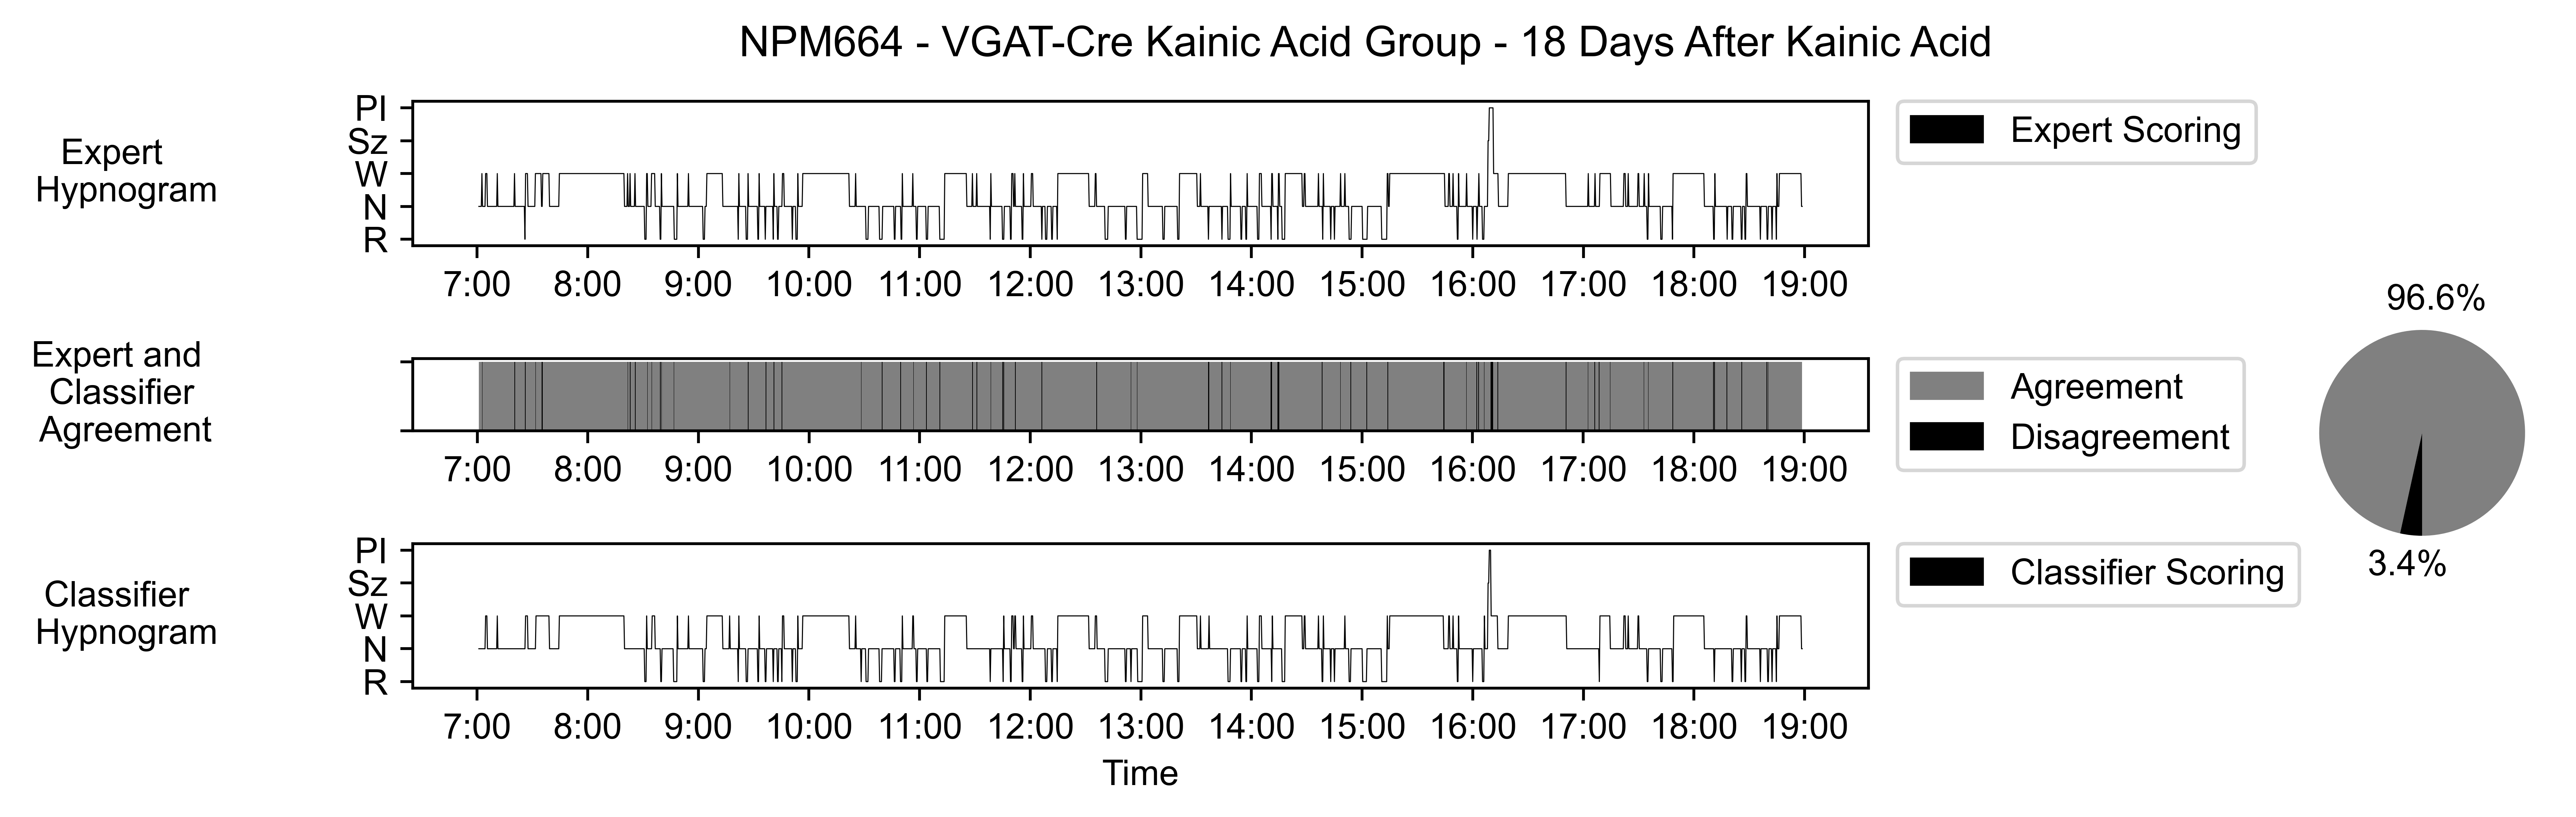

Saline Control Agreement


'file: '

'agreement: '

'max agreement: '

'min agreement: '

'std dev of agreement: '

'confidence: '

Whole Dataset Agreement
Kainic Acid Treatment Agreement


'file: 1'

'agreement: 0.9651810584958217'

'max agreement: 0.9651810584958217'

'min agreement: 0.9651810584958217'

'std dev of agreement: 0'

'confidence: 0.20000000298023224'

NPM661-664_m4_NPM664_210711_070952_053_SlSz.npy_trainset_expert_scored.csv
NPM664 - VGAT-Cre Kainic Acid Group - 18 Days After Kainic Acid
day


C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\site-packages\numpy\lib\stride_tricks.py:538: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3485450711.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  agreePlot.set_yticklabels(agreePlot.get_yticklabels(),visible=False)


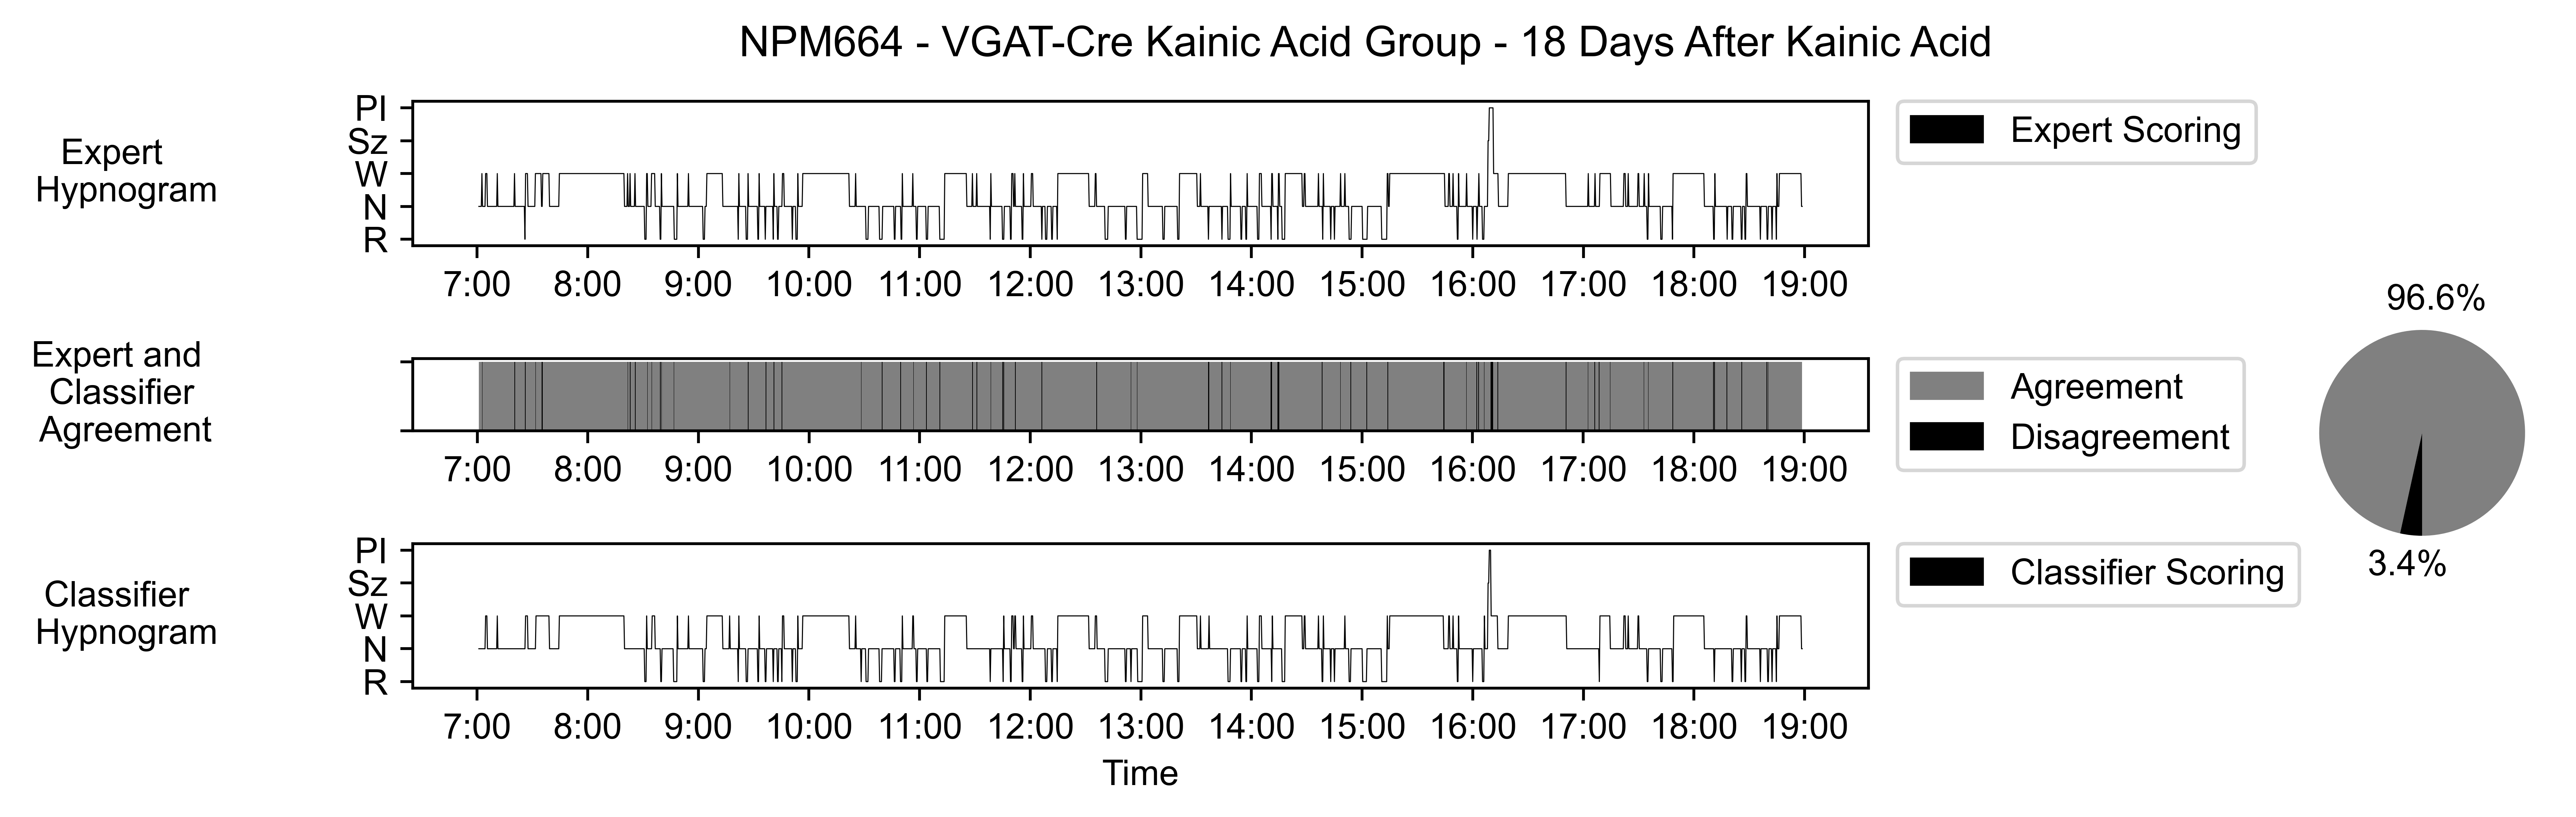

Saline Control Agreement


'file: '

'agreement: '

'max agreement: '

'min agreement: '

'std dev of agreement: '

'confidence: '

In [121]:
folder_list, use_type, skipped_type, Excluded_paper, Excluded_agreement, KA_list_paper, KA_pre_cannula = get_figure_params(mouse_sort_csvs, use_expert=1)
datasetSummary=getDatasetSummary(data_path)

plt.rcParams['figure.figsize'] = [80, 10]
mplstyle.use('fast')


KA_list=KA_list_paper+KA_pre_cannula
Excluded=Excluded_agreement
print(Excluded)

# Controls: 644,645,646,647,
slope_sum=np.zeros((4,1))
avg_slope=np.zeros((4,1))
std_dev=0
Controls=False
plot=True
global_count=0
maxlen=2160
for validation_only in [True, False]:

    if validation_only==True:
        print('Validation Dataset Agreement')
    else:
        print('Whole Dataset Agreement')
    for Controls in [False, True]:
        if Controls==False:
            print('Kainic Acid Treatment Agreement')
        else:
            print('Saline Control Agreement')

        dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = init_displays()
        global_agreement, global_confidence, max_agree, min_agree, n_animals = init_vars()
        agreement_list=[]
        std_dev=0
        global_count=0
        for folder in folder_list[::1]:
        
            
            Control=0
            KA_flag=False
            skip=0
            bad_flag=0
            Sz_occur=0
            mouse_folder = f'{mouse_sort_csvs}{folder}/'
            filelist=sorted(os.listdir(mouse_folder))
        
            count_state = np.zeros((len(filelist),6))
            count_state_total = np.zeros((len(filelist),5))
            cumu_sum = np.zeros((len(filelist),5))
        
            if os.path.isdir(f'{path_figs}{folder}')==False:
                os.mkdir(f'{path_figs}{folder}')
        
            filelist = [f for f in filelist if use_type in f]     
            for KA in KA_list:
                if f'{KA}' in folder:
                    KA_flag=True
        
            for Excl in Excluded:
                if f'{Excl}' in folder:
                    skip=1
    
            if validation_only==True:
                if folder not in testing_names:
                    skip=1
                
            if KA_flag!=Controls and skip==0:
                # print(folder)
                sz=0
                total = len(filelist)
                # print(total)
                arr = np.zeros((total,2))
                count=0
                
        
                if len(filelist)>0:
                    file_accuracy=np.ndarray((len(filelist),2), dtype='object')
                    for item in sorted(filelist[::1]):
                        if 'un' not in item:
        

                            
                            idx=filelist.index(item)
                            file_accuracy[idx,0]=item
                            
                            expert_array, classifier_array, confidence_gradient = load_expert_and_classifier(mouse_folder, item)

                            agreement = classifier_array == expert_array[3:-3]
    
                            agree_pct=len(agreement[agreement==True])/len(agreement)
                        
                            file_accuracy[idx,1]=agree_pct
            
                            # np.savetxt(f'{path_results}{folder}_agreement_by_file.txt',file_accuracy,fmt='%s')
                            ind_name = item.rfind('NPM')
                            name = item[ind_name:ind_name+6]
                            date = item[ind_name+7:ind_name+13]
                            time = item[ind_name+14:ind_name+20]

                            if name=='NPM664' and item=='NPM661-664_m4_NPM664_210711_070952_053_SlSz.npy_trainset_expert_scored.csv':
                                pass
                            else:
                                continue
                            
                            genotype=datasetSummary[datasetSummary['Name']==name]['Genotype'].to_string(index=False)
                            condition=datasetSummary[datasetSummary['Name']==name]['Condition'].to_string(index=False)

                            diff=(pd.to_datetime(date,yearfirst=True)-datasetSummary[datasetSummary['Name']==name]['Condition Start Date'])
                            relativeDate=diff[diff.index[0]].components.days
                            print(item)
                            if relativeDate==-1 or relativeDate==1:
                                dayString='Day'
                            else:
                                dayString='Days'
                            
                            if relativeDate<0:
                                treatmentString='Before Kainic Acid'
                            else:
                                treatmentString='After Kainic Acid'

                            if condition=='KA':
                                condition='Kainic Acid Group'
                            else:
                                condition='Saline Group'
                            
                            if int(time[:2])<19:
                                Z_time='day'

                            else:
                                Z_time='night'

                            relativeString=f'{abs(relativeDate)} {dayString} {treatmentString}' 

                            title=f'{name} - {genotype} {condition} - {relativeString}'
                            print(title)
                            print(Z_time)

                            hypnogram_folder=f'{path_figs}{name}/'
                            
                            agreement, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count = update_vars(classifier_array, expert_array,  confidence_gradient, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count)
                            dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = update_displays(min_agree, max_agree, global_agreement, std_dev, global_confidence, count, global_count)
                            plot_agreement_figure(classifier_array, expert_array, agreement, confidence_gradient, Z_time, title, hypnogram_folder)
            
                
    

# Evaluate 4 Second Epochs

In [139]:
epoch_length=4
data_path_4, path_Fourier_4, path_output_4, path_variables_4, path_results_4 = setPaths(data_path=None, epoch_length=epoch_length)
%cd $data_path_4

path_unscored, path_classifier_scores, mouse_sort_csvs, path_expert_scores, path_figs, path_excel, path_conf = generate_output_folders(path_output_4)

C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Four Second Epochs
C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Four Second Epochs


In [123]:
model_path=data_path+'Results_GPU/Final Model/Final Model BiLSTM200.h5'
model=load_model(model_path)
model.compile()

model.summary()

held_cohorts = []


# held_dates=held_cohorts+controls+held_dates
held_dates=[]

scoretypes=[[0,'unscored'],[1,'class_scored'],[2,'expert_scored']]

paths=(data_path_4,path_Fourier_4)
csv_paths=(path_output_4,path_classifier_scores,path_expert_scores,path_unscored,path_conf)

path=path_Fourier_4
fourier_files_all_4 = [f for f in listdir(path) if isfile(join(path, f))]
fourier_files_all_4 = [join(path,f) for f in fourier_files_all_4 if ".npy" in f and '566-568' not in f]   # find all x arrays in fourier_files
fourier_files_all_4 = quality_check_scoring(fourier_files_all_4)



print(f'Generating CSVs for files')
score_data(fourier_files_all_4, paths, csv_paths, model, errors, load_dropped_data=0, held_dates=[])

Model: "sequential_215"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_264 (Bidirect  (None, 7, 400)           481600    
 ional)                                                          
                                                                 
 dropout_314 (Dropout)       (None, 7, 400)            0         
                                                                 
 flatten_215 (Flatten)       (None, 2800)              0         
                                                                 
 dense_263 (Dense)           (None, 5)                 14005     
                                                                 
 activation_215 (Activation)  (None, 5)                0         
                                                                 
Total params: 495,605
Trainable params: 495,605
Non-trainable params: 0
______________________________________________

'Items left: 0'

'loaded x and y for NPM665-668_m4_NPM668_210725_190319_018_NoNo.npy'

'0.9304447270568607'

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000


[0.9407078006299796,
 0.9608115619788772,
 0.9494163424124513,
 0.968130442838614,
 0.9325551232166018,
 0.9556234945340004,
 0.8927181767648694,
 0.9380211228460256,
 0.9095793959607189,
 0.9560867148415787,
 0.9151380396516583,
 0.9382990550305725,
 0.8938299055030573,
 0.8888271261812117,
 0.862330924587734,
 0.9265332592180842,
 0.9242171576801927,
 0.9586807485640171,
 0.9463590883824347,
 0.9704465443765055,
 0.9111543450064851,
 0.9506207152121549,
 0.9319066147859922,
 0.8321289605336298,
 0.9299610894941635,
 0.9270891235871781,
 0.9042060403928108,
 0.9450620715212155,
 0.9297758013711321,
 0.9370020381693533,
 0.9112469890680007,
 0.9396887159533074,
 0.931443394478414,
 0.942745969983324,
 0.9458032240133407,
 0.9395034278302761,
 0.9144895312210487,
 0.9193996664813785,
 0.9080970909764684,
 0.9357976653696498,
 0.8853992959051324,
 0.9487678339818417,
 0.911432277191032,
 0.9416342412451362,
 0.9307022419862887,
 0.9471928849360756,
 0.8904020752269779,
 0.961367426347971

In [124]:
print(path_csv)

C:/Users/BHARVE4/Documents/Python Notebooks/eNeuro Retrain May 11 2025/Training Run/Twenty Second Epochs/CSV_Outputs/csv_classifier_prev_un_scored/


In [125]:
for sel in [0,1,2]:

  filepath = [path_unscored,path_classifier_scores,path_expert_scores][sel]
  filelist=os.listdir(filepath)
  print(len(filelist))
  # print(sorted(filelist))
  count=0
  if count==0:
    dh1 = display(f'Items left: {len(filelist)}',display_id=True)

  for item in sorted(filelist)[::-1]:
    if '.csv' in item:

      count+=1    
      
      if count%50==0 or (len(filelist)-count)==0:
        dh1.update(f'Items left: {len(filelist)-count}')

      ## Extract Mouse Name
      ind_name = item.rfind('NPM')
      name = item[ind_name:ind_name+6]
      
      path_out=f'{mouse_sort_csvs}{name}/'

      if os.path.exists(path_out)==0:
        os.mkdir(path_out)

      if os.path.isfile(f'{path_out}{item}')==0:
        shutil.copy(f'{filepath}{item}', f'{path_out}{item}')

4521


'Items left: 0'

1511


'Items left: 0'

1511


'Items left: 0'

# R&K 4s

In [126]:
# Set figure size to 20 x 10
plt.rcParams['figure.figsize'] = [20, 10]
mplstyle.use('fast')

# List all mouse folders
folderlist=sorted(os.listdir(mouse_sort_csvs))
folderlist=[f for f in sorted(os.listdir(mouse_sort_csvs)) if '.csv' not in f]
print(folderlist)

# Flags to use either expert scores or classifier scores
use_expert=0
skipped_type='expert_scored'
use_type='classifier'

score_label='Trained or Tested Data'

slope_sum=np.zeros((4,1))
avg_slope=np.zeros((4,1))

# Display handles for R&K agreement
dh1=display(f'agreement: ',display_id=True)
dh2=display(f'violation: ',display_id=True)

# Tracking variables for use in for loop
global_agreement=0
n_animals=0
global_count=0
violations_total=np.zeros((3))

# Iterate over all animals, to evaluate by treatment group
for Controls in [False,True]:
    for folder in folderlist[::-1]:

        # Reset flags for each animal's folder
        KA_flag=False
        skip=0
        mouse_folder = f'{mouse_sort_csvs}{folder}/'
        filelist=sorted(os.listdir(mouse_folder))

        filelist = [f for f in filelist if use_type in f]   
        
        # Check if animal is a KA-treated animal
        for KA in KA_list:
            if f'{KA}' in folder:
                KA_flag=True

        # Check if animal is in exclusion list
        for Excl in Excluded:
            if f'{Excl}' in folder:
                skip=1

        # If animal matches treatment group flag and is not excluded then
        if KA_flag!=Controls and skip==0:
            if len(filelist)>0:
                # Iterate over all files
                for item in filelist[::1]:
                    path = open(f'{mouse_folder}{item}')

                    # Load only classifier-scored files
                    if 'expert_scored' not in item:
                        y_pred = np.loadtxt(path, delimiter=",",dtype='int')   

                    # Run R&K evaluation algorithm and log agreements
                    agree_pct, agreement, violations_total, y_pred = R_and_K_evaluation(y_pred, violations_total)
                    
                    # Add agreement percent to running tally
                    global_agreement+=agree_pct            

                    global_count+=1
                    # Calculate global agreement, and update display with this along with type of R&K violations
                    dh1.update(f'{global_agreement/global_count}')
                    dh2.update(f'violations: {np.sum(violations_total)}')

# Print total file count
print(global_count)
# Print percent of R&K errors
print(1-global_agreement/global_count)
# Print total number of R&K errors
print(violations_total)
# Print relative percentage of types of R&K errors
print(violations_total/(np.sum(violations_total)))

['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']


'0.9936324444733967'

'violations: 80347.0'

1169
0.006367555526603286
[    0. 40255. 40092.]
[0.         0.50101435 0.49898565]


# Agreement 4s

In [128]:
folderlist, use_type, skipped_type, Excluded_paper, Excluded_agreement, KA_list_paper, KA_pre_cannula = get_figure_params(mouse_sort_csvs, use_expert=1)
plt.rcParams['figure.figsize'] = [80, 10]
mplstyle.use('fast')


KA_list=KA_list_paper+KA_pre_cannula
Excluded=Excluded_agreement
print(Excluded)

# Controls: 644,645,646,647,
slope_sum=np.zeros((4,1))
avg_slope=np.zeros((4,1))

Controls=False
plot=True
global_count=0
maxlen=2160*5
for validation_only in [True, False]:

    if validation_only==True:
        print('Validation Dataset Agreement')
    else:
        print('Whole Dataset Agreement')
    for Controls in [False, True]:
        if Controls==False:
            print('Kainic Acid Treatment Agreement')
        else:
            print('Saline Control Agreement')

        dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = init_displays()
        global_agreement, global_confidence, max_agree, min_agree, n_animals = init_vars()
        agreement_list=[]
        std_dev=0
        global_count=0
        for folder in folder_list[::1]:
        
            
            Control=0
            KA_flag=False
            skip=0
            bad_flag=0
            Sz_occur=0
            mouse_folder = f'{mouse_sort_csvs}{folder}/'
            filelist=sorted(os.listdir(mouse_folder))
        
            count_state = np.zeros((len(filelist),6))
            count_state_total = np.zeros((len(filelist),5))
            cumu_sum = np.zeros((len(filelist),5))
        
            if os.path.isdir(f'{path_figs}{folder}')==False:
                os.mkdir(f'{path_figs}{folder}')
        
            filelist = [f for f in filelist if use_type in f]     
            for KA in KA_list:
                if f'{KA}' in folder:
                    KA_flag=True
        
            for Excl in Excluded:
                if f'{Excl}' in folder:
                    skip=1
    
            if validation_only==True:
                if folder not in testing_names:
                    skip=1
                
            if KA_flag!=Controls and skip==0:
                print(folder)
                sz=0
                total = len(filelist)
                print(total)
                arr = np.zeros((total,2))
                count=0
                
        
                if len(filelist)>0:
                    file_accuracy=np.ndarray((len(filelist),2), dtype='object')
                    for item in filelist[::1]:
                        if 'un' not in item:
        

                            
                            idx=filelist.index(item)
                            file_accuracy[idx,0]=item
                            
                            expert_array, classifier_array, confidence_gradient = load_expert_and_classifier(mouse_folder, item)

                            agreement = classifier_array == expert_array[3:-3]
    
                            agree_pct=len(agreement[agreement==True])/len(agreement)
                        
                            file_accuracy[idx,1]=agree_pct
            
                            # np.savetxt(f'{path_results}{folder}_agreement_by_file.txt',file_accuracy,fmt='%s')
                            ind_name = item.find('NPM')
                            name = item[ind_name:ind_name+6]
                            date = item[ind_name+7:ind_name+13]
                            time = item[ind_name+14:ind_name+20]
                            
                            agreement, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count  = update_vars(classifier_array, expert_array,  confidence_gradient, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count)
                            dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = update_displays(min_agree, max_agree, global_agreement, std_dev, global_confidence, count, global_count)
            
            
                
    

['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[565, 568, 573, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 662, 665, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 573, 576, 568, 573

'file: 211'

'agreement: 0.9305608610014154'

'max agreement: 0.985176950157495'

'min agreement: 0.5166759310728183'

'std dev of agreement: 0.04303230442421564'

'confidence: 0.2000000023446377'

NPM648
2
NPM649
17
NPM650
16
NPM652
16
NPM653
16
NPM654
16
NPM655
16
NPM656
16
NPM661
16
NPM663
16
NPM664
16
NPM666
16
NPM667
16
NPM668
16
Saline Control Agreement


'file: 48'

'agreement: 0.9547240751034519'

'max agreement: 0.9868445432647768'

'min agreement: 0.8956827867333704'

'std dev of agreement: 0.016211519123969148'

'confidence: 0.2000000032906731'

NPM645
16
NPM646
16
NPM647
16
Whole Dataset Agreement
Kainic Acid Treatment Agreement


'file: 850'

'agreement: 0.9340755757555927'

'max agreement: 0.985176950157495'

'min agreement: 0.43959607189179173'

'std dev of agreement: 0.04055607760931507'

'confidence: 0.20000000259455514'

NPM577
11
NPM589
47
NPM590
56
NPM593
42
NPM595
42
NPM605
17
NPM606
17
NPM607
17
NPM608
17
NPM610
17
NPM611
17
NPM612
16
NPM613
16
NPM615
17
NPM617
18
NPM620
16
NPM621
16
NPM622
16
NPM624
16
NPM625
16
NPM626
16
NPM628
16
NPM629
16
NPM632
16
NPM633
16
NPM634
16
NPM635
16
NPM636
16
NPM637
16
NPM638
15
NPM639
16
NPM640
17
NPM648
2
NPM649
17
NPM650
16
NPM651
0
NPM652
16
NPM653
16
NPM654
16
NPM655
16
NPM656
16
NPM657
0
NPM661
16
NPM663
16
NPM664
16
NPM666
16
NPM667
16
NPM668
16
Saline Control Agreement


'file: 319'

'agreement: 0.9381550065838267'

'max agreement: 0.9868445432647768'

'min agreement: 0.37493051695386326'

'std dev of agreement: 0.040885197018538676'

'confidence: 0.20000000265324752'

NPM579
56
NPM592
56
NPM596
56
NPM604
17
NPM609
54
NPM614
16
NPM641
0
NPM644
16
NPM645
16
NPM646
16
NPM647
16


# Export Excel

In [148]:
epoch_length=4
data_path_4, path_Fourier_4, path_output_4, path_variables_4, path_results_4 = setPaths(data_path=None, epoch_length=epoch_length)
%cd $data_path_4

path_unscored, path_classifier_scores, mouse_sort_csvs, path_expert_scores, path_figs, path_excel, path_conf = generate_output_folders(path_output_4)

pd.ExcelWriter.handles=None
pd.ExcelWriter.close
styles=['Average_Bout_Length_Per_Hour',
    'State_Seconds_Per_Hour',
    'Bout_Occurrence_Per_Hour',
       'State_Transitions']
start_dates,end_dates=get_start_end(data_path)
manual_dates=get_manual_dates(data_path)

print(manual_dates)
for style in styles:
    for Controls in [False,True]:
        for use_expert in [False]:

            if use_expert==True:
                expert_dates_flags=[False,True]
            elif use_expert==False:
                expert_dates_flags=[False]

            for use_expert_dates in expert_dates_flags:

                if use_expert==False and use_expert_dates==True:
                    exp_dates_string='_exp_dates'
                else:
                    exp_dates_string=''

                target_folders, skipped_type=prep_folder_list(Controls, use_expert)
                print(skipped_type)

                if Controls==False and use_expert==False:
                    excel_name=f'{path_output_4}excel/KA_{style}{exp_dates_string}.xlsx'

                if Controls==False and use_expert==True:
                    excel_name=f'{path_output_4}excel/Expert_KA_{style}{exp_dates_string}.xlsx'

                if Controls==True and use_expert==False:
                    excel_name=f'{path_output_4}excel/Controls_{style}{exp_dates_string}.xlsx'

                if Controls==True and use_expert==True:
                    excel_name=f'{path_output_4}excel/Expert_Controls_{style}{exp_dates_string}.xlsx'



                with pd.ExcelWriter(excel_name) as writer:  

                    for folder in target_folders[:]:
                        name=folder
                        skip=0
                        if name in Excluded:
                            skip=1

                        mouse_folder = f'{mouse_sort_csvs}{folder}/'
                        filelist=sorted(os.listdir(mouse_folder))

                        filelist = [f for f in filelist if skipped_type not in f]   

                        print(folder)
                        total = len(filelist)

                        arr = np.zeros((total,2))

                        count=0
                        count_file=0

                        len_state = np.zeros((len(filelist),5))
                        legend=[]

                        state_counts_per_hour, transition_code_list=make_pandas_labels(filelist, style, use_expert_dates, Excluded, manual_dates, start_dates, end_dates)

                        # display(state_counts_per_hour)

                        if len(filelist)>0:
                            # print(len(filelist))
                            alldates=[[]]
                            for item in sorted(filelist[:]): 
                                # print(item)   
                                path = open(f'{mouse_folder}{item}')

                                ind_name = item.rfind('NPM')
                                name = item[ind_name:ind_name+6]
                                date = item[ind_name+7:ind_name+13]
                                time = item[ind_name+14:ind_name+20]

                                if True==skip_check(name, date, use_expert_dates, Excluded, manual_dates, start_dates, end_dates):
                                    continue

                                if date not in alldates and int(time)<190000:
                                    # print(time)
                                    # print(int(time))
                                    alldates.append(date)

                                    if use_expert==1:
                                        numtype='float'
                                    else:
                                        numtype='int'

                                    if skipped_type not in item:
                                        # print(item)
                                        light_scores = np.loadtxt(path, delimiter=",",dtype=numtype)
                                        path.close()

                                    if len(filelist)>(filelist.index(item)+1):
                                        nightfile=filelist[filelist.index(item)+1]
                                        if skipped_type not in nightfile:

                                            path2=open(f'{mouse_folder}{nightfile}')

                                            # print(nightfile)
                                            dark_scores = np.loadtxt(path2, delimiter=",",dtype=numtype)

                                    else:
                                        dark_scores=[666]*12

                                    hours=count_states(style, light_scores, dark_scores, epoch_length, transition_code_list)



                                    # print(hours)
                                    state_counts_per_hour[date]=hours

    #                         if skip!=1:
    #                             for column_header, take_columns in [('Week 0',range(0,7)), ('Week 2', range(7,14)),('Week 3', range(14,21)),('Week 4', range(21,28)),('Experimental', range(0,28))]:
    #                                 for row in range(len(state_counts_per_hour)):
    #                                     if type(state_counts_per_hou.iloc[i,0]):
    #                                          state_counts_per_hour[column_header]=state_counts_per_hour.iloc[row,take_columns].mean(axis=1)
    #                                     # pd.concat([week_column,mean], axis=0,ignore_index=True)
    #                                 week_column=pd.DataFrame(mean, columns=[column_header])

    #                                 print(week_column)
    #                                 state_counts_per_hour=pd.concat([state_counts_per_hour,week_column], axis=1)
    #                             pd.ExcelWriter.handles=None
    #                             pd.ExcelWriter.close
    #                             break

                        # n_animals+=1
                        # with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
                        #   display(state_counts_per_hour)
                        if skip!=1:
                            state_counts_per_hour.to_excel(writer, sheet_name=f'{folder}')
                    
pd.ExcelWriter.handles=None
pd.ExcelWriter.close

C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Four Second Epochs
C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Four Second Epochs
     NPM566    NPM567  NPM568    NPM569    NPM570    NPM571    NPM572  NPM574  \
0  191008.0  191009.0     NaN  191015.0  191015.0  191016.0  191016.0  200107   
1  191015.0  191016.0     NaN  191022.0  191022.0  191023.0  191023.0  200108   
2  191020.0  191021.0     NaN  191027.0  191027.0  191028.0  191028.0  200109   
3  191021.0  191022.0     NaN  191018.0  191018.0  191029.0  191029.0  200116   
4  191022.0  191023.0     NaN  191029.0  191029.0  191030.0  191030.0  200123   
5       NaN       NaN     NaN       NaN       NaN       NaN       NaN  200128   
6       NaN       NaN     NaN       NaN       NaN       NaN       NaN  200129   
7       NaN       NaN     NaN       NaN       NaN       NaN       NaN  200130   

   NPM575  NPM576  ...  NPM656  NPM658  NPM659  NPM661  NPM663  

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[568, 573, 577, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 641, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 665, 630, 631, 641, 643, 648

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[568, 573, 577, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 641, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 665, 630, 631, 641, 643, 648

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[568, 573, 577, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 641, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 665, 630, 631, 641, 643, 648

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


<function pandas.io.excel._base.ExcelWriter.close(self) -> 'None'>

# Export Excel Twenty Second Epochs

In [ ]:
epoch_length=20
data_path, path_Fourier, path_output, path_variables, path_results = setPaths(data_path=None, epoch_length=20)
%cd $data_path

path_unscored, path_classifier_scores, mouse_sort_csvs, path_expert_scores, path_figs, path_excel, path_conf = generate_output_folders(path_output)

pd.ExcelWriter.handles=None
pd.ExcelWriter.close
styles=['Average_Bout_Length_Per_Hour',
    'State_Seconds_Per_Hour',
    'Bout_Occurrence_Per_Hour',
       'State_Transitions']
start_dates,end_dates=get_start_end(data_path)
manual_dates=get_manual_dates(data_path)

print(manual_dates)
for style in styles:
    for Controls in [False,True]:
        for use_expert in [False]:

            if use_expert==True:
                expert_dates_flags=[False,True]
            elif use_expert==False:
                expert_dates_flags=[False]

            for use_expert_dates in expert_dates_flags:

                if use_expert==False and use_expert_dates==True:
                    exp_dates_string='_exp_dates'
                else:
                    exp_dates_string=''

                target_folders, skipped_type=prep_folder_list(Controls, use_expert)
                print(skipped_type)

                if Controls==False and use_expert==False:
                    excel_name=f'{path_output}excel/KA_{style}{exp_dates_string}.xlsx'

                if Controls==False and use_expert==True:
                    excel_name=f'{path_output}excel/Expert_KA_{style}{exp_dates_string}.xlsx'

                if Controls==True and use_expert==False:
                    excel_name=f'{path_output}excel/Controls_{style}{exp_dates_string}.xlsx'

                if Controls==True and use_expert==True:
                    excel_name=f'{path_output}excel/Expert_Controls_{style}{exp_dates_string}.xlsx'



                with pd.ExcelWriter(excel_name) as writer:  

                    for folder in target_folders[:]:
                        name=folder
                        skip=0
                        if name in Excluded:
                            skip=1

                        mouse_folder = f'{mouse_sort_csvs}{folder}/'
                        filelist=sorted(os.listdir(mouse_folder))

                        filelist = [f for f in filelist if skipped_type not in f]   

                        print(folder)
                        total = len(filelist)

                        arr = np.zeros((total,2))

                        count=0
                        count_file=0

                        len_state = np.zeros((len(filelist),5))
                        legend=[]

                        state_counts_per_hour, transition_code_list=make_pandas_labels(filelist, style, use_expert_dates, Excluded, manual_dates, start_dates, end_dates)

                        # display(state_counts_per_hour)

                        if len(filelist)>0:
                            # print(len(filelist))
                            alldates=[[]]
                            for item in sorted(filelist[:]): 
                                # print(item)   
                                path = open(f'{mouse_folder}{item}')

                                ind_name = item.rfind('NPM')
                                name = item[ind_name:ind_name+6]
                                date = item[ind_name+7:ind_name+13]
                                time = item[ind_name+14:ind_name+20]

                                if True==skip_check(name, date, use_expert_dates, Excluded, manual_dates, start_dates, end_dates):
                                    continue

                                if date not in alldates and int(time)<190000:
                                    # print(time)
                                    # print(int(time))
                                    alldates.append(date)

                                    if use_expert==1:
                                        numtype='float'
                                    else:
                                        numtype='int'

                                    if skipped_type not in item:
                                        # print(item)
                                        light_scores = np.loadtxt(path, delimiter=",",dtype=numtype)
                                        path.close()

                                    if len(filelist)>(filelist.index(item)+1):
                                        nightfile=filelist[filelist.index(item)+1]
                                        if skipped_type not in nightfile:

                                            path2=open(f'{mouse_folder}{nightfile}')

                                            # print(nightfile)
                                            dark_scores = np.loadtxt(path2, delimiter=",",dtype=numtype)

                                    else:
                                        dark_scores=[666]*12

                                    hours=count_states(style, light_scores, dark_scores, epoch_length, transition_code_list)



                                    # print(hours)
                                    state_counts_per_hour[date]=hours

    #                         if skip!=1:
    #                             for column_header, take_columns in [('Week 0',range(0,7)), ('Week 2', range(7,14)),('Week 3', range(14,21)),('Week 4', range(21,28)),('Experimental', range(0,28))]:
    #                                 for row in range(len(state_counts_per_hour)):
    #                                     if type(state_counts_per_hou.iloc[i,0]):
    #                                          state_counts_per_hour[column_header]=state_counts_per_hour.iloc[row,take_columns].mean(axis=1)
    #                                     # pd.concat([week_column,mean], axis=0,ignore_index=True)
    #                                 week_column=pd.DataFrame(mean, columns=[column_header])

    #                                 print(week_column)
    #                                 state_counts_per_hour=pd.concat([state_counts_per_hour,week_column], axis=1)
    #                             pd.ExcelWriter.handles=None
    #                             pd.ExcelWriter.close
    #                             break

                        # n_animals+=1
                        # with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
                        #   display(state_counts_per_hour)
                        if skip!=1:
                            state_counts_per_hour.to_excel(writer, sheet_name=f'{folder}')
                    
pd.ExcelWriter.handles=None
pd.ExcelWriter.close

C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Twenty Second Epochs
C:\Users\BHARVE4\Documents\Python Notebooks\eNeuro Retrain May 11 2025\Training Run\Twenty Second Epochs
     NPM566    NPM567  NPM568    NPM569    NPM570    NPM571    NPM572  NPM574  \
0  191008.0  191009.0     NaN  191015.0  191015.0  191016.0  191016.0  200107   
1  191015.0  191016.0     NaN  191022.0  191022.0  191023.0  191023.0  200108   
2  191020.0  191021.0     NaN  191027.0  191027.0  191028.0  191028.0  200109   
3  191021.0  191022.0     NaN  191018.0  191018.0  191029.0  191029.0  200116   
4  191022.0  191023.0     NaN  191029.0  191029.0  191030.0  191030.0  200123   
5       NaN       NaN     NaN       NaN       NaN       NaN       NaN  200128   
6       NaN       NaN     NaN       NaN       NaN       NaN       NaN  200129   
7       NaN       NaN     NaN       NaN       NaN       NaN       NaN  200130   

   NPM575  NPM576  ...  NPM656  NPM658  NPM659  NPM661  NPM6

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]
Exception ignored in: <function ZipFile.__del__ at 0x0000028ABE38D5A0>
Traceback (most recent call last):
  File "C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\zipfile.py", line 1808, in __del__
    self.close()
  File "C:\Users\BHARVE4\AppData\Local\anaconda3\envs\SWISC_310_tf210\lib\zipfile.py", line 1825, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:89: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[568, 573, 577, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 641, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 665, 630, 631, 641, 643, 648

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:40: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[568, 573, 577, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 641, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 665, 630, 631, 641, 643, 648

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:140: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind_pres=np.where(window==count_state)[0]


['NPM569', 'NPM570', 'NPM571', 'NPM572', 'NPM573', 'NPM574', 'NPM575', 'NPM576', 'NPM577', 'NPM578', 'NPM579', 'NPM580', 'NPM589', 'NPM590', 'NPM591', 'NPM592', 'NPM593', 'NPM594', 'NPM595', 'NPM596', 'NPM604', 'NPM605', 'NPM606', 'NPM607', 'NPM608', 'NPM609', 'NPM610', 'NPM611', 'NPM612', 'NPM613', 'NPM614', 'NPM615', 'NPM616', 'NPM617', 'NPM618', 'NPM619', 'NPM620', 'NPM621', 'NPM622', 'NPM623', 'NPM624', 'NPM625', 'NPM626', 'NPM627', 'NPM628', 'NPM629', 'NPM630', 'NPM631', 'NPM632', 'NPM633', 'NPM634', 'NPM635', 'NPM636', 'NPM637', 'NPM638', 'NPM639', 'NPM640', 'NPM641', 'NPM642', 'NPM644', 'NPM645', 'NPM646', 'NPM647', 'NPM648', 'NPM649', 'NPM650', 'NPM651', 'NPM652', 'NPM653', 'NPM654', 'NPM655', 'NPM656', 'NPM657', 'NPM658', 'NPM659', 'NPM661', 'NPM662', 'NPM663', 'NPM664', 'NPM665', 'NPM666', 'NPM667', 'NPM668']
[568, 573, 577, 578, 591, 594, 616, 618, 619, 623, 627, 630, 631, 641, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 665, 630, 631, 641, 643, 648

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM576
NPM573-576_m4_NPM576_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM580
NPM577-580_m4_NPM580_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM589
NPM589-592_m1_NPM589_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM590
NPM589-592_m2_NPM590_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM593
NPM593-596_m1_NPM593_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM595
NPM593-596_m3_NPM595_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM605
NPM604-607_m2_NPM605_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM606
NPM604-607_m3_NPM606_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM607
NPM604-607_m4_NPM607_200608_144643_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM608
NPM608-611_m1_NPM608_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM610
NPM608-611_m3_NPM610_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM611
NPM608-611_m4_NPM611_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM612
NPM612-615_m1_NPM612_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM613
NPM612-615_m2_NPM613_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM615
NPM612-615_m4_NPM615_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '2008

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM617
NPM616-619_m2_NPM617_200713_182937_000_NoNo.npy_prev_un_scored.csv
['200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812', '200813', '200814', '200815', '200816', '200817', '200818', '200819', '200820', '200821', '200822', '200823', '200824', '200825', '200826', '200827', '200828', '200829', '200830', '200831', '200901']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM620
NPM520-523_m1_NPM620_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM621
NPM520-523_m2_NPM621_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM622
NPM520-523_m3_NPM622_201026_133650_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM624
NPM524-527_m1_NPM624_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM625
NPM524-527_m2_NPM625_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM626
NPM524-527_m3_NPM626_201026_133408_000_NoNo.npy_prev_un_scored.csv
['201028', '201029', '201030', '201031', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201113', '201114', '201115', '201116', '201117', '201118', '201119', '201120', '201121', '201122', '201123', '201124', '201125']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM628
NPM628-631_m1_NPM628_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM629
NPM628-631_m2_NPM629_201207_182208_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM632
NPM632-634_m1_NPM632_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM633
NPM632-634_m2_NPM633_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM634
NPM632-634_m3_NPM634_201207_182356_000_NoNo.npy_prev_un_scored.csv
['201209', '201210', '201211', '201212', '201213', '201214', '201215', '201216', '201217', '201218', '201219', '201220', '201221', '201222', '201223', '201224', '201225', '201226', '201227', '201228', '201229', '201230', '201231', '210101', '210102', '210103', '210104', '210105', '210106']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM635
NPM632-634_m4_NPM635_201207_182356_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM636
NPM635-638_m2_NPM636_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']
NPM637
NPM635-638_m3_NPM637_210125_153415_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '2102

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM640
NPM639-642_m2_NPM640_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM642
NPM639-642_m4_NPM642_210125_140616_000_NoNo.npy_prev_un_scored.csv
['210127', '210128', '210129', '210130', '210131', '210201', '210202', '210203', '210204', '210205', '210206', '210207', '210208', '210209', '210210', '210211', '210212', '210213', '210214', '210215', '210216', '210217', '210218', '210219', '210220', '210221', '210222', '210223', '210224']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM661
NPM661-664_m1_NPM661_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM664
NPM661-664_m4_NPM664_210614_151539_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '210705', '210706', '210707', '210708', '210709', '210710', '210711', '210712', '210713', '210714']
NPM666
NPM665-668_m2_NPM666_210614_151504_000_NoNo.npy_prev_un_scored.csv
['210616', '210617', '210618', '210619', '210620', '210621', '210622', '210623', '210624', '210625', '210626', '210627', '210628', '210629', '210630', '210701', '210702', '210703', '210704', '2107

C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM570
NPM569-572_m2_NPM570_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM571
NPM569-572_m3_NPM571_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM572
NPM569-572_m4_NPM572_191004_164847_000_NoNo.npy_prev_un_scored.csv
['191004', '191005', '191006', '191007', '191008', '191009', '191010', '191011', '191012', '191013', '191014', '191015', '191016', '191017', '191018', '191019', '191020', '191021', '191022', '191023', '191024', '191025', '191026', '191027', '191028', '191029', '191030', '191031']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM574
NPM573-576_m2_NPM574_191206_180811_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM579
NPM577-580_m3_NPM579_191206_182417_000_NoNo.npy_prev_un_scored.csv
['200103', '200104', '200105', '200106', '200107', '200108', '200109', '200110', '200111', '200112', '200113', '200114', '200115', '200116', '200117', '200118', '200119', '200120', '200121', '200122', '200123', '200124', '200125', '200126', '200127', '200128', '200129', '200130', '200131']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM592
NPM589-592_m4_NPM592_200217_180053_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM596
NPM593-596_m4_NPM596_200217_180116_000_NoNo.npy_prev_un_scored.csv
['200226', '200227', '200228', '200229', '200301', '200302', '200303', '200304', '200305', '200306', '200307', '200308', '200309', '200310', '200311', '200312', '200313', '200314', '200315', '200316', '200317', '200318', '200319', '200320', '200321', '200322', '200323', '200324', '200325']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM604
NPM604-607_m1_NPM604_200609_070007_001_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM609
NPM608-611_m2_NPM609_200608_144808_000_NoNo.npy_prev_un_scored.csv
['200610', '200611', '200612', '200613', '200614', '200615', '200616', '200617', '200618', '200619', '200620', '200621', '200622', '200623', '200624', '200625', '200626', '200627', '200628', '200629', '200630', '200701', '200702', '200703', '200704', '200705', '200706', '200707', '200708']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM614
NPM612-615_m3_NPM614_200713_182902_000_NoNo.npy_prev_un_scored.csv
['200715', '200716', '200717', '200718', '200719', '200720', '200721', '200722', '200723', '200724', '200725', '200726', '200727', '200728', '200729', '200730', '200731', '200801', '200802', '200803', '200804', '200805', '200806', '200807', '200808', '200809', '200810', '200811', '200812']
NPM644
NPM644-647_m1_NPM644_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM645
NPM644-647_m2_NPM645_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM646
NPM644-647_m3_NPM646_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


NPM647
NPM644-647_m4_NPM647_210315_131115_000_NoNo.npy_prev_un_scored.csv
['210317', '210318', '210319', '210320', '210321', '210322', '210323', '210324', '210325', '210326', '210327', '210328', '210329', '210330', '210331', '210401', '210402', '210403', '210404', '210405', '210406', '210407', '210408', '210409', '210410', '210411', '210412', '210413', '210414']


C:\Users\BHARVE4\AppData\Local\Temp\ipykernel_37372\3608381560.py:172: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  for ind_state_1 in np.where(window==state_1)[0]:


# Plot Hypnograms 4s

In [ ]:
datasetSummary = sleep.getDatasetSummary(data_path)
datasetSummary.head(10)

In [ ]:
folderlist, use_type, skipped_type, Excluded_paper, Excluded_agreement, KA_list_paper, KA_pre_cannula = get_figure_params( mouse_sort_csvs, use_expert=1 )


plt.rcParams['figure.figsize'] = [80, 10]
mplstyle.use('fast')


KA_list=KA_list_paper+KA_pre_cannula
Excluded=Excluded_agreement
print(Excluded)

# Controls: 644,645,646,647,
slope_sum=np.zeros((4,1))
avg_slope=np.zeros((4,1))
std_dev=0
Controls=False
plot=True
global_count=0
maxlen=2160*5
for validation_only in [True, False]:

    if validation_only==True:
        print('Validation Dataset Agreement')
    else:
        print('Whole Dataset Agreement')
    for Controls in [False, True]:
        if Controls==False:
            print('Kainic Acid Treatment Agreement')
        else:
            print('Saline Control Agreement')

        dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = init_displays()
        global_agreement, global_confidence, max_agree, min_agree, n_animals = init_vars()
        agreement_list=[]
        std_dev=0
        global_count=0
        for folder in folder_list[::1]:
        
            
            Control=0
            KA_flag=False
            skip=0
            bad_flag=0
            Sz_occur=0
            mouse_folder = f'{mouse_sort_csvs}{folder}/'
            filelist=sorted(os.listdir(mouse_folder))
        
            count_state = np.zeros((len(filelist),6))
            count_state_total = np.zeros((len(filelist),5))
            cumu_sum = np.zeros((len(filelist),5))
        
            if os.path.isdir(f'{path_figs}{folder}')==False:
                os.mkdir(f'{path_figs}{folder}')
        
            filelist = [f for f in filelist if use_type in f]     
            for KA in KA_list:
                if f'{KA}' in folder:
                    KA_flag=True
        
            for Excl in Excluded:
                if f'{Excl}' in folder:
                    skip=1
    
            if validation_only==True:
                if folder not in testing_names:
                    skip=1
                
            if KA_flag!=Controls and skip==0:
                print(folder)
                sz=0
                total = len(filelist)
                print(total)
                arr = np.zeros((total,2))
                count=0
                
        
                if len(filelist)>0:
                    file_accuracy=np.ndarray((len(filelist),2), dtype='object')
                    for item in sorted(filelist[::1]):
                        if 'un' not in item:
        

                            
                            idx=filelist.index(item)
                            file_accuracy[idx,0]=item
                            
                            expert_array, classifier_array, confidence_gradient = load_expert_and_classifier(mouse_folder, item)

                            agreement = classifier_array == expert_array[3:-3]
    
                            agree_pct=len(agreement[agreement==True])/len(agreement)
                        
                            file_accuracy[idx,1]=agree_pct
            
                            # np.savetxt(f'{path_results}{folder}_agreement_by_file.txt',file_accuracy,fmt='%s')
                            ind_name = item.rfind('NPM')
                            name = item[ind_name:ind_name+6]
                            date = item[ind_name+7:ind_name+13]
                            time = item[ind_name+14:ind_name+20]

                            if name=='NPM664' and item=='NPM661-664_m4_NPM664_210711_070952_053_SlSz.npy_trainset_expert_scored.csv':
                                pass
                            else:
                                continue
                            
                            genotype=datasetSummary[datasetSummary['Name']==name]['Genotype'].to_string(index=False)
                            condition=datasetSummary[datasetSummary['Name']==name]['Condition'].to_string(index=False)

                            diff=(pd.to_datetime(date,yearfirst=True)-datasetSummary[datasetSummary['Name']==name]['Condition Start Date'])
                            relativeDate=diff[diff.index[0]].components.days
                            print(item)
                            if relativeDate==-1 or relativeDate==1:
                                dayString='Day'
                            else:
                                dayString='Days'
                            
                            if relativeDate<0:
                                treatmentString='Before Kainic Acid'
                            else:
                                treatmentString='After Kainic Acid'

                            if condition=='KA':
                                condition='Kainic Acid Group'
                            else:
                                condition='Saline Group'
                            
                            if int(time[:2])<19:
                                Z_time='day'

                            else:
                                Z_time='night'

                            relativeString=f'{abs(relativeDate)} {dayString} {treatmentString}' 

                            title=f'{name} - {genotype} {condition} - {relativeString}'
                            print(title)
                            print(Z_time)
                            
                            agreement, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count,agreement_score = update_vars(classifier_array, expert_array,  confidence_gradient, min_agree, max_agree, global_agreement, agreement_list, std_dev, global_confidence, count, global_count)
                            dh_no, dh1, dh_maxagree, dh_minagree, dh_stddev, dh_conf = update_displays(min_agree, max_agree, global_agreement, std_dev, global_confidence, count, global_count)
                            plot_agreement_figure(classifier_array, expert_array, agreement, agreement_score, confidence_gradient, Z_time, title)
            
                